# COVID-19 air pollution project. 
## Finding D value
### Written by Bujin Bekbulat

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import scipy.stats as st
import scipy.io as sio
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
import statsmodels.stats.multicomp as multi
import matplotlib.dates as md
import datetime
from math import sqrt
import plotly.graph_objects as go
%matplotlib inline
from scipy.stats import iqr
from statistics import median 
from math import sin, cos, sqrt, atan2, radians
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)


In [2]:
#Reading file with all the states name
states = pd.read_csv("/Users/Bujin/Downloads/States.csv")

#Reading dates
dateparse = lambda dates: [pd.datetime.strptime(d, '%Y-%m-%d') for d in dates]

#dateparse = lambda dates: [pd.datetime.strptime(d, '%d/%m/%y') for d in dates]


#Defining output
DF=pd.DataFrame()
Slope=pd.DataFrame()
OT=pd.DataFrame()
adjusted=[]
idw=[]
total_mon=0
DF5=pd.DataFrame()
Slope5=pd.DataFrame()
OT5=pd.DataFrame()
adjusted5=[]
idw5=[]
lastday=2
twoweeks=16
length=125
totallength=191



#Calling each state file

Data = pd.read_csv("/Users/Bujin/Downloads/PM10.csv",parse_dates=['Date'], date_parser=dateparse)
    
a=[x for x in  list(set(Data['ID'])) if pd.notnull(x)] #each unique monitors in each state
total_mon=total_mon+len(a) #Counting total monitors

    #Defining output
df=pd.DataFrame()
slope1=pd.DataFrame()
ot=pd.DataFrame()
df5=pd.DataFrame()
slope15=pd.DataFrame()
ot5=pd.DataFrame()

    
    #for each station calculate D value   
for iii in range(0,len(a)):
       monitor=Data[Data['ID']==a[iii]]
       
       
       #Defining as variables
       #site=list(monitor['Site'])[0]     
       state=list(monitor['State'])[0] 
       idd=list(monitor['ID'])[0]
       county=list(monitor['County'])[0]
       lon=(list(monitor['Longitude'])[0])
       lat=(list(monitor['Latitude'])[0])
       weeknum=0
    
       #Defining output
       List10=[] 
       slope=[]  
       List5=[] 
       slope5=[]  

   
       #Starting filters
       
       #Days pre and post covid

       whole=monitor[monitor['Date']<pd.to_datetime('2020-09-'+str(lastday))] ##Change this date (add 7 days each week)
       twentytwenty=pd.concat([whole['Date'],whole['2020']],axis=1,sort=False)
       twentytwenty=twentytwenty.dropna()
       pre=twentytwenty[twentytwenty['Date']<pd.to_datetime('2020-03-19')]
       post=twentytwenty[twentytwenty['Date']>=pd.to_datetime('2020-03-19')]

       #Number of days for adjusting
       adjusting=monitor[monitor['Date']<pd.to_datetime('2020-09-'+str(twoweeks))] ## Change this date (add 7 days each week)

       #dropping years if it has incomplete data
       drop=adjusting.drop(['2020'],axis=1)
       drop=drop.dropna(thresh=0.75*len(adjusting), axis=1)
       
       #checking if it has 2 years out of last 3 years
       Iqr=pd.concat([adjusting['2019'],adjusting['2018'],adjusting['2017']],axis=1,sort=False)
       Iqr = Iqr.dropna(thresh=0.75*len(Iqr), axis=1)
       print(whole)
       
       start='2020-01-01'
       
       #Using monitors that have enough data
       if len(drop.columns)>=10 and len(post)>=length  and len(adjusting)>=totallength and len(pre)>=59 and len(Iqr.columns)>=2:   ##Change this (add 5 days on post and adjusting each week)
                                        
        for j in range(0,len(whole),7): # Week by week
            
           #Start and end date for each week
          start_d = pd.to_datetime(start) + datetime.timedelta(j)
          end_d = start_d + datetime.timedelta(7)
         
          week=monitor[monitor['Date']>=start_d]
          week=week[week['Date']<end_d]
          if len(week)>0: 
           #Week 
           twenty=pd.DataFrame(week["2020"])
           weeknum=weeknum+1 #Week #
           
           #Month (for adjusting)
           end_date = list(week['Date'])[0] + datetime.timedelta(days=21) # +2 weeks
           start_date = list(week['Date'])[0] - datetime.timedelta(days=14) # -2 weeks

        
           # First 2 weeks of the year, add december data from previous year
           if pd.to_datetime('2020-01-01')== list(week['Date'])[0] :
               half=monitor[monitor["Date"]>='2020-12-18']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-22']
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011","2009":'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           elif list(week['Date'])[0]==pd.to_datetime('2020-01-08'):
               half=monitor[monitor["Date"]>'2020-12-24']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-29'] 
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011",'2009':'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           else:
               month=monitor[monitor["Date"]>=start_date]
               month=month[month["Date"]<end_date]
               month=month.drop(['2009'],axis=1)
        
           #if len(month.columns)==19:
               #month=month.drop(['2009'],axis=1)
           
           Mnth=month.drop(['2020'], axis=1)
           
           #Change the 2020 data to only that particular week
           month["2020"]=twenty
           
           #Dropping columns to get only historical data
           months=month.drop(['2020'],axis=1)
           months=month.drop(['name'],axis=1)
           months=months.drop(['State'],axis=1)
           months=months.drop(['Longitude'],axis=1)          
           months=months.drop(['Latitude'],axis=1)
           months=months.drop(['Date'],axis=1)
           months=months.drop(['id'],axis=1)
           months=months.drop(['ID'],axis=1)
           months=months.drop(['County'],axis=1)
           Iqr=pd.concat([adjusting['2019'],adjusting['2018'],adjusting['2017']],axis=1,sort=False)
           Iqr = Iqr.dropna(thresh=0.75*len(Iqr), axis=1)
           five=months
           five=five.drop(['2010'],axis=1)
           five=five.drop(['2011'],axis=1)
           five=five.drop(['2012'],axis=1)
           five=five.drop(['2013'],axis=1)
           five=five.drop(['2014'],axis=1)           



           #Filtering data, using years that have enough data
           historical=months.dropna(thresh=0.75*len(months),axis=1)
           #historical=months.dropna(axis=1,how='all')
           histfive=five.dropna(thresh=0.75*len(five),axis=1)
           #Finding median for each year
           medians=np.nanmedian(historical,axis=0)
           fivemed=np.nanmedian(histfive,axis=0)
           #Finding iqr
           IQR_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=Iqr.columns)
           IQR_melt=IQR_melt.dropna()
           IQR_melt.columns = ['index', 'year', 'value']
           
           #Finding slope of historical data
           hist_slope=pd.DataFrame({"x":pd.to_numeric(historical.columns),"y":np.array(medians)})
           x=hist_slope["x"]
           y=hist_slope["y"]
           five_slope=pd.DataFrame({"x":pd.to_numeric(histfive.columns),"y":np.array(fivemed)})
           x5=five_slope["x"]
           y5=five_slope["y"]


           #Finding historical median
           
           Historical_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=historical.columns)
           Historical_melt.columns = ['index', 'year', 'value']
 
           five_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=histfive.columns)
           five_melt.columns = ['index', 'year', 'value']


            # Will get a slope if it has more than 8 years of data
           if len(historical.columns)>=8:
                  
                  #10 year median 
                  Med=np.nanmedian(Historical_melt['value'])  
                
                  #Finding historical slope and r2 value
                  trend, intercept, r_value, p_value, std_err = st.linregress(x,y)
                  
                  #Adjusting historical median
                  adjusted_med =  trend * (len(historical.columns)+1)/2 + Med

                  #Calculating D value 
                  D_value=(np.nanmedian(month['2020'])-adjusted_med)/iqr(IQR_melt['value'])  
                
                  #Appending for output
                  List10.append([D_value,np.nanmedian(month['2020']),Med,adjusted_med,trend,r_value**2,("Week "+str(weeknum)),state,idd,county,lat,lon])
                  
                  #Appending for idw
                  adjusted.append([idd,radians(lat),radians(lon),trend,"Week "+str(weeknum)])
                  slope.append(trend)
                  
                  
           else:

                  idw.append([idd,radians(lat),radians(lon)])
                
           if len(histfive.columns)>=4:
                  
                  #10 year median 
                  Med5=np.nanmedian(five_melt['value'])  
                
                  #Finding historical slope and r2 value
                  trend5, intercept, r_value5, p_value, std_err = st.linregress(x5,y5)
                  
                  #Adjusting historical median
                  adjusted_med5 =  trend5 * (len(histfive.columns)+1)/2 + Med5

                  #Calculating D value 
                  D_value5=(np.nanmedian(month['2020'])-adjusted_med5)/iqr(IQR_melt['value'])  
                
                  #Appending for output
                  List5.append([D_value5,np.nanmedian(month['2020']),Med5,adjusted_med5,trend5,r_value5**2,("Week "+str(weeknum)),state,idd,county,lat,lon])
                  
                  #Appending for idw
                  adjusted5.append([idd,radians(lat),radians(lon),trend5,"Week "+str(weeknum)])
                  slope5.append(trend5)
                  
                  
           else:

                  idw5.append([idd,radians(lat),radians(lon)])

                  
                
        slope=pd.DataFrame(slope)
        slope5=pd.DataFrame(slope5)

        
        #Preparing for idw
        
        if slope.size>0:
           slope.columns=[str(idd)]
        if slope5.size>0:
           slope5.columns=[str(idd)]

         
        #Appending if it has 8 years of data
        if len(historical.columns)>=8:
          ot=pd.concat([ot,monitor],axis=0,sort=False)
        slope1=pd.concat([slope1,slope],axis=1,sort=False)   
        List10=pd.DataFrame(List10)
        df=pd.concat([df, List10], axis=0, sort=False)      
        if len(histfive.columns)>=4:
          ot5=pd.concat([ot5,monitor],axis=0,sort=False)
        slope15=pd.concat([slope15,slope5],axis=1,sort=False)   
        List5=pd.DataFrame(List5)
        df5=pd.concat([df5, List5], axis=0, sort=False)      


    #Concating for output
       
OT=pd.concat([OT,ot],axis=0,sort=False)
DF=pd.concat([DF, df], axis=0, sort=False)
Slope=pd.concat([Slope,slope1],axis=1,sort=False)
OT5=pd.concat([OT5,ot5],axis=0,sort=False)
DF5=pd.concat([DF5, df5], axis=0, sort=False)
Slope5=pd.concat([Slope5,slope15],axis=1,sort=False)

    






/Users/Bujin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



             Date       2020      id                    name  Latitude  \
22524  2020-01-01   0.541667  4253.0  Flathead Valley AirNow    48.364   
22525  2020-01-02   2.500000  4253.0  Flathead Valley AirNow    48.364   
22526  2020-01-03   3.916667  4253.0  Flathead Valley AirNow    48.364   
22527  2020-01-04   6.125000  4253.0  Flathead Valley AirNow    48.364   
22528  2020-01-05   5.583333  4253.0  Flathead Valley AirNow    48.364   
...           ...        ...     ...                     ...       ...   
22764  2020-08-31   8.304348  4253.0  Flathead Valley AirNow    48.364   
22765  2020-09-01  11.166667  4253.0  Flathead Valley AirNow    48.364   
142632 2020-08-01        NaN     NaN                     NaN    48.364   
142633 2020-08-02        NaN     NaN                     NaN    48.364   
142634 2020-08-03        NaN     NaN                     NaN    48.364   

        Longitude  2019  2009  2010  2011  2012  2013  2014  2015  2016  2017  \
22524    -114.189  10.0   NaN 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
196482 2020-01-01   NaN NaN  NaN    39.184    -78.163   NaN   5.0   NaN   NaN   
196483 2020-01-02   NaN NaN  NaN    39.184    -78.163   NaN   NaN   5.0   NaN   
196484 2020-01-03   NaN NaN  NaN    39.184    -78.163   7.0   NaN   NaN  10.0   
196485 2020-01-04   NaN NaN  NaN    39.184    -78.163   NaN   NaN   NaN   NaN   
196486 2020-01-05   NaN NaN  NaN    39.184    -78.163   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
196717 2020-08-28   NaN NaN  NaN    39.184    -78.163   NaN   NaN   NaN   NaN   
196718 2020-08-29   NaN NaN  NaN    39.184    -78.163   NaN  20.0   NaN   NaN   
196719 2020-08-30   NaN NaN  NaN    39.184    -78.163   NaN   NaN  21.0   NaN   
196720 2020-08-31   NaN NaN  NaN    39.184    -78.163  13.0   NaN   NaN  17.0   
196721 2020-09-01   NaN NaN  NaN    39.184    -78.163   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date       2020      id                     name  Latitude  \
11258  2020-01-02  33.923077  2742.0  Sandpoint U of I AirNow    48.292   
11259  2020-01-03   7.791667  2742.0  Sandpoint U of I AirNow    48.292   
11260  2020-01-04   7.000000  2742.0  Sandpoint U of I AirNow    48.292   
11261  2020-01-05   5.458333  2742.0  Sandpoint U of I AirNow    48.292   
11262  2020-01-06   5.041667  2742.0  Sandpoint U of I AirNow    48.292   
...           ...        ...     ...                      ...       ...   
11498  2020-09-01  19.708333  2742.0  Sandpoint U of I AirNow    48.292   
112081 2020-01-01        NaN     NaN                      NaN    48.292   
112082 2020-08-07        NaN     NaN                      NaN    48.292   
112083 2020-08-08        NaN     NaN                      NaN    48.292   
112084 2020-08-09        NaN     NaN                      NaN    48.292   

        Longitude  2019  2009  2010  2011  2012  2013  2014  2015  2016  2017  \
11258    -116.557 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
63739 2020-01-01   NaN NaN  NaN    35.009     -120.6   9.0   NaN   NaN   NaN   
63740 2020-01-02   NaN NaN  NaN    35.009     -120.6  14.0   NaN   NaN   NaN   
63741 2020-01-03   NaN NaN  NaN    35.009     -120.6  16.0   NaN   NaN   NaN   
63742 2020-01-04   NaN NaN  NaN    35.009     -120.6  11.0   NaN   NaN   NaN   
63743 2020-01-05   NaN NaN  NaN    35.009     -120.6   7.0   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
63979 2020-08-28   NaN NaN  NaN    35.009     -120.6   5.0   NaN   NaN   NaN   
63980 2020-08-29   NaN NaN  NaN    35.009     -120.6  13.0   NaN   NaN   NaN   
63981 2020-08-30   NaN NaN  NaN    35.009     -120.6  10.0   NaN   NaN   NaN   
63982 2020-08-31   NaN NaN  NaN    35.009     -120.6   7.0   NaN   NaN   NaN   
63983 2020-09-01   NaN NaN  NaN    35.009     -120.6  10.0   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
92122 2020-01-01   NaN NaN  NaN    38.712   -121.381   NaN   NaN   NaN   NaN   
92123 2020-01-02   NaN NaN  NaN    38.712   -121.381   NaN   NaN   NaN   NaN   
92124 2020-01-03   NaN NaN  NaN    38.712   -121.381  31.0   NaN   NaN   NaN   
92125 2020-01-04   NaN NaN  NaN    38.712   -121.381   NaN   NaN   NaN   NaN   
92126 2020-01-05   NaN NaN  NaN    38.712   -121.381   NaN   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
92346 2020-08-28   NaN NaN  NaN    38.712   -121.381   NaN   NaN   NaN   NaN   
92347 2020-08-29   NaN NaN  NaN    38.712   -121.381   NaN   NaN   NaN   NaN   
92348 2020-08-30   NaN NaN  NaN    38.712   -121.381   NaN   NaN   NaN   NaN   
92349 2020-08-31   NaN NaN  NaN    38.712   -121.381  26.0   NaN   NaN   NaN   
92350 2020-09-01   NaN NaN  NaN    38.712   -121.381   NaN   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020       id                 name  Latitude  \
30123 2020-01-01  28.041667  21672.0  Orange Grove AirNow    32.323   
30124 2020-01-02  26.208333  21672.0  Orange Grove AirNow    32.323   
30125 2020-01-03  25.833333  21672.0  Orange Grove AirNow    32.323   
30126 2020-01-04  21.375000  21672.0  Orange Grove AirNow    32.323   
30127 2020-01-05  19.291667  21672.0  Orange Grove AirNow    32.323   
...          ...        ...      ...                  ...       ...   
30363 2020-08-28  34.958333  21672.0  Orange Grove AirNow    32.323   
30364 2020-08-29  25.458333  21672.0  Orange Grove AirNow    32.323   
30365 2020-08-30   8.083333  21672.0  Orange Grove AirNow    32.323   
30366 2020-08-31   6.041667  21672.0  Orange Grove AirNow    32.323   
30367 2020-09-01   9.791667  21672.0  Orange Grove AirNow    32.323   

       Longitude  2019  2009  2010  2011  2012  2013  2014  2015  2016  2017  \
30123   -111.038   4.0  29.0  37.0  42.0  36.0  27.0  42.5  19.0  4

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
134525 2020-01-01   NaN NaN  NaN    42.303    -83.107   NaN  11.0   NaN   NaN   
134526 2020-01-02   NaN NaN  NaN    42.303    -83.107   NaN   NaN   5.0   NaN   
134527 2020-01-03   NaN NaN  NaN    42.303    -83.107  21.0   NaN   NaN  16.0   
134528 2020-01-04   NaN NaN  NaN    42.303    -83.107   NaN   NaN   NaN   NaN   
134529 2020-01-05   NaN NaN  NaN    42.303    -83.107   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
134762 2020-08-28   NaN NaN  NaN    42.303    -83.107   NaN   NaN   NaN   NaN   
134763 2020-08-29   NaN NaN  NaN    42.303    -83.107   NaN  10.0  42.0   NaN   
134764 2020-08-30   NaN NaN  NaN    42.303    -83.107   NaN   NaN   NaN   NaN   
134765 2020-08-31   NaN NaN  NaN    42.303    -83.107   NaN   NaN   NaN  25.0   
134766 2020-09-01   NaN NaN  NaN    42.303    -83.107   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  \
134886 2020-01-01   NaN NaN  NaN    42.307    -83.149   6.0  21.0   7.0   
134887 2020-01-02   NaN NaN  NaN    42.307    -83.149   6.0  25.0   7.0   
134888 2020-01-03   NaN NaN  NaN    42.307    -83.149  18.5  13.0  10.0   
134889 2020-01-04   NaN NaN  NaN    42.307    -83.149  27.0  14.0  11.0   
134890 2020-01-05   NaN NaN  NaN    42.307    -83.149  18.0  19.0   8.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   
135126 2020-08-28   NaN NaN  NaN    42.307    -83.149  21.0  12.0  29.0   
135127 2020-08-29   NaN NaN  NaN    42.307    -83.149  32.0   8.0  37.5   
135128 2020-08-30   NaN NaN  NaN    42.307    -83.149  14.0   7.0  44.0   
135129 2020-08-31   NaN NaN  NaN    42.307    -83.149  10.5  25.0  53.0   
135130 2020-09-01   NaN NaN  NaN    42.307    -83.149   9.0  27.0  46.0   

             2011       2012       2013  2014  2015       2016  2017  \
134886  12.000000  13.00000

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date       2020       id             name  Latitude  Longitude  \
26603  2020-01-01   9.458333  10595.0  Goodland AirNow    39.343   -101.703   
26604  2020-01-02   6.818182  10595.0  Goodland AirNow    39.343   -101.703   
26605  2020-01-03  11.166667  10595.0  Goodland AirNow    39.343   -101.703   
26606  2020-01-04   8.083333  10595.0  Goodland AirNow    39.343   -101.703   
26607  2020-01-05   7.681818  10595.0  Goodland AirNow    39.343   -101.703   
...           ...        ...      ...              ...       ...        ...   
26842  2020-08-29  21.217391  10595.0  Goodland AirNow    39.343   -101.703   
26843  2020-08-30  23.062500  10595.0  Goodland AirNow    39.343   -101.703   
26844  2020-08-31  28.782609  10595.0  Goodland AirNow    39.343   -101.703   
26845  2020-09-01  31.695652  10595.0  Goodland AirNow    39.343   -101.703   
121230 2020-07-22        NaN      NaN              NaN    39.343   -101.703   

        2019  2009  2010  2011  2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date       2020       id                          name  Latitude  \
30635  2020-01-01   9.869565  22454.0  Laramie County Mobile AirNow    41.085   
30636  2020-01-02   4.833333  22454.0  Laramie County Mobile AirNow    41.085   
30637  2020-01-03   7.625000  22454.0  Laramie County Mobile AirNow    41.085   
30638  2020-01-04  10.458333  22454.0  Laramie County Mobile AirNow    41.085   
30639  2020-01-05   6.250000  22454.0  Laramie County Mobile AirNow    41.085   
...           ...        ...      ...                           ...       ...   
201627 2020-08-28        NaN      NaN                           NaN    41.085   
201628 2020-08-29        NaN      NaN                           NaN    41.085   
201629 2020-08-30        NaN      NaN                           NaN    41.085   
201630 2020-08-31        NaN      NaN                           NaN    41.085   
201631 2020-09-01        NaN      NaN                           NaN    41.085   

        Longitude  2019  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date      2020       id          name  Latitude  Longitude  2019  \
43862  2020-01-01  3.416667  34232.0  RYDER AirNow    47.941   -101.572   2.0   
43863  2020-01-02  5.083333  34232.0  RYDER AirNow    47.941   -101.572   3.0   
43864  2020-01-03  3.291667  34232.0  RYDER AirNow    47.941   -101.572   3.0   
43865  2020-01-04  2.791667  34232.0  RYDER AirNow    47.941   -101.572   3.0   
43866  2020-01-05  3.125000  34232.0  RYDER AirNow    47.941   -101.572   5.0   
...           ...       ...      ...           ...       ...        ...   ...   
156203 2020-08-28       NaN      NaN           NaN    47.941   -101.572   6.0   
156204 2020-08-29       NaN      NaN           NaN    47.941   -101.572  12.0   
156205 2020-08-30       NaN      NaN           NaN    47.941   -101.572   8.0   
156206 2020-08-31       NaN      NaN           NaN    47.941   -101.572  11.0   
156207 2020-09-01       NaN      NaN           NaN    47.941   -101.572   6.0   

        2009  2010  2011  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
135964 2020-01-01   NaN NaN  NaN    45.029    -92.783  11.0   NaN   NaN   NaN   
135965 2020-01-02   NaN NaN  NaN    45.029    -92.783  15.0   NaN   NaN   NaN   
135966 2020-01-03   NaN NaN  NaN    45.029    -92.783  11.0   NaN   NaN   NaN   
135967 2020-01-04   NaN NaN  NaN    45.029    -92.783  14.0   NaN   NaN   NaN   
135968 2020-01-05   NaN NaN  NaN    45.029    -92.783  13.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
136204 2020-08-28   NaN NaN  NaN    45.029    -92.783   NaN   NaN   NaN   NaN   
136205 2020-08-29   NaN NaN  NaN    45.029    -92.783   NaN   NaN   NaN   NaN   
136206 2020-08-30   NaN NaN  NaN    45.029    -92.783   NaN   NaN   NaN   NaN   
136207 2020-08-31   NaN NaN  NaN    45.029    -92.783   NaN   NaN   NaN   NaN   
136208 2020-09-01   NaN NaN  NaN    45.029    -92.783   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date      2020      id          name  Latitude  Longitude  2019  \
23035  2020-01-01  2.250000  4260.0  Malta AirNow    48.318   -107.862   1.0   
23036  2020-01-02  3.875000  4260.0  Malta AirNow    48.318   -107.862   3.0   
23037  2020-01-03  1.956522  4260.0  Malta AirNow    48.318   -107.862  19.0   
23038  2020-01-04  5.347826  4260.0  Malta AirNow    48.318   -107.862   8.0   
23039  2020-01-05  1.125000  4260.0  Malta AirNow    48.318   -107.862   3.0   
...           ...       ...     ...           ...       ...        ...   ...   
142750 2020-08-07       NaN     NaN           NaN    48.318   -107.862   8.0   
142751 2020-08-08       NaN     NaN           NaN    48.318   -107.862  13.0   
142752 2020-08-09       NaN     NaN           NaN    48.318   -107.862  25.0   
142753 2020-08-10       NaN     NaN           NaN    48.318   -107.862   9.0   
142754 2020-08-15       NaN     NaN           NaN    48.318   -107.862  10.0   

        2009  2010  2011  2012  2013  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date       2020       id               name  Latitude  Longitude  \
42458  2020-01-01   4.708333  34210.0  Portsmouth AirNow    43.075    -70.748   
42459  2020-01-02  11.913043  34210.0  Portsmouth AirNow    43.075    -70.748   
42460  2020-01-03  20.285714  34210.0  Portsmouth AirNow    43.075    -70.748   
42461  2020-01-04  11.571429  34210.0  Portsmouth AirNow    43.075    -70.748   
42462  2020-01-05  12.708333  34210.0  Portsmouth AirNow    43.075    -70.748   
...           ...        ...      ...                ...       ...        ...   
42698  2020-08-31   9.875000  34210.0  Portsmouth AirNow    43.075    -70.748   
42699  2020-09-01  11.869565  34210.0  Portsmouth AirNow    43.075    -70.748   
147669 2020-02-21        NaN      NaN                NaN    43.075    -70.748   
147670 2020-02-22        NaN      NaN                NaN    43.075    -70.748   
147671 2020-03-08        NaN      NaN                NaN    43.075    -70.748   

        2019  2009  2010  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
222837 2020-01-01   NaN NaN  NaN    43.903   -105.251   NaN   NaN   NaN   NaN   
222838 2020-01-02   NaN NaN  NaN    43.903   -105.251   NaN   NaN   NaN   NaN   
222839 2020-01-03   NaN NaN  NaN    43.903   -105.251   4.0   NaN   NaN   NaN   
222840 2020-01-04   NaN NaN  NaN    43.903   -105.251   NaN   NaN   NaN   NaN   
222841 2020-01-05   NaN NaN  NaN    43.903   -105.251   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
223076 2020-08-28   NaN NaN  NaN    43.903   -105.251  13.0   NaN   NaN   NaN   
223077 2020-08-29   NaN NaN  NaN    43.903   -105.251   NaN   NaN   NaN   NaN   
223078 2020-08-30   NaN NaN  NaN    43.903   -105.251   NaN   NaN   NaN   NaN   
223079 2020-08-31   NaN NaN  NaN    43.903   -105.251  12.0   NaN   NaN   NaN   
223080 2020-09-01   NaN NaN  NaN    43.903   -105.251   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
137057 2020-01-01   NaN NaN  NaN    45.138    -93.208   9.0   NaN   NaN   NaN   
137058 2020-01-02   NaN NaN  NaN    45.138    -93.208   9.0   NaN   NaN   NaN   
137059 2020-01-03   NaN NaN  NaN    45.138    -93.208   6.0   NaN   NaN   NaN   
137060 2020-01-04   NaN NaN  NaN    45.138    -93.208   7.0   NaN   NaN  23.0   
137061 2020-01-05   NaN NaN  NaN    45.138    -93.208   7.0   NaN   NaN  30.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
137297 2020-08-28   NaN NaN  NaN    45.138    -93.208  10.0   NaN   NaN  17.0   
137298 2020-08-29   NaN NaN  NaN    45.138    -93.208  15.0   NaN   NaN  17.0   
137299 2020-08-30   NaN NaN  NaN    45.138    -93.208  14.0   NaN   NaN  20.0   
137300 2020-08-31   NaN NaN  NaN    45.138    -93.208  15.0   NaN   NaN  18.0   
137301 2020-09-01   NaN NaN  NaN    45.138    -93.208  16.0   NaN   NaN  35.0   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date       2020      id             name  Latitude  Longitude  \
18497  2020-01-01   5.166667  4005.0  Cheyenne AirNow    41.182   -104.778   
18498  2020-01-02   0.434783  4005.0  Cheyenne AirNow    41.182   -104.778   
18499  2020-01-03   2.565217  4005.0  Cheyenne AirNow    41.182   -104.778   
18500  2020-01-04   5.000000  4005.0  Cheyenne AirNow    41.182   -104.778   
18501  2020-01-05   4.826087  4005.0  Cheyenne AirNow    41.182   -104.778   
...           ...        ...     ...              ...       ...        ...   
18737  2020-08-29  14.833333  4005.0  Cheyenne AirNow    41.182   -104.778   
18738  2020-08-30  19.666667  4005.0  Cheyenne AirNow    41.182   -104.778   
18739  2020-08-31  19.208333  4005.0  Cheyenne AirNow    41.182   -104.778   
18740  2020-09-01  10.166667  4005.0  Cheyenne AirNow    41.182   -104.778   
213991 2020-06-26        NaN     NaN              NaN    41.182   -104.778   

        2019  2009  2010  2011  2012  2013  2014  2015  2016  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
86432 2020-01-01   NaN NaN  NaN    37.766   -122.399   NaN   NaN   NaN   NaN   
86433 2020-01-02   NaN NaN  NaN    37.766   -122.399   NaN   NaN   NaN   NaN   
86434 2020-01-04   NaN NaN  NaN    37.766   -122.399   NaN   NaN   NaN   NaN   
86435 2020-01-06   NaN NaN  NaN    37.766   -122.399   NaN   NaN   NaN   NaN   
86436 2020-01-07   NaN NaN  NaN    37.766   -122.399   NaN   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
86591 2020-08-27   NaN NaN  NaN    37.766   -122.399   NaN   NaN   NaN   NaN   
86592 2020-08-28   NaN NaN  NaN    37.766   -122.399   NaN   NaN   NaN   NaN   
86593 2020-08-30   NaN NaN  NaN    37.766   -122.399   NaN   NaN   NaN   NaN   
86594 2020-08-31   NaN NaN  NaN    37.766   -122.399   NaN   NaN   NaN   NaN   
86595 2020-09-01   NaN NaN  NaN    37.766   -122.399   NaN   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
95135 2020-01-01   NaN NaN  NaN    36.819   -119.716  41.0   NaN   NaN   NaN   
95136 2020-01-02   NaN NaN  NaN    36.819   -119.716  34.0   NaN   NaN   NaN   
95137 2020-01-03   NaN NaN  NaN    36.819   -119.716  33.5   NaN   NaN   NaN   
95138 2020-01-04   NaN NaN  NaN    36.819   -119.716  42.0   NaN   NaN   NaN   
95139 2020-01-05   NaN NaN  NaN    36.819   -119.716  19.0   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
95374 2020-08-28   NaN NaN  NaN    36.819   -119.716  63.0   NaN   NaN   NaN   
95375 2020-08-29   NaN NaN  NaN    36.819   -119.716  53.0   NaN   NaN   NaN   
95376 2020-08-30   NaN NaN  NaN    36.819   -119.716  56.0   NaN   NaN   NaN   
95377 2020-08-31   NaN NaN  NaN    36.819   -119.716  55.5   NaN   NaN   NaN   
95378 2020-09-01   NaN NaN  NaN    36.819   -119.716  38.0   NaN   NaN   NaN   

       2012  2013  2014  2015  2016   2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
216254 2020-01-01   NaN NaN  NaN    44.525   -109.069   NaN   2.0   NaN   NaN   
216255 2020-01-02   NaN NaN  NaN    44.525   -109.069   NaN   NaN   5.0   NaN   
216256 2020-01-03   NaN NaN  NaN    44.525   -109.069   7.0   NaN   NaN   9.0   
216257 2020-01-04   NaN NaN  NaN    44.525   -109.069   NaN   NaN   NaN   NaN   
216258 2020-01-05   NaN NaN  NaN    44.525   -109.069   NaN   NaN  14.0   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
216493 2020-08-28   NaN NaN  NaN    44.525   -109.069  15.0   NaN   NaN  13.0   
216494 2020-08-29   NaN NaN  NaN    44.525   -109.069   NaN  20.0   NaN   NaN   
216495 2020-08-30   NaN NaN  NaN    44.525   -109.069   NaN   NaN   6.0   NaN   
216496 2020-08-31   NaN NaN  NaN    44.525   -109.069  11.0   NaN   NaN  13.0   
216497 2020-09-01   NaN NaN  NaN    44.525   -109.069   NaN  14.0   NaN   NaN   

        2012  2013  2014  2

             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
109075 2020-01-01   NaN NaN  NaN    27.864    -82.384  42.0  22.0  13.0  16.0   
109076 2020-01-02   NaN NaN  NaN    27.864    -82.384  24.0  26.0   6.0  21.0   
109077 2020-01-03   NaN NaN  NaN    27.864    -82.384  25.0  23.0   7.0  15.0   
109078 2020-01-04   NaN NaN  NaN    27.864    -82.384  20.0  20.0  12.0  27.0   
109079 2020-01-05   NaN NaN  NaN    27.864    -82.384  20.0  25.0  15.0   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
109315 2020-08-28   NaN NaN  NaN    27.864    -82.384  20.0  25.0  17.0  36.0   
109316 2020-08-29   NaN NaN  NaN    27.864    -82.384  21.0  16.0  13.0  17.0   
109317 2020-08-30   NaN NaN  NaN    27.864    -82.384  15.0  15.0  19.0  11.0   
109318 2020-08-31   NaN NaN  NaN    27.864    -82.384  23.0  17.0  20.0  15.0   
109319 2020-09-01   NaN NaN  NaN    27.864    -82.384  19.0  17.0  19.0  16.0   

        2012  2013  2014  2

             Date       2020      id                         name  Latitude  \
14491  2020-08-24  23.157895  3352.0  Bismarck Residential AirNow    46.825   
14492  2020-08-25  33.000000  3352.0  Bismarck Residential AirNow    46.825   
14493  2020-08-26  36.958333  3352.0  Bismarck Residential AirNow    46.825   
14494  2020-08-27  27.125000  3352.0  Bismarck Residential AirNow    46.825   
14495  2020-08-28  20.000000  3352.0  Bismarck Residential AirNow    46.825   
...           ...        ...     ...                          ...       ...   
157433 2020-08-19        NaN     NaN                          NaN    46.825   
157434 2020-08-20        NaN     NaN                          NaN    46.825   
157435 2020-08-21        NaN     NaN                          NaN    46.825   
157436 2020-08-22        NaN     NaN                          NaN    46.825   
157437 2020-08-23        NaN     NaN                          NaN    46.825   

        Longitude  2019  2009  2010  2011  2012  20

            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
79669 2020-01-01   NaN NaN  NaN    34.638   -120.458  12.0   NaN   NaN   NaN   
79670 2020-01-02   NaN NaN  NaN    34.638   -120.458  14.0   NaN   NaN   NaN   
79671 2020-01-03   NaN NaN  NaN    34.638   -120.458  15.0   NaN   NaN   NaN   
79672 2020-01-04   NaN NaN  NaN    34.638   -120.458  14.0   NaN   NaN   NaN   
79673 2020-01-05   NaN NaN  NaN    34.638   -120.458   6.0   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
79909 2020-08-28   NaN NaN  NaN    34.638   -120.458   6.0   NaN   NaN   NaN   
79910 2020-08-29   NaN NaN  NaN    34.638   -120.458  16.0   NaN   NaN   NaN   
79911 2020-08-30   NaN NaN  NaN    34.638   -120.458  11.0   NaN   NaN   NaN   
79912 2020-08-31   NaN NaN  NaN    34.638   -120.458   8.0   NaN   NaN   NaN   
79913 2020-09-01   NaN NaN  NaN    34.638   -120.458  12.0   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
154098 2020-01-01   NaN NaN  NaN     35.24    -80.786  10.0   9.0   NaN   NaN   
154099 2020-01-02   NaN NaN  NaN     35.24    -80.786  12.0   NaN   6.0   NaN   
154100 2020-01-03   NaN NaN  NaN     35.24    -80.786  10.0   NaN   NaN   9.0   
154101 2020-01-04   NaN NaN  NaN     35.24    -80.786   4.0  15.0   NaN   NaN   
154102 2020-01-05   NaN NaN  NaN     35.24    -80.786   6.0   NaN  11.0   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
154337 2020-08-28   NaN NaN  NaN     35.24    -80.786  12.0   NaN   NaN  19.0   
154338 2020-08-29   NaN NaN  NaN     35.24    -80.786  16.0  19.0   NaN   NaN   
154339 2020-08-30   NaN NaN  NaN     35.24    -80.786  20.0   NaN  20.0   NaN   
154340 2020-08-31   NaN NaN  NaN     35.24    -80.786  19.0   NaN   NaN  26.0   
154341 2020-09-01   NaN NaN  NaN     35.24    -80.786  18.0  14.0   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude   2019  2009  2010  2011  \
52245 2020-01-01   NaN NaN  NaN     33.29   -112.161    7.0   NaN   NaN   NaN   
52246 2020-01-02   NaN NaN  NaN     33.29   -112.161    5.0   NaN   NaN   NaN   
52247 2020-01-03   NaN NaN  NaN     33.29   -112.161   10.0   NaN   NaN   NaN   
52248 2020-01-04   NaN NaN  NaN     33.29   -112.161   11.0   NaN   NaN   NaN   
52249 2020-01-05   NaN NaN  NaN     33.29   -112.161   14.0   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...    ...   ...   ...   ...   
52485 2020-08-28   NaN NaN  NaN     33.29   -112.161  108.0   NaN   NaN   NaN   
52486 2020-08-29   NaN NaN  NaN     33.29   -112.161   13.0   NaN   NaN   NaN   
52487 2020-08-30   NaN NaN  NaN     33.29   -112.161   29.0   NaN   NaN   NaN   
52488 2020-08-31   NaN NaN  NaN     33.29   -112.161   38.0   NaN   NaN   NaN   
52489 2020-09-01   NaN NaN  NaN     33.29   -112.161   52.0   NaN   NaN   NaN   

       2012  2013  2014   2

           Date       2020      id                  name  Latitude  Longitude  \
3831 2020-01-01   8.416667  2301.0  Senior Center AirNow    33.488   -111.855   
3832 2020-01-02  14.782609  2301.0  Senior Center AirNow    33.488   -111.855   
3833 2020-01-03  16.041667  2301.0  Senior Center AirNow    33.488   -111.855   
3834 2020-01-04  12.208333  2301.0  Senior Center AirNow    33.488   -111.855   
3835 2020-01-05  14.000000  2301.0  Senior Center AirNow    33.488   -111.855   
...         ...        ...     ...                   ...       ...        ...   
4071 2020-08-28  28.791667  2301.0  Senior Center AirNow    33.488   -111.855   
4072 2020-08-29  43.791667  2301.0  Senior Center AirNow    33.488   -111.855   
4073 2020-08-30  25.875000  2301.0  Senior Center AirNow    33.488   -111.855   
4074 2020-08-31  17.250000  2301.0  Senior Center AirNow    33.488   -111.855   
4075 2020-09-01  22.625000  2301.0  Senior Center AirNow    33.488   -111.855   

      2019  2009  2010  201

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
48702 2020-01-01   NaN NaN  NaN    33.475   -111.806  11.0   NaN   NaN   NaN   
48703 2020-01-02   NaN NaN  NaN    33.475   -111.806  10.0   NaN  19.0   NaN   
48704 2020-01-03   NaN NaN  NaN    33.475   -111.806  10.0   NaN   NaN  17.0   
48705 2020-01-04   NaN NaN  NaN    33.475   -111.806   6.0   NaN   NaN   NaN   
48706 2020-01-05   NaN NaN  NaN    33.475   -111.806  10.0   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
48941 2020-08-28   NaN NaN  NaN    33.475   -111.806  46.0   NaN   NaN   NaN   
48942 2020-08-29   NaN NaN  NaN    33.475   -111.806  21.0  35.0   NaN   NaN   
48943 2020-08-30   NaN NaN  NaN    33.475   -111.806  27.0   NaN   NaN   NaN   
48944 2020-08-31   NaN NaN  NaN    33.475   -111.806  39.0   NaN   NaN  58.0   
48945 2020-09-01   NaN NaN  NaN    33.475   -111.806  30.0   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
88930 2020-01-01   NaN NaN  NaN      34.0   -117.416   NaN   NaN   NaN   NaN   
88931 2020-01-02   NaN NaN  NaN      34.0   -117.416   NaN   NaN   NaN   NaN   
88932 2020-01-03   NaN NaN  NaN      34.0   -117.416  32.0   NaN   NaN   NaN   
88933 2020-01-04   NaN NaN  NaN      34.0   -117.416   NaN   NaN   NaN   NaN   
88934 2020-01-05   NaN NaN  NaN      34.0   -117.416   NaN   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
89169 2020-08-28   NaN NaN  NaN      34.0   -117.416  45.0   NaN   NaN   NaN   
89170 2020-08-29   NaN NaN  NaN      34.0   -117.416   NaN   NaN   NaN   NaN   
89171 2020-08-30   NaN NaN  NaN      34.0   -117.416   NaN   NaN   NaN   NaN   
89172 2020-08-31   NaN NaN  NaN      34.0   -117.416  45.0   NaN   NaN   NaN   
89173 2020-09-01   NaN NaN  NaN      34.0   -117.416   NaN   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
153379 2020-01-01   NaN NaN  NaN    40.714    -73.995   NaN   NaN   NaN   NaN   
153380 2020-01-02   NaN NaN  NaN    40.714    -73.995   NaN   NaN   NaN   NaN   
153381 2020-01-03   NaN NaN  NaN    40.714    -73.995  12.0   NaN   NaN   NaN   
153382 2020-01-07   NaN NaN  NaN    40.714    -73.995   NaN   NaN   NaN   NaN   
153383 2020-01-08   NaN NaN  NaN    40.714    -73.995   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
153492 2020-08-24   NaN NaN  NaN    40.714    -73.995   NaN   NaN   NaN   NaN   
153493 2020-08-25   NaN NaN  NaN    40.714    -73.995   8.0   NaN   NaN   NaN   
153494 2020-08-29   NaN NaN  NaN    40.714    -73.995   NaN   NaN   NaN   NaN   
153495 2020-08-30   NaN NaN  NaN    40.714    -73.995   NaN   NaN   NaN   NaN   
153496 2020-08-31   NaN NaN  NaN    40.714    -73.995  11.0   NaN   NaN   NaN   

        2012  2013  2014  2

             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
214101 2020-01-01   NaN NaN  NaN    44.295   -105.369  15.0   NaN   NaN   NaN   
214102 2020-01-02   NaN NaN  NaN    44.295   -105.369  28.0   NaN   NaN   NaN   
214103 2020-01-03   NaN NaN  NaN    44.295   -105.369  11.0   NaN   NaN   NaN   
214104 2020-01-04   NaN NaN  NaN    44.295   -105.369  10.0   NaN   NaN   NaN   
214105 2020-01-05   NaN NaN  NaN    44.295   -105.369  13.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
214341 2020-08-28   NaN NaN  NaN    44.295   -105.369  26.0   NaN   NaN   NaN   
214342 2020-08-29   NaN NaN  NaN    44.295   -105.369  19.0   NaN   NaN   NaN   
214343 2020-08-30   NaN NaN  NaN    44.295   -105.369  17.0   NaN   NaN   NaN   
214344 2020-08-31   NaN NaN  NaN    44.295   -105.369  29.0   NaN   NaN   NaN   
214345 2020-09-01   NaN NaN  NaN    44.295   -105.369  20.0   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date       2020      id                           name  Latitude  \
24778  2020-01-01  13.541667  5057.0  Minneapolis-Pacific St AirNow    45.008   
24779  2020-01-02  11.958333  5057.0  Minneapolis-Pacific St AirNow    45.008   
24780  2020-01-03  13.583333  5057.0  Minneapolis-Pacific St AirNow    45.008   
24781  2020-01-04  16.208333  5057.0  Minneapolis-Pacific St AirNow    45.008   
24782  2020-01-05  11.125000  5057.0  Minneapolis-Pacific St AirNow    45.008   
...           ...        ...     ...                            ...       ...   
135362 2020-01-21        NaN     NaN                            NaN    45.008   
135363 2020-05-21        NaN     NaN                            NaN    45.008   
135364 2020-08-29        NaN     NaN                            NaN    45.008   
135365 2020-08-30        NaN     NaN                            NaN    45.008   
135366 2020-08-31        NaN     NaN                            NaN    45.008   

        Longitude  2019  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
213626 2020-01-01   NaN NaN  NaN    41.585    -109.77  16.0  14.0   NaN   NaN   
213627 2020-01-02   NaN NaN  NaN    41.585    -109.77  13.0   NaN   6.0   NaN   
213628 2020-01-03   NaN NaN  NaN    41.585    -109.77   7.0   NaN   NaN  13.0   
213629 2020-01-04   NaN NaN  NaN    41.585    -109.77  18.0   NaN   NaN   NaN   
213630 2020-01-05   NaN NaN  NaN    41.585    -109.77  26.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
213865 2020-08-28   NaN NaN  NaN    41.585    -109.77  26.0   NaN   NaN   NaN   
213866 2020-08-29   NaN NaN  NaN    41.585    -109.77  19.0  10.0   NaN   NaN   
213867 2020-08-30   NaN NaN  NaN    41.585    -109.77  16.0   NaN   4.0   NaN   
213868 2020-08-31   NaN NaN  NaN    41.585    -109.77  33.0   NaN   NaN  13.0   
213869 2020-09-01   NaN NaN  NaN    41.585    -109.77  30.0   NaN   NaN   NaN   

        2012  2013  2014  2

             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
205964 2020-01-01   NaN NaN  NaN    41.718   -108.623   9.0   NaN   NaN   NaN   
205965 2020-01-02   NaN NaN  NaN    41.718   -108.623  11.0   NaN   NaN   NaN   
205966 2020-01-03   NaN NaN  NaN    41.718   -108.623   6.0   NaN   NaN   NaN   
205967 2020-01-04   NaN NaN  NaN    41.718   -108.623   4.0   NaN   NaN   NaN   
205968 2020-01-05   NaN NaN  NaN    41.718   -108.623   5.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
206203 2020-08-28   NaN NaN  NaN    41.718   -108.623  13.0   NaN   NaN   NaN   
206204 2020-08-29   NaN NaN  NaN    41.718   -108.623  42.0   NaN   NaN   NaN   
206205 2020-08-30   NaN NaN  NaN    41.718   -108.623  16.0   NaN   NaN   NaN   
206206 2020-08-31   NaN NaN  NaN    41.718   -108.623  18.0   NaN   NaN   NaN   
206207 2020-09-01   NaN NaN  NaN    41.718   -108.623  15.0   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



             Date       2020       id                name  Latitude  \
28834  2020-06-26   4.111111  12447.0  Herriman #3 AirNow    40.496   
28835  2020-06-27   6.000000  12447.0  Herriman #3 AirNow    40.496   
28836  2020-06-28  13.625000  12447.0  Herriman #3 AirNow    40.496   
28837  2020-06-29   3.208333  12447.0  Herriman #3 AirNow    40.496   
28838  2020-06-30   4.166667  12447.0  Herriman #3 AirNow    40.496   
...           ...        ...      ...                 ...       ...   
191746 2020-08-28        NaN      NaN                 NaN    40.496   
191747 2020-08-29        NaN      NaN                 NaN    40.496   
191748 2020-08-30        NaN      NaN                 NaN    40.496   
191749 2020-08-31        NaN      NaN                 NaN    40.496   
191750 2020-09-01        NaN      NaN                 NaN    40.496   

        Longitude  2019  2009  2010  2011  2012  2013  2014  2015  2016  2017  \
28834    -112.036  20.0   NaN   NaN   NaN   NaN   NaN   NaN  33.0 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
190339 2020-09-01   NaN NaN  NaN    40.777   -111.946  20.0   NaN   NaN   NaN   

        2012  2013  2014  2015  2016  2017  2018 State         ID     County  
190339   NaN   NaN   NaN   NaN   NaN   NaN   NaN  Utah  490353015  Salt Lake  
            Date       2020      id                    name  Latitude  \
15776 2020-01-01   7.304348  3584.0  Cayce City Hall AirNow    33.969   
15777 2020-01-02  15.619048  3584.0  Cayce City Hall AirNow    33.969   
15778 2020-01-03  11.954545  3584.0  Cayce City Hall AirNow    33.969   
15779 2020-01-04   5.409091  3584.0  Cayce City Hall AirNow    33.969   
15780 2020-01-05   5.391304  3584.0  Cayce City Hall AirNow    33.969   
...          ...        ...     ...                     ...       ...   
16016 2020-08-28  16.100000  3584.0  Cayce City Hall AirNow    33.969   
16017 2020-08-29  13.956522  3584.0  Cayce City Hall AirNow    33.969   
16018 2020-08-30  17.9

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
89295 2020-01-01   NaN NaN  NaN    33.789   -117.228   NaN   NaN   NaN   NaN   
89296 2020-01-02   NaN NaN  NaN    33.789   -117.228   NaN   NaN   NaN   NaN   
89297 2020-01-03   NaN NaN  NaN    33.789   -117.228  25.0   NaN   NaN   NaN   
89298 2020-01-04   NaN NaN  NaN    33.789   -117.228   NaN   NaN   NaN   NaN   
89299 2020-01-05   NaN NaN  NaN    33.789   -117.228   NaN   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
89527 2020-08-28   NaN NaN  NaN    33.789   -117.228   NaN   NaN   NaN   NaN   
89528 2020-08-29   NaN NaN  NaN    33.789   -117.228   NaN   NaN   NaN   NaN   
89529 2020-08-30   NaN NaN  NaN    33.789   -117.228   NaN   NaN   NaN   NaN   
89530 2020-08-31   NaN NaN  NaN    33.789   -117.228  29.0   NaN   NaN   NaN   
89531 2020-09-01   NaN NaN  NaN    33.789   -117.228   NaN   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
114341 2020-01-01   NaN NaN  NaN    41.687    -87.539  17.0  12.5  15.5  10.0   
114342 2020-01-02   NaN NaN  NaN    41.687    -87.539  33.0  24.5  12.0   8.0   
114343 2020-01-03   NaN NaN  NaN    41.687    -87.539  38.0  30.0  16.5  27.0   
114344 2020-01-04   NaN NaN  NaN    41.687    -87.539  44.0  12.5  15.0  22.0   
114345 2020-01-05   NaN NaN  NaN    41.687    -87.539  33.0  25.5  15.5  18.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
114581 2020-08-28   NaN NaN  NaN    41.687    -87.539   NaN  29.0  25.5   7.0   
114582 2020-08-29   NaN NaN  NaN    41.687    -87.539   NaN   9.5  35.5  35.0   
114583 2020-08-30   NaN NaN  NaN    41.687    -87.539   NaN   8.0  29.0  19.0   
114584 2020-08-31   NaN NaN  NaN    41.687    -87.539   NaN  11.0  32.5  30.0   
114585 2020-09-01   NaN NaN  NaN    41.687    -87.539   NaN  23.5  20.5  55.0   

        2012   2013  2014  

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
174275 2020-01-01   NaN NaN  NaN    40.308    -79.869  15.0   9.0  12.0  20.0   
174276 2020-01-02   NaN NaN  NaN    40.308    -79.869  11.0  38.0   6.0   8.0   
174277 2020-01-03   NaN NaN  NaN    40.308    -79.869  22.0  15.0  17.0  21.0   
174278 2020-01-04   NaN NaN  NaN    40.308    -79.869  17.0  47.0  25.0  26.0   
174279 2020-01-05   NaN NaN  NaN    40.308    -79.869  21.0   8.0  24.0  24.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
174515 2020-08-28   NaN NaN  NaN    40.308    -79.869  17.0  23.0  39.0  13.0   
174516 2020-08-29   NaN NaN  NaN    40.308    -79.869  27.0  21.0  74.0  39.0   
174517 2020-08-30   NaN NaN  NaN    40.308    -79.869  24.0  14.0  93.0  29.0   
174518 2020-08-31   NaN NaN  NaN    40.308    -79.869  10.0  23.0  76.0  42.0   
174519 2020-09-01   NaN NaN  NaN    40.308    -79.869  11.0  15.0  57.0  27.0   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
156836 2020-01-01   NaN NaN  NaN    47.299   -101.767   3.0   5.0   7.0   5.0   
156837 2020-01-02   NaN NaN  NaN    47.299   -101.767   3.0   7.0  10.0   5.0   
156838 2020-01-03   NaN NaN  NaN    47.299   -101.767   3.0   6.0   7.0   6.0   
156839 2020-01-04   NaN NaN  NaN    47.299   -101.767   4.0   7.0  13.0   4.0   
156840 2020-01-05   NaN NaN  NaN    47.299   -101.767   7.0   5.0  10.0   6.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
157076 2020-08-28   NaN NaN  NaN    47.299   -101.767   NaN  13.0  29.0  14.0   
157077 2020-08-29   NaN NaN  NaN    47.299   -101.767   NaN  20.0  30.0  14.0   
157078 2020-08-30   NaN NaN  NaN    47.299   -101.767   NaN  11.0   5.0   9.0   
157079 2020-08-31   NaN NaN  NaN    47.299   -101.767   NaN  19.0   5.0  15.0   
157080 2020-09-01   NaN NaN  NaN    47.299   -101.767   NaN  22.0   9.0   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
101266 2020-01-01   NaN NaN  NaN    41.171    -73.195   6.0   7.0   NaN   NaN   
101267 2020-01-02   NaN NaN  NaN    41.171    -73.195   8.0   NaN   6.0   NaN   
101268 2020-01-03   NaN NaN  NaN    41.171    -73.195   9.0   NaN   NaN   8.0   
101269 2020-01-04   NaN NaN  NaN    41.171    -73.195  20.0   NaN   NaN   NaN   
101270 2020-01-05   NaN NaN  NaN    41.171    -73.195  11.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
101505 2020-08-28   NaN NaN  NaN    41.171    -73.195  12.0   NaN   NaN   NaN   
101506 2020-08-29   NaN NaN  NaN    41.171    -73.195  13.0   5.0   NaN   NaN   
101507 2020-08-30   NaN NaN  NaN    41.171    -73.195  21.0   NaN  20.0   NaN   
101508 2020-08-31   NaN NaN  NaN    41.171    -73.195  11.0   NaN   NaN  21.0   
101509 2020-09-01   NaN NaN  NaN    41.171    -73.195  10.0   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
232035 2020-01-01   NaN NaN  NaN    41.773    -110.63   7.0   0.0   NaN   NaN   
232036 2020-01-02   NaN NaN  NaN    41.773    -110.63   5.0   NaN   4.0   NaN   
232037 2020-01-03   NaN NaN  NaN    41.773    -110.63   3.0   NaN   NaN   2.0   
232038 2020-01-04   NaN NaN  NaN    41.773    -110.63   6.0   NaN   NaN   NaN   
232039 2020-01-05   NaN NaN  NaN    41.773    -110.63  16.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
232275 2020-08-28   NaN NaN  NaN    41.773    -110.63  15.0   NaN   NaN   8.0   
232276 2020-08-29   NaN NaN  NaN    41.773    -110.63  16.0  18.0   NaN   8.0   
232277 2020-08-30   NaN NaN  NaN    41.773    -110.63  15.0   NaN   NaN  12.0   
232278 2020-08-31   NaN NaN  NaN    41.773    -110.63  25.0   NaN   NaN  20.0   
232279 2020-09-01   NaN NaN  NaN    41.773    -110.63  13.0   NaN   NaN  20.0   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
51514 2020-01-01   NaN NaN  NaN    33.082   -111.753   5.0   NaN   NaN   NaN   
51515 2020-01-02   NaN NaN  NaN    33.082   -111.753   5.0   NaN   NaN   NaN   
51516 2020-01-03   NaN NaN  NaN    33.082   -111.753   6.0   NaN   NaN   NaN   
51517 2020-01-04   NaN NaN  NaN    33.082   -111.753  10.0   NaN   NaN   NaN   
51518 2020-01-05   NaN NaN  NaN    33.082   -111.753  13.0   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
51754 2020-08-28   NaN NaN  NaN    33.082   -111.753  51.0   NaN   NaN   NaN   
51755 2020-08-29   NaN NaN  NaN    33.082   -111.753  17.0   NaN   NaN   NaN   
51756 2020-08-30   NaN NaN  NaN    33.082   -111.753  27.0   NaN   NaN   NaN   
51757 2020-08-31   NaN NaN  NaN    33.082   -111.753  39.0   NaN   NaN   NaN   
51758 2020-09-01   NaN NaN  NaN    33.082   -111.753  60.0   NaN   NaN   NaN   

       2012   2013  2014   2015  2016  

            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
78093 2020-01-01   NaN NaN  NaN    36.835   -118.227   6.0   NaN   NaN   NaN   
78094 2020-01-02   NaN NaN  NaN    36.835   -118.227   9.0   NaN   NaN   NaN   
78095 2020-01-03   NaN NaN  NaN    36.835   -118.227   6.0   NaN   NaN   NaN   
78096 2020-01-04   NaN NaN  NaN    36.835   -118.227   6.0   NaN   NaN   NaN   
78097 2020-01-05   NaN NaN  NaN    36.835   -118.227  10.0   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
78333 2020-08-28   NaN NaN  NaN    36.835   -118.227  27.0   NaN   NaN   NaN   
78334 2020-08-29   NaN NaN  NaN    36.835   -118.227  21.0   NaN   NaN   NaN   
78335 2020-08-30   NaN NaN  NaN    36.835   -118.227  15.0   NaN   NaN   NaN   
78336 2020-08-31   NaN NaN  NaN    36.835   -118.227  18.0   NaN   NaN   NaN   
78337 2020-09-01   NaN NaN  NaN    36.835   -118.227  18.0   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
119180 2020-01-01   NaN NaN  NaN    41.977    -91.688   NaN   NaN   NaN   NaN   
119181 2020-01-02   NaN NaN  NaN    41.977    -91.688   NaN   NaN   NaN   NaN   
119182 2020-01-03   NaN NaN  NaN    41.977    -91.688  13.0   NaN   NaN   NaN   
119183 2020-01-04   NaN NaN  NaN    41.977    -91.688   NaN   NaN   NaN   NaN   
119184 2020-01-05   NaN NaN  NaN    41.977    -91.688   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
119419 2020-08-28   NaN NaN  NaN    41.977    -91.688  20.0   NaN   NaN   NaN   
119420 2020-08-29   NaN NaN  NaN    41.977    -91.688   NaN   NaN   NaN   NaN   
119421 2020-08-30   NaN NaN  NaN    41.977    -91.688   NaN   NaN   NaN   NaN   
119422 2020-08-31   NaN NaN  NaN    41.977    -91.688  16.0   NaN   NaN   NaN   
119423 2020-09-01   NaN NaN  NaN    41.977    -91.688   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



           Date       2020      id                  name  Latitude  Longitude  \
2289 2020-01-01  54.125000  2284.0  North Phoenix AirNow     33.56   -112.066   
2290 2020-01-02  20.125000  2284.0  North Phoenix AirNow     33.56   -112.066   
2291 2020-01-03  21.666667  2284.0  North Phoenix AirNow     33.56   -112.066   
2292 2020-01-04  22.916667  2284.0  North Phoenix AirNow     33.56   -112.066   
2293 2020-01-05  24.208333  2284.0  North Phoenix AirNow     33.56   -112.066   
...         ...        ...     ...                   ...       ...        ...   
2529 2020-08-28  22.041667  2284.0  North Phoenix AirNow     33.56   -112.066   
2530 2020-08-29  29.083333  2284.0  North Phoenix AirNow     33.56   -112.066   
2531 2020-08-30  10.541667  2284.0  North Phoenix AirNow     33.56   -112.066   
2532 2020-08-31   9.916667  2284.0  North Phoenix AirNow     33.56   -112.066   
2533 2020-09-01  11.909091  2284.0  North Phoenix AirNow     33.56   -112.066   

      2019  2009  2010  201

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
124905 2020-01-01   NaN NaN  NaN    38.065    -84.498   NaN   NaN   NaN   NaN   
124906 2020-01-02   NaN NaN  NaN    38.065    -84.498   NaN   NaN   NaN   NaN   
124907 2020-01-04   NaN NaN  NaN    38.065    -84.498   NaN   NaN   NaN   NaN   
124908 2020-01-05   NaN NaN  NaN    38.065    -84.498   NaN   NaN   NaN   NaN   
124909 2020-01-06   NaN NaN  NaN    38.065    -84.498   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
125124 2020-08-28   NaN NaN  NaN    38.065    -84.498   NaN   NaN   NaN   NaN   
125125 2020-08-29   NaN NaN  NaN    38.065    -84.498   NaN   NaN   NaN   NaN   
125126 2020-08-30   NaN NaN  NaN    38.065    -84.498   NaN   NaN   NaN   NaN   
125127 2020-08-31   NaN NaN  NaN    38.065    -84.498  14.0   NaN   NaN   NaN   
125128 2020-09-01   NaN NaN  NaN    38.065    -84.498   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
124551 2020-01-01   NaN NaN  NaN    37.871    -87.464   NaN   NaN   NaN   NaN   
124552 2020-01-02   NaN NaN  NaN    37.871    -87.464   NaN   NaN  10.0   NaN   
124553 2020-01-03   NaN NaN  NaN    37.871    -87.464  12.0   NaN   NaN   7.0   
124554 2020-01-04   NaN NaN  NaN    37.871    -87.464   NaN   NaN   NaN   NaN   
124555 2020-01-05   NaN NaN  NaN    37.871    -87.464   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
124786 2020-08-28   NaN NaN  NaN    37.871    -87.464   NaN   NaN   NaN   NaN   
124787 2020-08-29   NaN NaN  NaN    37.871    -87.464   NaN   NaN   NaN   NaN   
124788 2020-08-30   NaN NaN  NaN    37.871    -87.464   NaN   NaN  24.0   NaN   
124789 2020-08-31   NaN NaN  NaN    37.871    -87.464   NaN   NaN   NaN  27.0   
124790 2020-09-01   NaN NaN  NaN    37.871    -87.464   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



          Date       2020      id          name  Latitude  Longitude  2019  \
256 2020-01-01   6.875000  2258.0  WYLAM AirNow      33.5    -86.924   NaN   
257 2020-01-02  10.708333  2258.0  WYLAM AirNow      33.5    -86.924   NaN   
258 2020-01-03   6.083333  2258.0  WYLAM AirNow      33.5    -86.924   NaN   
259 2020-01-04   7.708333  2258.0  WYLAM AirNow      33.5    -86.924   NaN   
260 2020-01-05   6.166667  2258.0  WYLAM AirNow      33.5    -86.924   NaN   
..         ...        ...     ...           ...       ...        ...   ...   
496 2020-08-28   5.714286  2258.0  WYLAM AirNow      33.5    -86.924  16.0   
497 2020-08-29  20.190476  2258.0  WYLAM AirNow      33.5    -86.924  17.0   
498 2020-08-30  18.916667  2258.0  WYLAM AirNow      33.5    -86.924  24.0   
499 2020-08-31  19.500000  2258.0  WYLAM AirNow      33.5    -86.924  23.0   
500 2020-09-01  29.166667  2258.0  WYLAM AirNow      33.5    -86.924  10.0   

     2009  2010  2011  2012  2013  2014       2015  2016  2017 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
96084 2020-01-01   NaN NaN  NaN    39.438   -108.026   8.0   NaN   NaN   NaN   
96085 2020-01-02   NaN NaN  NaN    39.438   -108.026   6.0   NaN   NaN   NaN   
96086 2020-01-03   NaN NaN  NaN    39.438   -108.026   8.0   NaN   NaN   NaN   
96087 2020-01-04   NaN NaN  NaN    39.438   -108.026  10.0   NaN   NaN   NaN   
96088 2020-01-05   NaN NaN  NaN    39.438   -108.026  12.0   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
96323 2020-08-28   NaN NaN  NaN    39.438   -108.026  10.0   NaN   NaN   NaN   
96324 2020-08-29   NaN NaN  NaN    39.438   -108.026  12.0   NaN   NaN   NaN   
96325 2020-08-30   NaN NaN  NaN    39.438   -108.026  14.0   NaN   NaN   NaN   
96326 2020-08-31   NaN NaN  NaN    39.438   -108.026  11.0   NaN   NaN   NaN   
96327 2020-09-01   NaN NaN  NaN    39.438   -108.026  11.0   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
176812 2020-01-01   NaN NaN  NaN    40.326    -79.882   5.0   7.0   8.0  22.0   
176813 2020-01-02   NaN NaN  NaN    40.326    -79.882   6.0  12.0   6.0   4.0   
176814 2020-01-03   NaN NaN  NaN    40.326    -79.882   9.0  11.0   8.0   6.0   
176815 2020-01-04   NaN NaN  NaN    40.326    -79.882  24.0  18.0   8.0   8.0   
176816 2020-01-05   NaN NaN  NaN    40.326    -79.882  12.0   7.0   7.0  18.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
177052 2020-08-28   NaN NaN  NaN    40.326    -79.882  12.0  25.0  21.0  12.0   
177053 2020-08-29   NaN NaN  NaN    40.326    -79.882  16.0  15.0  54.0  13.0   
177054 2020-08-30   NaN NaN  NaN    40.326    -79.882  18.0   8.0  64.0  20.0   
177055 2020-08-31   NaN NaN  NaN    40.326    -79.882  10.0   8.0  75.0  29.0   
177056 2020-09-01   NaN NaN  NaN    40.326    -79.882  16.0  11.0  65.0  38.0   

        2012  2013  2014  2

            Date       2020      id                   name  Latitude  \
4849  2020-01-01  18.125000  2326.0  Pinal Air Park AirNow    32.508   
4850  2020-01-02  12.416667  2326.0  Pinal Air Park AirNow    32.508   
4851  2020-01-03  11.541667  2326.0  Pinal Air Park AirNow    32.508   
4852  2020-01-04  14.916667  2326.0  Pinal Air Park AirNow    32.508   
4853  2020-01-05  12.208333  2326.0  Pinal Air Park AirNow    32.508   
...          ...        ...     ...                    ...       ...   
55290 2020-06-24        NaN     NaN                    NaN    32.508   
55291 2020-06-25        NaN     NaN                    NaN    32.508   
55292 2020-06-26        NaN     NaN                    NaN    32.508   
55293 2020-06-27        NaN     NaN                    NaN    32.508   
55294 2020-06-28        NaN     NaN                    NaN    32.508   

       Longitude  2019  2009  2010  2011  2012  2013  2014  2015  2016  2017  \
4849    -111.308   3.0  23.0   NaN   NaN   NaN  14.0  3

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020      id              name  Latitude  Longitude  \
25828 2020-01-01  15.250000  7149.0  Stanfield AirNow    32.881   -111.962   
25829 2020-01-02  14.375000  7149.0  Stanfield AirNow    32.881   -111.962   
25830 2020-01-03  17.083333  7149.0  Stanfield AirNow    32.881   -111.962   
25831 2020-01-04  17.291667  7149.0  Stanfield AirNow    32.881   -111.962   
25832 2020-01-05  12.875000  7149.0  Stanfield AirNow    32.881   -111.962   
...          ...        ...     ...               ...       ...        ...   
26068 2020-08-29  71.500000  7149.0  Stanfield AirNow    32.881   -111.962   
26069 2020-08-30  24.217391  7149.0  Stanfield AirNow    32.881   -111.962   
26070 2020-08-31  23.750000  7149.0  Stanfield AirNow    32.881   -111.962   
26071 2020-09-01  33.125000  7149.0  Stanfield AirNow    32.881   -111.962   
56832 2020-05-07        NaN     NaN               NaN    32.881   -111.962   

       2019   2009   2010  2011  2012  2013   2014   2015   201

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date        2020      id          name  Latitude  Longitude  2019  \
25571 2020-01-01   27.083333  7146.0  COMBS AirNow    33.219   -111.561   6.0   
25572 2020-01-02   14.833333  7146.0  COMBS AirNow    33.219   -111.561  10.0   
25573 2020-01-03   18.291667  7146.0  COMBS AirNow    33.219   -111.561  14.0   
25574 2020-01-04   17.125000  7146.0  COMBS AirNow    33.219   -111.561  22.0   
25575 2020-01-05   13.291667  7146.0  COMBS AirNow    33.219   -111.561  20.0   
...          ...         ...     ...           ...       ...        ...   ...   
25811 2020-08-28   37.458333  7146.0  COMBS AirNow    33.219   -111.561  85.0   
25812 2020-08-29  103.000000  7146.0  COMBS AirNow    33.219   -111.561  21.0   
25813 2020-08-30   13.916667  7146.0  COMBS AirNow    33.219   -111.561  35.0   
25814 2020-08-31   15.833333  7146.0  COMBS AirNow    33.219   -111.561  36.0   
25815 2020-09-01   19.666667  7146.0  COMBS AirNow    33.219   -111.561  49.0   

       2009  2010   2011  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date      2020      id             name  Latitude  Longitude  \
14651  2020-01-01  4.583333  3356.0  Hannover AirNow    47.186   -101.428   
14652  2020-01-02  4.875000  3356.0  Hannover AirNow    47.186   -101.428   
14653  2020-01-03  3.750000  3356.0  Hannover AirNow    47.186   -101.428   
14654  2020-01-04  3.708333  3356.0  Hannover AirNow    47.186   -101.428   
14655  2020-01-05  4.125000  3356.0  Hannover AirNow    47.186   -101.428   
...           ...       ...     ...              ...       ...        ...   
156710 2020-08-28       NaN     NaN              NaN    47.186   -101.428   
156711 2020-08-29       NaN     NaN              NaN    47.186   -101.428   
156712 2020-08-30       NaN     NaN              NaN    47.186   -101.428   
156713 2020-08-31       NaN     NaN              NaN    47.186   -101.428   
156714 2020-09-01       NaN     NaN              NaN    47.186   -101.428   

        2019  2009  2010  2011  2012  2013  2014   2015  2016  2017  2018  

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



            Date  2020  id name  Latitude  Longitude  2019       2009  2010  \
56100 2020-01-01   NaN NaN  NaN    32.891    -111.57   3.0  29.666667  40.0   
56101 2020-01-02   NaN NaN  NaN    32.891    -111.57   8.0  46.000000  36.5   
56102 2020-01-03   NaN NaN  NaN    32.891    -111.57   9.0  40.000000  52.0   
56103 2020-01-04   NaN NaN  NaN    32.891    -111.57  14.0  18.000000  44.0   
56104 2020-01-05   NaN NaN  NaN    32.891    -111.57  13.0   8.000000  79.0   
...          ...   ...  ..  ...       ...        ...   ...        ...   ...   
56340 2020-08-28   NaN NaN  NaN    32.891    -111.57  78.0  82.000000  44.0   
56341 2020-08-29   NaN NaN  NaN    32.891    -111.57  18.0  49.333333  29.0   
56342 2020-08-30   NaN NaN  NaN    32.891    -111.57  25.0  93.000000  17.5   
56343 2020-08-31   NaN NaN  NaN    32.891    -111.57  37.0  69.000000  42.0   
56344 2020-09-01   NaN NaN  NaN    32.891    -111.57  48.0  94.000000  51.0   

        2011        2012        2013  2014   2015  

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



            Date       2020      id                  name  Latitude  \
26084 2020-01-01  24.208333  7151.0  Hidden Valley AirNow    32.885   
26085 2020-01-02  10.666667  7151.0  Hidden Valley AirNow    32.885   
26086 2020-01-03  35.304348  7151.0  Hidden Valley AirNow    32.885   
26087 2020-01-04  32.291667  7151.0  Hidden Valley AirNow    32.885   
26088 2020-01-05  27.875000  7151.0  Hidden Valley AirNow    32.885   
...          ...        ...     ...                   ...       ...   
26324 2020-08-28  86.333333  7151.0  Hidden Valley AirNow    32.885   
26325 2020-08-29  90.500000  7151.0  Hidden Valley AirNow    32.885   
26326 2020-08-30  42.250000  7151.0  Hidden Valley AirNow    32.885   
26327 2020-08-31  17.791667  7151.0  Hidden Valley AirNow    32.885   
26328 2020-09-01  46.210526  7151.0  Hidden Valley AirNow    32.885   

       Longitude  2019  2009  2010  2011  2012  2013  2014  2015   2016  \
26084   -112.037   7.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020       id             name  Latitude  Longitude  \
27566 2020-01-02  12.041667  12377.0  Maricopa AirNow    33.061   -112.052   
27567 2020-01-03  14.863636  12377.0  Maricopa AirNow    33.061   -112.052   
27568 2020-01-04  13.333333  12377.0  Maricopa AirNow    33.061   -112.052   
27569 2020-01-06  16.791667  12377.0  Maricopa AirNow    33.061   -112.052   
27570 2020-01-07  28.958333  12377.0  Maricopa AirNow    33.061   -112.052   
...          ...        ...      ...              ...       ...        ...   
49407 2020-07-25        NaN      NaN              NaN    33.061   -112.052   
49408 2020-07-26        NaN      NaN              NaN    33.061   -112.052   
49409 2020-07-30        NaN      NaN              NaN    33.061   -112.052   
49410 2020-08-02        NaN      NaN              NaN    33.061   -112.052   
49411 2020-08-08        NaN      NaN              NaN    33.061   -112.052   

       2019  2009  2010  2011  2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
144903 2020-01-01   NaN NaN  NaN    40.866    -96.147   4.0  14.0   NaN   NaN   
144904 2020-01-02   NaN NaN  NaN    40.866    -96.147  11.0   NaN   NaN   NaN   
144905 2020-01-03   NaN NaN  NaN    40.866    -96.147  17.0   NaN   NaN  18.0   
144906 2020-01-04   NaN NaN  NaN    40.866    -96.147  31.0  12.0   NaN   NaN   
144907 2020-01-05   NaN NaN  NaN    40.866    -96.147  27.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
145142 2020-08-28   NaN NaN  NaN    40.866    -96.147  12.0   NaN   NaN  28.0   
145143 2020-08-29   NaN NaN  NaN    40.866    -96.147  18.0  13.5   NaN   NaN   
145144 2020-08-30   NaN NaN  NaN    40.866    -96.147  12.0   NaN  25.0   NaN   
145145 2020-08-31   NaN NaN  NaN    40.866    -96.147   9.0   NaN   NaN  34.0   
145146 2020-09-01   NaN NaN  NaN    40.866    -96.147   8.0  22.0   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
194313 2020-01-01   NaN NaN  NaN    37.104    -76.387   NaN   NaN   NaN   NaN   
194314 2020-01-02   NaN NaN  NaN    37.104    -76.387   NaN   NaN   NaN   NaN   
194315 2020-01-03   NaN NaN  NaN    37.104    -76.387   6.0   NaN   NaN   6.0   
194316 2020-01-04   NaN NaN  NaN    37.104    -76.387   NaN   NaN   NaN   NaN   
194317 2020-01-05   NaN NaN  NaN    37.104    -76.387   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
194544 2020-08-28   NaN NaN  NaN    37.104    -76.387   NaN   NaN   NaN   NaN   
194545 2020-08-29   NaN NaN  NaN    37.104    -76.387   NaN   NaN   NaN   NaN   
194546 2020-08-30   NaN NaN  NaN    37.104    -76.387   NaN   NaN  26.0   NaN   
194547 2020-08-31   NaN NaN  NaN    37.104    -76.387  15.0   NaN   NaN  12.0   
194548 2020-09-01   NaN NaN  NaN    37.104    -76.387   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020       id                   name  Latitude  \
29355 2020-01-01   1.625000  18295.0  Johnson County AirNow    43.875   
29356 2020-01-02   2.708333  18295.0  Johnson County AirNow    43.875   
29357 2020-01-03   1.375000  18295.0  Johnson County AirNow    43.875   
29358 2020-01-04   4.500000  18295.0  Johnson County AirNow    43.875   
29359 2020-01-05   2.958333  18295.0  Johnson County AirNow    43.875   
...          ...        ...      ...                    ...       ...   
29594 2020-08-28  20.583333  18295.0  Johnson County AirNow    43.875   
29595 2020-08-29  17.916667  18295.0  Johnson County AirNow    43.875   
29596 2020-08-30  27.000000  18295.0  Johnson County AirNow    43.875   
29597 2020-08-31   8.875000  18295.0  Johnson County AirNow    43.875   
29598 2020-09-01   8.130435  18295.0  Johnson County AirNow    43.875   

       Longitude  2019  2009  2010  2011  2012  2013  2014  2015  2016  2017  \
29355    -106.51  25.0   NaN   NaN   NaN   

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
71784 2020-01-01   NaN NaN  NaN    37.488   -120.836   NaN   NaN   NaN   NaN   
71785 2020-01-02   NaN NaN  NaN    37.488   -120.836   NaN   NaN   NaN   NaN   
71786 2020-01-03   NaN NaN  NaN    37.488   -120.836  45.0   NaN   NaN   NaN   
71787 2020-01-04   NaN NaN  NaN    37.488   -120.836   NaN   NaN   NaN   NaN   
71788 2020-01-05   NaN NaN  NaN    37.488   -120.836   NaN   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
72015 2020-08-28   NaN NaN  NaN    37.488   -120.836   NaN   NaN   NaN   NaN   
72016 2020-08-29   NaN NaN  NaN    37.488   -120.836   NaN   NaN   NaN   NaN   
72017 2020-08-30   NaN NaN  NaN    37.488   -120.836   NaN   NaN   NaN   NaN   
72018 2020-08-31   NaN NaN  NaN    37.488   -120.836  39.0   NaN   NaN   NaN   
72019 2020-09-01   NaN NaN  NaN    37.488   -120.836   NaN   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020      id           name  Latitude  Longitude  2019  \
19266 2020-01-01   9.833333  4034.0  Garden AirNow    61.206   -149.825   5.0   
19267 2020-01-02   7.333333  4034.0  Garden AirNow    61.206   -149.825   6.0   
19268 2020-01-03   9.541667  4034.0  Garden AirNow    61.206   -149.825  10.0   
19269 2020-01-04  26.666667  4034.0  Garden AirNow    61.206   -149.825   9.0   
19270 2020-01-05  18.083333  4034.0  Garden AirNow    61.206   -149.825  10.0   
...          ...        ...     ...            ...       ...        ...   ...   
47869 2020-01-10        NaN     NaN            NaN    61.206   -149.825  15.0   
47870 2020-01-11        NaN     NaN            NaN    61.206   -149.825   4.0   
47871 2020-01-12        NaN     NaN            NaN    61.206   -149.825   6.0   
47872 2020-01-13        NaN     NaN            NaN    61.206   -149.825   8.0   
47873 2020-01-14        NaN     NaN            NaN    61.206   -149.825  13.0   

       2009  2010  2011  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
168331 2020-01-01   NaN NaN  NaN    36.205    -95.977   NaN   NaN   NaN   NaN   
168332 2020-01-02   NaN NaN  NaN    36.205    -95.977   NaN   NaN   NaN   NaN   
168333 2020-01-03   NaN NaN  NaN    36.205    -95.977   7.0   NaN   NaN  15.0   
168334 2020-01-04   NaN NaN  NaN    36.205    -95.977   NaN   NaN   NaN   NaN   
168335 2020-01-05   NaN NaN  NaN    36.205    -95.977   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
168570 2020-08-28   NaN NaN  NaN    36.205    -95.977  17.0   NaN   NaN  29.0   
168571 2020-08-29   NaN NaN  NaN    36.205    -95.977   NaN   NaN   NaN   NaN   
168572 2020-08-30   NaN NaN  NaN    36.205    -95.977   NaN   NaN   NaN   NaN   
168573 2020-08-31   NaN NaN  NaN    36.205    -95.977  10.0   NaN   NaN  43.0   
168574 2020-09-01   NaN NaN  NaN    36.205    -95.977   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
153206 2020-01-01   NaN NaN  NaN    43.146    -77.548   NaN   NaN   NaN   NaN   
153207 2020-01-02   NaN NaN  NaN    43.146    -77.548   NaN   NaN   NaN   NaN   
153208 2020-01-03   NaN NaN  NaN    43.146    -77.548  11.0   NaN   NaN   NaN   
153209 2020-01-07   NaN NaN  NaN    43.146    -77.548   NaN   NaN   NaN   NaN   
153210 2020-01-08   NaN NaN  NaN    43.146    -77.548   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
153319 2020-08-24   NaN NaN  NaN    43.146    -77.548   NaN   NaN   NaN   NaN   
153320 2020-08-25   NaN NaN  NaN    43.146    -77.548   7.0   NaN   NaN   NaN   
153321 2020-08-29   NaN NaN  NaN    43.146    -77.548   NaN   NaN   NaN   NaN   
153322 2020-08-30   NaN NaN  NaN    43.146    -77.548   NaN   NaN   NaN   NaN   
153323 2020-08-31   NaN NaN  NaN    43.146    -77.548   6.0   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
212898 2020-01-01   NaN NaN  NaN    44.135   -105.425   NaN   2.0   NaN   NaN   
212899 2020-01-02   NaN NaN  NaN    44.135   -105.425   NaN   NaN   NaN   NaN   
212900 2020-01-03   NaN NaN  NaN    44.135   -105.425   NaN   NaN   NaN   6.0   
212901 2020-01-04   NaN NaN  NaN    44.135   -105.425   NaN   0.0   NaN   NaN   
212902 2020-01-05   NaN NaN  NaN    44.135   -105.425   NaN   NaN   8.0   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
213137 2020-08-28   NaN NaN  NaN    44.135   -105.425  12.0   NaN   NaN  18.0   
213138 2020-08-29   NaN NaN  NaN    44.135   -105.425   NaN  19.0   NaN   NaN   
213139 2020-08-30   NaN NaN  NaN    44.135   -105.425   NaN   NaN   NaN   NaN   
213140 2020-08-31   NaN NaN  NaN    44.135   -105.425  10.0   NaN   NaN  13.0   
213141 2020-09-01   NaN NaN  NaN    44.135   -105.425   NaN  12.0   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
221373 2020-01-01   NaN NaN  NaN    41.751   -109.788   6.0   NaN   NaN   NaN   
221374 2020-01-02   NaN NaN  NaN    41.751   -109.788   8.0   NaN   NaN   NaN   
221375 2020-01-03   NaN NaN  NaN    41.751   -109.788   4.0   NaN   NaN   NaN   
221376 2020-01-04   NaN NaN  NaN    41.751   -109.788   6.0   NaN   NaN   NaN   
221377 2020-01-05   NaN NaN  NaN    41.751   -109.788   3.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
221613 2020-08-28   NaN NaN  NaN    41.751   -109.788  11.0   NaN   NaN   9.0   
221614 2020-08-29   NaN NaN  NaN    41.751   -109.788  15.0   NaN   NaN   9.0   
221615 2020-08-30   NaN NaN  NaN    41.751   -109.788  10.0   NaN   NaN  10.0   
221616 2020-08-31   NaN NaN  NaN    41.751   -109.788  12.0   NaN   NaN  16.0   
221617 2020-09-01   NaN NaN  NaN    41.751   -109.788  12.0   NaN   NaN  15.0   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020       id          name  Latitude  Longitude  2019  \
28322 2020-01-01  10.250000  12445.0  Manse AirNow    36.213   -115.995  45.0   
28323 2020-01-02  10.000000  12445.0  Manse AirNow    36.213   -115.995   6.0   
28324 2020-01-03  14.583333  12445.0  Manse AirNow    36.213   -115.995  14.0   
28325 2020-01-04   9.000000  12445.0  Manse AirNow    36.213   -115.995  20.0   
28326 2020-01-05   5.916667  12445.0  Manse AirNow    36.213   -115.995   6.0   
...          ...        ...      ...           ...       ...        ...   ...   
28562 2020-08-28  26.375000  12445.0  Manse AirNow    36.213   -115.995  22.0   
28563 2020-08-29  36.583333  12445.0  Manse AirNow    36.213   -115.995  20.0   
28564 2020-08-30  18.958333  12445.0  Manse AirNow    36.213   -115.995  19.0   
28565 2020-08-31  21.916667  12445.0  Manse AirNow    36.213   -115.995  18.0   
28566 2020-09-01  28.791667  12445.0  Manse AirNow    36.213   -115.995  13.0   

       2009  2010  2011  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date       2020       id              name  Latitude  Longitude  \
28579  2020-01-01  12.625000  12446.0  Glen Oaks AirNow    36.193   -116.008   
28580  2020-01-02  11.666667  12446.0  Glen Oaks AirNow    36.193   -116.008   
28581  2020-01-03  11.083333  12446.0  Glen Oaks AirNow    36.193   -116.008   
28582  2020-01-04   9.750000  12446.0  Glen Oaks AirNow    36.193   -116.008   
28583  2020-01-05   8.791667  12446.0  Glen Oaks AirNow    36.193   -116.008   
...           ...        ...      ...               ...       ...        ...   
28819  2020-08-30  24.166667  12446.0  Glen Oaks AirNow    36.193   -116.008   
28820  2020-08-31  22.000000  12446.0  Glen Oaks AirNow    36.193   -116.008   
28821  2020-09-01  33.333333  12446.0  Glen Oaks AirNow    36.193   -116.008   
146354 2020-03-11        NaN      NaN               NaN    36.193   -116.008   
146355 2020-03-13        NaN      NaN               NaN    36.193   -116.008   

        2019  2009  2010  2011  2012  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date       2020      id        name  Latitude  Longitude  2019  \
21013  2020-01-01  11.500000  4113.0  NEW AirNow    39.991    -75.081   7.0   
21014  2020-01-02  23.541667  4113.0  NEW AirNow    39.991    -75.081  11.0   
21015  2020-01-03  25.250000  4113.0  NEW AirNow    39.991    -75.081  14.0   
21016  2020-01-04  16.458333  4113.0  NEW AirNow    39.991    -75.081  25.0   
21017  2020-01-05   5.458333  4113.0  NEW AirNow    39.991    -75.081   9.0   
...           ...        ...     ...         ...       ...        ...   ...   
172697 2020-07-03        NaN     NaN         NaN    39.991    -75.081  16.0   
172698 2020-07-04        NaN     NaN         NaN    39.991    -75.081  20.0   
172699 2020-07-05        NaN     NaN         NaN    39.991    -75.081  19.0   
172700 2020-07-06        NaN     NaN         NaN    39.991    -75.081  17.0   
172701 2020-07-07        NaN     NaN         NaN    39.991    -75.081  17.0   

        2009  2010  2011  2012  2013  2014  2015  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
128201 2020-01-01   NaN NaN  NaN    44.377    -68.261   NaN   NaN   NaN   NaN   
128202 2020-01-02   NaN NaN  NaN    44.377    -68.261   NaN   NaN   3.0   NaN   
128203 2020-01-03   NaN NaN  NaN    44.377    -68.261   2.0   NaN   NaN   3.0   
128204 2020-01-04   NaN NaN  NaN    44.377    -68.261   NaN   NaN   NaN   NaN   
128205 2020-01-05   NaN NaN  NaN    44.377    -68.261   NaN   NaN   2.0   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
128440 2020-08-28   NaN NaN  NaN    44.377    -68.261  10.0   NaN   NaN  12.0   
128441 2020-08-29   NaN NaN  NaN    44.377    -68.261   NaN   NaN   NaN   NaN   
128442 2020-08-30   NaN NaN  NaN    44.377    -68.261   NaN   NaN  17.0   NaN   
128443 2020-08-31   NaN NaN  NaN    44.377    -68.261   6.0   NaN   NaN   6.0   
128444 2020-09-01   NaN NaN  NaN    44.377    -68.261   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
184008 2020-01-01   NaN NaN  NaN    26.289    -98.152   NaN   NaN   NaN   NaN   
184009 2020-01-02   NaN NaN  NaN    26.289    -98.152   NaN   NaN   NaN   NaN   
184010 2020-01-07   NaN NaN  NaN    26.289    -98.152   NaN   NaN   NaN   NaN   
184011 2020-01-08   NaN NaN  NaN    26.289    -98.152   NaN   NaN   NaN   NaN   
184012 2020-01-09   NaN NaN  NaN    26.289    -98.152  24.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
184149 2020-08-24   NaN NaN  NaN    26.289    -98.152   NaN   NaN   NaN   NaN   
184150 2020-08-25   NaN NaN  NaN    26.289    -98.152  29.0   NaN   NaN   NaN   
184151 2020-08-28   NaN NaN  NaN    26.289    -98.152   NaN   NaN   NaN   NaN   
184152 2020-08-30   NaN NaN  NaN    26.289    -98.152   NaN   NaN   NaN   NaN   
184153 2020-08-31   NaN NaN  NaN    26.289    -98.152  30.0   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
111715 2020-01-01   NaN NaN  NaN    21.308   -157.855  17.0  15.0  63.0  20.0   
111716 2020-01-02   NaN NaN  NaN    21.308   -157.855  18.0  14.0  11.0  10.0   
111717 2020-01-03   NaN NaN  NaN    21.308   -157.855  16.0  21.0  15.0  12.0   
111718 2020-01-04   NaN NaN  NaN    21.308   -157.855  13.0  21.0  16.0  16.0   
111719 2020-01-05   NaN NaN  NaN    21.308   -157.855  20.0  20.0  12.0  17.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
111955 2020-08-28   NaN NaN  NaN    21.308   -157.855   2.0   9.0  12.0   7.0   
111956 2020-08-29   NaN NaN  NaN    21.308   -157.855   4.0   8.0  11.0   9.0   
111957 2020-08-30   NaN NaN  NaN    21.308   -157.855   5.0   9.0  14.0  10.0   
111958 2020-08-31   NaN NaN  NaN    21.308   -157.855   4.0   NaN  11.0  10.0   
111959 2020-09-01   NaN NaN  NaN    21.308   -157.855   4.0   NaN   6.0  13.0   

        2012  2013  2014  2

            Date       2020      id                      name  Latitude  \
1275  2020-01-01   8.750000  2280.0  Miami Golf Course AirNow    33.419   
1276  2020-01-02   8.666667  2280.0  Miami Golf Course AirNow    33.419   
1277  2020-01-03  15.375000  2280.0  Miami Golf Course AirNow    33.419   
1278  2020-01-04  12.666667  2280.0  Miami Golf Course AirNow    33.419   
1279  2020-01-05  11.125000  2280.0  Miami Golf Course AirNow    33.419   
...          ...        ...     ...                       ...       ...   
1515  2020-09-01  21.250000  2280.0  Miami Golf Course AirNow    33.419   
49067 2020-07-18        NaN     NaN                       NaN    33.419   
49068 2020-07-19        NaN     NaN                       NaN    33.419   
49069 2020-07-20        NaN     NaN                       NaN    33.419   
49070 2020-07-21        NaN     NaN                       NaN    33.419   

       Longitude  2019  2009  2010  2011  2012       2013  2014  2015  2016  \
1275     -110.83   N

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
196124 2020-01-01   NaN NaN  NaN    36.701     -80.88   NaN   6.0   NaN   NaN   
196125 2020-01-02   NaN NaN  NaN    36.701     -80.88   NaN   NaN   2.0   NaN   
196126 2020-01-03   NaN NaN  NaN    36.701     -80.88   8.0   NaN   NaN   7.0   
196127 2020-01-04   NaN NaN  NaN    36.701     -80.88   NaN   NaN   NaN   NaN   
196128 2020-01-05   NaN NaN  NaN    36.701     -80.88   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
196356 2020-08-28   NaN NaN  NaN    36.701     -80.88   NaN   NaN   NaN   NaN   
196357 2020-08-29   NaN NaN  NaN    36.701     -80.88   NaN  16.0   NaN   NaN   
196358 2020-08-30   NaN NaN  NaN    36.701     -80.88   NaN   NaN  18.0   NaN   
196359 2020-08-31   NaN NaN  NaN    36.701     -80.88  13.0   NaN   NaN  22.0   
196360 2020-09-01   NaN NaN  NaN    36.701     -80.88   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
224298 2020-01-01   NaN NaN  NaN    43.531   -105.222   NaN  24.0  14.0   NaN   
224299 2020-01-02   NaN NaN  NaN    43.531   -105.222   NaN  67.0  26.0   NaN   
224300 2020-01-03   NaN NaN  NaN    43.531   -105.222   NaN   NaN  16.0   NaN   
224301 2020-01-04   NaN NaN  NaN    43.531   -105.222   NaN  27.0  28.0  40.0   
224302 2020-01-05   NaN NaN  NaN    43.531   -105.222   NaN   NaN  35.0  37.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
224538 2020-08-28   NaN NaN  NaN    43.531   -105.222  24.0  74.0  30.0  85.0   
224539 2020-08-29   NaN NaN  NaN    43.531   -105.222  29.0  44.0  69.0  14.0   
224540 2020-08-30   NaN NaN  NaN    43.531   -105.222  16.0  20.0  45.0  28.0   
224541 2020-08-31   NaN NaN  NaN    43.531   -105.222  23.0  18.0  65.0  72.0   
224542 2020-09-01   NaN NaN  NaN    43.531   -105.222  21.0  55.0  57.0  51.0   

         2012  2013  2014  

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
226125 2020-01-01   NaN NaN  NaN    44.451   -105.573   7.0   7.0  28.0   9.0   
226126 2020-01-02   NaN NaN  NaN    44.451   -105.573  21.0  15.0  20.0  16.0   
226127 2020-01-03   NaN NaN  NaN    44.451   -105.573   9.0   9.0   3.0   7.0   
226128 2020-01-04   NaN NaN  NaN    44.451   -105.573   5.0   4.0  12.0   6.0   
226129 2020-01-05   NaN NaN  NaN    44.451   -105.573  16.0  20.0  28.0   7.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
226365 2020-08-28   NaN NaN  NaN    44.451   -105.573  29.0  27.0  37.0  36.0   
226366 2020-08-29   NaN NaN  NaN    44.451   -105.573  38.0  24.0  18.0   NaN   
226367 2020-08-30   NaN NaN  NaN    44.451   -105.573  32.0  31.0  17.0   NaN   
226368 2020-08-31   NaN NaN  NaN    44.451   -105.573  26.0  35.0  27.0  19.0   
226369 2020-09-01   NaN NaN  NaN    44.451   -105.573  29.0  20.0  18.0  12.0   

        2012  2013  2014  2

             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
153572 2020-01-01   NaN NaN  NaN    35.811    -76.906   8.0   NaN   NaN   NaN   
153573 2020-01-02   NaN NaN  NaN    35.811    -76.906   6.0   NaN   NaN   NaN   
153574 2020-01-03   NaN NaN  NaN    35.811    -76.906   7.0   NaN   NaN   NaN   
153575 2020-01-04   NaN NaN  NaN    35.811    -76.906   7.0   NaN   NaN   NaN   
153576 2020-01-05   NaN NaN  NaN    35.811    -76.906   5.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
153800 2020-08-28   NaN NaN  NaN    35.811    -76.906   NaN   NaN   NaN   NaN   
153801 2020-08-29   NaN NaN  NaN    35.811    -76.906   NaN   NaN   NaN   NaN   
153802 2020-08-30   NaN NaN  NaN    35.811    -76.906   NaN   NaN   NaN   NaN   
153803 2020-08-31   NaN NaN  NaN    35.811    -76.906   NaN   NaN   NaN   NaN   
153804 2020-09-01   NaN NaN  NaN    35.811    -76.906   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

             Date      2020      id             name  Latitude  Longitude  \
14512  2020-01-01  5.916667  3353.0  Fargo NW AirNow    46.934    -96.855   
14513  2020-01-02  6.318182  3353.0  Fargo NW AirNow    46.934    -96.855   
14514  2020-01-03  5.416667  3353.0  Fargo NW AirNow    46.934    -96.855   
14515  2020-01-04  7.166667  3353.0  Fargo NW AirNow    46.934    -96.855   
14516  2020-01-05  4.208333  3353.0  Fargo NW AirNow    46.934    -96.855   
...           ...       ...     ...              ...       ...        ...   
158014 2020-08-28       NaN     NaN              NaN    46.934    -96.855   
158015 2020-08-29       NaN     NaN              NaN    46.934    -96.855   
158016 2020-08-30       NaN     NaN              NaN    46.934    -96.855   
158017 2020-08-31       NaN     NaN              NaN    46.934    -96.855   
158018 2020-09-01       NaN     NaN              NaN    46.934    -96.855   

        2019  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  \

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020       id         name  Latitude  Longitude  2019  \
41689 2020-01-01  11.166667  34199.0  Toll AirNow      39.4    -119.74   6.0   
41690 2020-01-02  15.541667  34199.0  Toll AirNow      39.4    -119.74  17.0   
41691 2020-01-03  22.041667  34199.0  Toll AirNow      39.4    -119.74  28.0   
41692 2020-01-04  11.416667  34199.0  Toll AirNow      39.4    -119.74  31.0   
41693 2020-01-05   9.416667  34199.0  Toll AirNow      39.4    -119.74  62.0   
...          ...        ...      ...          ...       ...        ...   ...   
41929 2020-08-28  79.375000  34199.0  Toll AirNow      39.4    -119.74  31.0   
41930 2020-08-29  43.375000  34199.0  Toll AirNow      39.4    -119.74  27.0   
41931 2020-08-30  73.125000  34199.0  Toll AirNow      39.4    -119.74  23.0   
41932 2020-08-31  55.333333  34199.0  Toll AirNow      39.4    -119.74  13.0   
41933 2020-09-01  27.500000  34199.0  Toll AirNow      39.4    -119.74  16.0   

       2009  2010  2011  2012   2013  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
44766 2020-01-01   NaN NaN  NaN    34.788    -86.616   NaN   7.0   NaN   NaN   
44767 2020-01-02   NaN NaN  NaN    34.788    -86.616   NaN   NaN   7.0   NaN   
44768 2020-01-03   NaN NaN  NaN    34.788    -86.616   3.0   NaN   NaN   NaN   
44769 2020-01-04   NaN NaN  NaN    34.788    -86.616   NaN   NaN   NaN   NaN   
44770 2020-01-05   NaN NaN  NaN    34.788    -86.616   NaN   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
45004 2020-08-28   NaN NaN  NaN    34.788    -86.616   NaN   NaN   NaN   NaN   
45005 2020-08-29   NaN NaN  NaN    34.788    -86.616   NaN  20.0   NaN   NaN   
45006 2020-08-30   NaN NaN  NaN    34.788    -86.616   NaN   NaN  18.0   NaN   
45007 2020-08-31   NaN NaN  NaN    34.788    -86.616  13.0   NaN   NaN  34.0   
45008 2020-09-01   NaN NaN  NaN    34.788    -86.616   NaN   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
209352 2020-01-01   NaN NaN  NaN    41.454   -105.597   2.0   NaN   NaN   NaN   
209353 2020-01-02   NaN NaN  NaN    41.454   -105.597   2.0   NaN   NaN   NaN   
209354 2020-01-03   NaN NaN  NaN    41.454   -105.597   6.0   NaN   NaN   NaN   
209355 2020-01-04   NaN NaN  NaN    41.454   -105.597   2.0   NaN   NaN   NaN   
209356 2020-01-05   NaN NaN  NaN    41.454   -105.597   1.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
209592 2020-08-28   NaN NaN  NaN    41.454   -105.597  11.0   NaN   NaN   NaN   
209593 2020-08-29   NaN NaN  NaN    41.454   -105.597  13.0   NaN   NaN   NaN   
209594 2020-08-30   NaN NaN  NaN    41.454   -105.597  12.0   NaN   NaN   NaN   
209595 2020-08-31   NaN NaN  NaN    41.454   -105.597  11.0   NaN   NaN   NaN   
209596 2020-09-01   NaN NaN  NaN    41.454   -105.597  12.0   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
46103 2020-01-01   NaN NaN  NaN    34.688    -86.586   NaN   8.0   NaN   NaN   
46104 2020-01-02   NaN NaN  NaN    34.688    -86.586   NaN   NaN   9.0   NaN   
46105 2020-01-03   NaN NaN  NaN    34.688    -86.586   3.5   NaN   NaN  13.0   
46106 2020-01-04   NaN NaN  NaN    34.688    -86.586   NaN   NaN   NaN   NaN   
46107 2020-01-05   NaN NaN  NaN    34.688    -86.586   NaN   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
46341 2020-08-28   NaN NaN  NaN    34.688    -86.586   NaN   NaN   NaN   NaN   
46342 2020-08-29   NaN NaN  NaN    34.688    -86.586   NaN  15.0   NaN   NaN   
46343 2020-08-30   NaN NaN  NaN    34.688    -86.586   NaN   NaN  18.0   NaN   
46344 2020-08-31   NaN NaN  NaN    34.688    -86.586  16.5   NaN   NaN  32.0   
46345 2020-09-01   NaN NaN  NaN    34.688    -86.586   NaN   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
215928 2020-01-01   NaN NaN  NaN    44.288   -105.517   NaN   8.0   NaN   NaN   
215929 2020-01-02   NaN NaN  NaN    44.288   -105.517   NaN   NaN   4.0   NaN   
215930 2020-01-03   NaN NaN  NaN    44.288   -105.517   3.0   NaN   NaN   NaN   
215931 2020-01-04   NaN NaN  NaN    44.288   -105.517   NaN   NaN   NaN   NaN   
215932 2020-01-05   NaN NaN  NaN    44.288   -105.517   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
216146 2020-08-28   NaN NaN  NaN    44.288   -105.517   NaN   NaN   NaN   NaN   
216147 2020-08-29   NaN NaN  NaN    44.288   -105.517   NaN  22.0   NaN   NaN   
216148 2020-08-30   NaN NaN  NaN    44.288   -105.517   NaN   NaN   NaN   NaN   
216149 2020-08-31   NaN NaN  NaN    44.288   -105.517  14.0   NaN  10.0  20.0   
216150 2020-09-01   NaN NaN  NaN    44.288   -105.517   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
219546 2020-01-01   NaN NaN  NaN    43.458   -110.798   NaN  10.0   NaN   NaN   
219547 2020-01-02   NaN NaN  NaN    43.458   -110.798   NaN   NaN   5.0   NaN   
219548 2020-01-03   NaN NaN  NaN    43.458   -110.798  18.0   NaN   NaN  10.0   
219549 2020-01-04   NaN NaN  NaN    43.458   -110.798   NaN  16.0   NaN   NaN   
219550 2020-01-05   NaN NaN  NaN    43.458   -110.798   NaN   NaN   8.0   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
219785 2020-08-28   NaN NaN  NaN    43.458   -110.798  15.0   NaN   NaN  17.0   
219786 2020-08-29   NaN NaN  NaN    43.458   -110.798   NaN  17.0   NaN   NaN   
219787 2020-08-30   NaN NaN  NaN    43.458   -110.798   NaN   NaN   7.0   NaN   
219788 2020-08-31   NaN NaN  NaN    43.458   -110.798  15.0   NaN   NaN  24.0   
219789 2020-09-01   NaN NaN  NaN    43.458   -110.798   NaN  18.0   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
167965 2020-01-01   NaN NaN  NaN    36.986    -94.839  11.0   NaN   NaN   6.0   
167966 2020-01-02   NaN NaN  NaN    36.986    -94.839  13.0   NaN   NaN   6.0   
167967 2020-01-03   NaN NaN  NaN    36.986    -94.839   9.0   NaN   NaN  15.0   
167968 2020-01-04   NaN NaN  NaN    36.986    -94.839   7.0   NaN   NaN  12.0   
167969 2020-01-05   NaN NaN  NaN    36.986    -94.839  10.0   NaN   NaN  13.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
168205 2020-08-28   NaN NaN  NaN    36.986    -94.839  11.0   NaN   NaN  20.0   
168206 2020-08-29   NaN NaN  NaN    36.986    -94.839  20.0   NaN   NaN  20.0   
168207 2020-08-30   NaN NaN  NaN    36.986    -94.839   6.0   NaN   NaN  30.0   
168208 2020-08-31   NaN NaN  NaN    36.986    -94.839   7.0   NaN   NaN  42.0   
168209 2020-09-01   NaN NaN  NaN    36.986    -94.839   8.0   NaN   NaN  42.0   

        2012  2013  2014  2

            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
66244 2020-01-01   NaN NaN  NaN    32.792   -115.563  18.0   NaN   NaN   NaN   
66245 2020-01-02   NaN NaN  NaN    32.792   -115.563  17.0   NaN   NaN   NaN   
66246 2020-01-03   NaN NaN  NaN    32.792   -115.563  25.0   NaN   NaN   NaN   
66247 2020-01-04   NaN NaN  NaN    32.792   -115.563  30.0   NaN   NaN   NaN   
66248 2020-01-05   NaN NaN  NaN    32.792   -115.563  16.0   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
66484 2020-08-28   NaN NaN  NaN    32.792   -115.563  56.0   NaN   NaN   NaN   
66485 2020-08-29   NaN NaN  NaN    32.792   -115.563  58.0   NaN   NaN   NaN   
66486 2020-08-30   NaN NaN  NaN    32.792   -115.563  43.0   NaN   NaN   NaN   
66487 2020-08-31   NaN NaN  NaN    32.792   -115.563  52.0   NaN   NaN   NaN   
66488 2020-09-01   NaN NaN  NaN    32.792   -115.563  72.0   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
88121 2020-01-01   NaN NaN  NaN     40.55   -122.381   NaN   NaN   NaN   NaN   
88122 2020-01-02   NaN NaN  NaN     40.55   -122.381   NaN   NaN   NaN   NaN   
88123 2020-01-03   NaN NaN  NaN     40.55   -122.381  26.0   NaN   NaN   NaN   
88124 2020-01-04   NaN NaN  NaN     40.55   -122.381   NaN   NaN   NaN   NaN   
88125 2020-01-05   NaN NaN  NaN     40.55   -122.381   NaN   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
88349 2020-08-27   NaN NaN  NaN     40.55   -122.381   NaN   NaN   NaN   NaN   
88350 2020-08-28   NaN NaN  NaN     40.55   -122.381   NaN   NaN   NaN   NaN   
88351 2020-08-29   NaN NaN  NaN     40.55   -122.381   NaN   NaN   NaN   NaN   
88352 2020-08-31   NaN NaN  NaN     40.55   -122.381  16.0   NaN   NaN   NaN   
88353 2020-09-01   NaN NaN  NaN     40.55   -122.381   NaN   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
197209 2020-01-01   NaN NaN  NaN    48.544   -117.903  26.0   NaN   NaN   NaN   
197210 2020-01-02   NaN NaN  NaN    48.544   -117.903  34.0   NaN   NaN   NaN   
197211 2020-01-03   NaN NaN  NaN    48.544   -117.903  11.0   NaN   NaN   NaN   
197212 2020-01-04   NaN NaN  NaN    48.544   -117.903   7.0   NaN   NaN   NaN   
197213 2020-01-05   NaN NaN  NaN    48.544   -117.903  16.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
197449 2020-08-28   NaN NaN  NaN    48.544   -117.903  26.0   NaN   NaN   NaN   
197450 2020-08-29   NaN NaN  NaN    48.544   -117.903  28.0   NaN   NaN   NaN   
197451 2020-08-30   NaN NaN  NaN    48.544   -117.903  22.0   NaN   NaN   NaN   
197452 2020-08-31   NaN NaN  NaN    48.544   -117.903  14.0   NaN   NaN   NaN   
197453 2020-09-01   NaN NaN  NaN    48.544   -117.903  15.0   NaN   NaN   NaN   

        2012  2013  2014  2

             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
193928 2020-01-02   NaN NaN  NaN    38.481     -77.37   NaN   NaN   NaN   NaN   
193929 2020-01-03   NaN NaN  NaN    38.481     -77.37   7.0   NaN   NaN   NaN   
193930 2020-01-08   NaN NaN  NaN    38.481     -77.37   NaN   NaN   NaN   NaN   
193931 2020-01-09   NaN NaN  NaN    38.481     -77.37   1.0   NaN   NaN   NaN   
193932 2020-01-14   NaN NaN  NaN    38.481     -77.37   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
194027 2020-08-24   NaN NaN  NaN    38.481     -77.37   NaN   NaN   NaN   NaN   
194028 2020-08-25   NaN NaN  NaN    38.481     -77.37  10.0   NaN   NaN   NaN   
194029 2020-08-29   NaN NaN  NaN    38.481     -77.37   NaN   NaN   NaN   NaN   
194030 2020-08-30   NaN NaN  NaN    38.481     -77.37   NaN   NaN   NaN   NaN   
194031 2020-08-31   NaN NaN  NaN    38.481     -77.37  16.0   NaN   NaN   NaN   

        2012  2013  2014  2

             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
188342 2020-01-01   NaN NaN  NaN    29.834    -95.489   NaN  18.0   NaN   NaN   
188343 2020-01-02   NaN NaN  NaN    29.834    -95.489   NaN   NaN  16.0   NaN   
188344 2020-01-03   NaN NaN  NaN    29.834    -95.489   8.0   NaN   NaN  21.0   
188345 2020-01-04   NaN NaN  NaN    29.834    -95.489   NaN   NaN   NaN   NaN   
188346 2020-01-05   NaN NaN  NaN    29.834    -95.489   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
188580 2020-08-28   NaN NaN  NaN    29.834    -95.489   NaN   NaN   NaN   NaN   
188581 2020-08-29   NaN NaN  NaN    29.834    -95.489   NaN  23.0   NaN   NaN   
188582 2020-08-30   NaN NaN  NaN    29.834    -95.489   NaN   NaN  18.0   NaN   
188583 2020-08-31   NaN NaN  NaN    29.834    -95.489  18.0   NaN   NaN  29.0   
188584 2020-09-01   NaN NaN  NaN    29.834    -95.489   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
94542 2020-01-01   NaN NaN  NaN    38.775     -122.7   NaN   NaN   NaN   NaN   
94543 2020-01-02   NaN NaN  NaN    38.775     -122.7   NaN   NaN   NaN   NaN   
94544 2020-01-03   NaN NaN  NaN    38.775     -122.7   8.0   NaN   NaN   NaN   
94545 2020-01-04   NaN NaN  NaN    38.775     -122.7   NaN   NaN   NaN   NaN   
94546 2020-01-05   NaN NaN  NaN    38.775     -122.7   NaN   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
94772 2020-08-28   NaN NaN  NaN    38.775     -122.7   NaN   NaN   NaN   NaN   
94773 2020-08-29   NaN NaN  NaN    38.775     -122.7   NaN   NaN   NaN   NaN   
94774 2020-08-30   NaN NaN  NaN    38.775     -122.7   NaN   NaN   NaN   NaN   
94775 2020-08-31   NaN NaN  NaN    38.775     -122.7  11.0   NaN   NaN   NaN   
94776 2020-09-01   NaN NaN  NaN    38.775     -122.7   NaN   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
69281 2020-01-01   NaN NaN  NaN    35.051   -118.147   5.0   NaN   NaN   NaN   
69282 2020-01-02   NaN NaN  NaN    35.051   -118.147  12.0   NaN   NaN   NaN   
69283 2020-01-03   NaN NaN  NaN    35.051   -118.147  13.0   NaN   NaN   NaN   
69284 2020-01-04   NaN NaN  NaN    35.051   -118.147  11.0   NaN   NaN   NaN   
69285 2020-01-05   NaN NaN  NaN    35.051   -118.147   8.0   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
69520 2020-08-28   NaN NaN  NaN    35.051   -118.147  47.0   NaN   NaN   NaN   
69521 2020-08-29   NaN NaN  NaN    35.051   -118.147  47.0   NaN   NaN   NaN   
69522 2020-08-30   NaN NaN  NaN    35.051   -118.147  36.0   NaN   NaN   NaN   
69523 2020-08-31   NaN NaN  NaN    35.051   -118.147  33.0   NaN   NaN   NaN   
69524 2020-09-01   NaN NaN  NaN    35.051   -118.147  22.0   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

             Date       2020      id        name  Latitude  Longitude  2019  \
17542  2020-01-13  70.666667  3604.0  UC1 AirNow    42.752    -96.707  19.0   
17543  2020-01-15   8.384615  3604.0  UC1 AirNow    42.752    -96.707   9.0   
17544  2020-01-16  12.800000  3604.0  UC1 AirNow    42.752    -96.707  12.0   
17545  2020-01-23  17.833333  3604.0  UC1 AirNow    42.752    -96.707   9.0   
17546  2020-01-24  16.666667  3604.0  UC1 AirNow    42.752    -96.707  23.0   
...           ...        ...     ...         ...       ...        ...   ...   
180320 2020-03-25        NaN     NaN         NaN    42.752    -96.707  14.0   
180321 2020-03-26        NaN     NaN         NaN    42.752    -96.707  16.0   
180322 2020-03-27        NaN     NaN         NaN    42.752    -96.707  23.0   
180323 2020-03-28        NaN     NaN         NaN    42.752    -96.707   9.0   
180324 2020-03-29        NaN     NaN         NaN    42.752    -96.707  18.0   

        2009  2010  2011  2012  2013  2014  2015  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
87404 2020-01-01   NaN NaN  NaN    38.804   -123.018  13.0   NaN   NaN   NaN   
87405 2020-01-02   NaN NaN  NaN    38.804   -123.018  19.0   NaN   NaN   NaN   
87406 2020-01-03   NaN NaN  NaN    38.804   -123.018  24.0   NaN   NaN   NaN   
87407 2020-01-04   NaN NaN  NaN    38.804   -123.018  31.0   NaN   NaN   NaN   
87408 2020-01-05   NaN NaN  NaN    38.804   -123.018  14.0   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
87644 2020-08-28   NaN NaN  NaN    38.804   -123.018   9.0   NaN   NaN   NaN   
87645 2020-08-29   NaN NaN  NaN    38.804   -123.018  11.0   NaN   NaN   NaN   
87646 2020-08-30   NaN NaN  NaN    38.804   -123.018  12.0   NaN   NaN   NaN   
87647 2020-08-31   NaN NaN  NaN    38.804   -123.018   6.0   NaN   NaN   NaN   
87648 2020-09-01   NaN NaN  NaN    38.804   -123.018   3.0   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020      id               name  Latitude  Longitude  \
12276 2020-01-01   9.250000  2900.0  KNI-Topeka AirNow    39.024    -95.711   
12277 2020-01-02  12.958333  2900.0  KNI-Topeka AirNow    39.024    -95.711   
12278 2020-01-03   7.250000  2900.0  KNI-Topeka AirNow    39.024    -95.711   
12279 2020-01-04   6.791667  2900.0  KNI-Topeka AirNow    39.024    -95.711   
12280 2020-01-05  10.958333  2900.0  KNI-Topeka AirNow    39.024    -95.711   
...          ...        ...     ...                ...       ...        ...   
12516 2020-08-28  25.666667  2900.0  KNI-Topeka AirNow    39.024    -95.711   
12517 2020-08-29  19.875000  2900.0  KNI-Topeka AirNow    39.024    -95.711   
12518 2020-08-30  18.458333  2900.0  KNI-Topeka AirNow    39.024    -95.711   
12519 2020-08-31  14.913043  2900.0  KNI-Topeka AirNow    39.024    -95.711   
12520 2020-09-01  14.130435  2900.0  KNI-Topeka AirNow    39.024    -95.711   

       2019  2009  2010  2011  2012  2013  2014  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
133061 2020-01-01   NaN NaN  NaN    42.289    -83.153   5.0   NaN   NaN   NaN   
133062 2020-01-02   NaN NaN  NaN    42.289    -83.153  10.0   NaN   NaN   NaN   
133063 2020-01-03   NaN NaN  NaN    42.289    -83.153  11.0   NaN   NaN   NaN   
133064 2020-01-04   NaN NaN  NaN    42.289    -83.153  24.0   NaN   NaN   NaN   
133065 2020-01-05   NaN NaN  NaN    42.289    -83.153  25.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
133301 2020-08-28   NaN NaN  NaN    42.289    -83.153  22.0   NaN   NaN   NaN   
133302 2020-08-29   NaN NaN  NaN    42.289    -83.153  24.0   NaN   NaN   NaN   
133303 2020-08-30   NaN NaN  NaN    42.289    -83.153  27.0   NaN   NaN   NaN   
133304 2020-08-31   NaN NaN  NaN    42.289    -83.153  11.0   NaN   NaN   NaN   
133305 2020-09-01   NaN NaN  NaN    42.289    -83.153   8.0   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
60485 2020-01-01   NaN NaN  NaN    32.425   -111.064   NaN  10.0   NaN   NaN   
60486 2020-01-02   NaN NaN  NaN    32.425   -111.064   NaN   NaN  11.0   NaN   
60487 2020-01-03   NaN NaN  NaN    32.425   -111.064   NaN   NaN   NaN   7.0   
60488 2020-01-04   NaN NaN  NaN    32.425   -111.064   NaN   NaN   NaN   NaN   
60489 2020-01-05   NaN NaN  NaN    32.425   -111.064   NaN   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
60724 2020-08-28   NaN NaN  NaN    32.425   -111.064  16.0   NaN   NaN   NaN   
60725 2020-08-29   NaN NaN  NaN    32.425   -111.064   6.0  14.0   NaN   NaN   
60726 2020-08-30   NaN NaN  NaN    32.425   -111.064  14.0   NaN  11.0   NaN   
60727 2020-08-31   NaN NaN  NaN    32.425   -111.064  16.0   NaN   NaN  29.0   
60728 2020-09-01   NaN NaN  NaN    32.425   -111.064  15.0   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020      id                name  Latitude  Longitude  \
24019 2020-01-01  19.909091  4321.0  Atascadero2 AirNow    35.495   -120.666   
24020 2020-01-02   9.166667  4321.0  Atascadero2 AirNow    35.495   -120.666   
24021 2020-01-03  19.000000  4321.0  Atascadero2 AirNow    35.495   -120.666   
24022 2020-01-04  18.666667  4321.0  Atascadero2 AirNow    35.495   -120.666   
24023 2020-01-05  10.625000  4321.0  Atascadero2 AirNow    35.495   -120.666   
...          ...        ...     ...                 ...       ...        ...   
85282 2020-01-11        NaN     NaN                 NaN    35.495   -120.666   
85283 2020-01-12        NaN     NaN                 NaN    35.495   -120.666   
85284 2020-01-13        NaN     NaN                 NaN    35.495   -120.666   
85285 2020-05-02        NaN     NaN                 NaN    35.495   -120.666   
85286 2020-08-02        NaN     NaN                 NaN    35.495   -120.666   

       2019  2009  2010  2011  2012  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
60123 2020-01-01   NaN NaN  NaN    32.126   -110.983   NaN  16.0   NaN   NaN   
60124 2020-01-02   NaN NaN  NaN    32.126   -110.983   NaN   NaN  23.0   NaN   
60125 2020-01-03   NaN NaN  NaN    32.126   -110.983  11.0   NaN   NaN  13.0   
60126 2020-01-04   NaN NaN  NaN    32.126   -110.983   NaN   NaN   NaN   NaN   
60127 2020-01-05   NaN NaN  NaN    32.126   -110.983   NaN   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
60360 2020-08-28   NaN NaN  NaN    32.126   -110.983   NaN   NaN   NaN   NaN   
60361 2020-08-29   NaN NaN  NaN    32.126   -110.983   NaN  19.0   NaN   NaN   
60362 2020-08-30   NaN NaN  NaN    32.126   -110.983   NaN   NaN  13.0   NaN   
60363 2020-08-31   NaN NaN  NaN    32.126   -110.983  19.0   NaN   NaN  30.0   
60364 2020-09-01   NaN NaN  NaN    32.126   -110.983   NaN   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
89761 2020-01-01   NaN NaN  NaN      34.1   -117.492   NaN   NaN   NaN   NaN   
89762 2020-01-02   NaN NaN  NaN      34.1   -117.492   NaN   NaN   NaN   NaN   
89763 2020-01-03   NaN NaN  NaN      34.1   -117.492  26.0   NaN   NaN   NaN   
89764 2020-01-04   NaN NaN  NaN      34.1   -117.492   NaN   NaN   NaN   NaN   
89765 2020-01-05   NaN NaN  NaN      34.1   -117.492   NaN   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
89984 2020-08-28   NaN NaN  NaN      34.1   -117.492   NaN   NaN   NaN   NaN   
89985 2020-08-29   NaN NaN  NaN      34.1   -117.492   NaN   NaN   NaN   NaN   
89986 2020-08-30   NaN NaN  NaN      34.1   -117.492   NaN   NaN   NaN   NaN   
89987 2020-08-31   NaN NaN  NaN      34.1   -117.492  49.0   NaN   NaN   NaN   
89988 2020-09-01   NaN NaN  NaN      34.1   -117.492   NaN   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date        2020      id                        name  Latitude  \
5098  2020-01-01  100.833333  2328.0  Nogales Post Office AirNow    31.337   
5099  2020-01-02   12.291667  2328.0  Nogales Post Office AirNow    31.337   
5100  2020-01-03   39.125000  2328.0  Nogales Post Office AirNow    31.337   
5101  2020-01-04   71.791667  2328.0  Nogales Post Office AirNow    31.337   
5102  2020-01-05   94.750000  2328.0  Nogales Post Office AirNow    31.337   
...          ...         ...     ...                         ...       ...   
5338  2020-08-29   25.375000  2328.0  Nogales Post Office AirNow    31.337   
5339  2020-08-30   12.500000  2328.0  Nogales Post Office AirNow    31.337   
5340  2020-08-31    9.666667  2328.0  Nogales Post Office AirNow    31.337   
5341  2020-09-01   14.333333  2328.0  Nogales Post Office AirNow    31.337   
55404 2020-05-12         NaN     NaN                         NaN    31.337   

       Longitude  2019   2009   2010  2011   2012  2013   2014 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020       id                 name  Latitude  \
38281 2020-01-01   6.291667  34173.0  Hillcrest HS AirNow    37.256   
38282 2020-01-02  13.458333  34173.0  Hillcrest HS AirNow    37.256   
38283 2020-01-03  10.000000  34173.0  Hillcrest HS AirNow    37.256   
38284 2020-01-04   5.708333  34173.0  Hillcrest HS AirNow    37.256   
38285 2020-01-05   9.708333  34173.0  Hillcrest HS AirNow    37.256   
...          ...        ...      ...                  ...       ...   
38521 2020-08-28  16.333333  34173.0  Hillcrest HS AirNow    37.256   
38522 2020-08-29  11.708333  34173.0  Hillcrest HS AirNow    37.256   
38523 2020-08-30  10.666667  34173.0  Hillcrest HS AirNow    37.256   
38524 2020-08-31  10.041667  34173.0  Hillcrest HS AirNow    37.256   
38525 2020-09-01  10.416667  34173.0  Hillcrest HS AirNow    37.256   

       Longitude  2019  2009  2010  2011  2012  2013  2014  2015  2016  2017  \
38281      -93.3   7.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
72859 2020-01-01   NaN NaN  NaN    34.243   -117.272   NaN   NaN   NaN   NaN   
72860 2020-01-02   NaN NaN  NaN    34.243   -117.272   NaN   NaN   NaN   NaN   
72861 2020-01-03   NaN NaN  NaN    34.243   -117.272  15.0   NaN   NaN   NaN   
72862 2020-01-04   NaN NaN  NaN    34.243   -117.272   NaN   NaN   NaN   NaN   
72863 2020-01-05   NaN NaN  NaN    34.243   -117.272   NaN   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
73091 2020-08-28   NaN NaN  NaN    34.243   -117.272   NaN   NaN   NaN   NaN   
73092 2020-08-29   NaN NaN  NaN    34.243   -117.272   NaN   NaN   NaN   NaN   
73093 2020-08-30   NaN NaN  NaN    34.243   -117.272   NaN   NaN   NaN   NaN   
73094 2020-08-31   NaN NaN  NaN    34.243   -117.272  16.0   NaN   NaN   NaN   
73095 2020-09-01   NaN NaN  NaN    34.243   -117.272   NaN   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
126148 2020-01-01   NaN NaN  NaN    29.994    -90.102  19.0   NaN  10.0  18.0   
126149 2020-01-02   NaN NaN  NaN    29.994    -90.102   7.0   NaN  16.0  10.0   
126150 2020-01-03   NaN NaN  NaN    29.994    -90.102   4.0   NaN   NaN  18.0   
126151 2020-01-04   NaN NaN  NaN    29.994    -90.102   5.0   NaN   NaN  20.0   
126152 2020-01-05   NaN NaN  NaN    29.994    -90.102  12.0   NaN  23.0  11.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
126388 2020-08-28   NaN NaN  NaN    29.994    -90.102  17.0   NaN   NaN  37.0   
126389 2020-08-29   NaN NaN  NaN    29.994    -90.102  18.0   NaN   NaN  83.0   
126390 2020-08-30   NaN NaN  NaN    29.994    -90.102  24.0   NaN   NaN  78.0   
126391 2020-08-31   NaN NaN  NaN    29.994    -90.102  18.0   NaN   NaN  38.0   
126392 2020-09-01   NaN NaN  NaN    29.994    -90.102  13.0   NaN   NaN  15.0   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
49642 2020-01-01   NaN NaN  NaN    32.252   -110.965   4.0  31.0  36.0  44.0   
49643 2020-01-02   NaN NaN  NaN    32.252   -110.965  10.0  25.0  23.0  24.0   
49644 2020-01-03   NaN NaN  NaN    32.252   -110.965   NaN  18.0  28.0  22.0   
49645 2020-01-04   NaN NaN  NaN    32.252   -110.965   NaN  15.0  33.0  25.0   
49646 2020-01-05   NaN NaN  NaN    32.252   -110.965   NaN  12.0  28.0  31.0   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
49882 2020-08-28   NaN NaN  NaN    32.252   -110.965  24.0  23.0  13.0  85.0   
49883 2020-08-29   NaN NaN  NaN    32.252   -110.965  13.0  21.0  14.0  30.0   
49884 2020-08-30   NaN NaN  NaN    32.252   -110.965  20.0  23.0  14.0  37.0   
49885 2020-08-31   NaN NaN  NaN    32.252   -110.965  18.0  26.0  18.0  33.0   
49886 2020-09-01   NaN NaN  NaN    32.252   -110.965  12.0  24.0  19.0  24.0   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
122545 2020-01-01   NaN NaN  NaN    37.775   -100.035   6.0  15.0   8.0   9.0   
122546 2020-01-02   NaN NaN  NaN    37.775   -100.035   7.0  19.0   7.0   5.0   
122547 2020-01-03   NaN NaN  NaN    37.775   -100.035   9.0  16.0   9.0   7.0   
122548 2020-01-04   NaN NaN  NaN    37.775   -100.035   8.0   6.0   8.0   7.0   
122549 2020-01-05   NaN NaN  NaN    37.775   -100.035   9.0  12.0  12.0  10.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
122785 2020-08-28   NaN NaN  NaN    37.775   -100.035  18.0  29.0  38.0  34.0   
122786 2020-08-29   NaN NaN  NaN    37.775   -100.035  25.0  22.0  32.0  40.0   
122787 2020-08-30   NaN NaN  NaN    37.775   -100.035  11.0  16.0  29.0  26.0   
122788 2020-08-31   NaN NaN  NaN    37.775   -100.035   6.0  27.0  26.0  39.0   
122789 2020-09-01   NaN NaN  NaN    37.775   -100.035  13.0  33.0  24.0  35.0   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
128566 2020-01-01   NaN NaN  NaN    44.089    -70.214   NaN  16.0   NaN   NaN   
128567 2020-01-02   NaN NaN  NaN    44.089    -70.214   NaN   NaN   5.0   NaN   
128568 2020-01-03   NaN NaN  NaN    44.089    -70.214  13.0   NaN   NaN  19.0   
128569 2020-01-04   NaN NaN  NaN    44.089    -70.214   NaN  19.0   NaN   NaN   
128570 2020-01-05   NaN NaN  NaN    44.089    -70.214   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
128801 2020-08-27   NaN NaN  NaN    44.089    -70.214   NaN   NaN   NaN   NaN   
128802 2020-08-28   NaN NaN  NaN    44.089    -70.214   NaN   NaN   NaN   NaN   
128803 2020-08-29   NaN NaN  NaN    44.089    -70.214   NaN   2.0   NaN   NaN   
128804 2020-08-30   NaN NaN  NaN    44.089    -70.214   NaN   NaN  19.0   NaN   
128805 2020-08-31   NaN NaN  NaN    44.089    -70.214   7.0   NaN   NaN  13.0   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
213263 2020-01-01   NaN NaN  NaN    41.495   -109.777   NaN   8.0   NaN   NaN   
213264 2020-01-02   NaN NaN  NaN    41.495   -109.777   NaN   NaN   3.0   NaN   
213265 2020-01-03   NaN NaN  NaN    41.495   -109.777   4.0   NaN   NaN  16.0   
213266 2020-01-04   NaN NaN  NaN    41.495   -109.777   NaN   NaN   NaN   NaN   
213267 2020-01-05   NaN NaN  NaN    41.495   -109.777   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
213500 2020-08-27   NaN NaN  NaN    41.495   -109.777   NaN   NaN   NaN   NaN   
213501 2020-08-28   NaN NaN  NaN    41.495   -109.777   NaN   NaN   NaN   NaN   
213502 2020-08-29   NaN NaN  NaN    41.495   -109.777   NaN  14.0   NaN   NaN   
213503 2020-08-30   NaN NaN  NaN    41.495   -109.777   NaN   NaN   9.0   NaN   
213504 2020-08-31   NaN NaN  NaN    41.495   -109.777  14.0   NaN   NaN  20.0   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
228310 2020-01-01   NaN NaN  NaN    41.627    -109.79   NaN  18.0   NaN   NaN   
228311 2020-01-02   NaN NaN  NaN    41.627    -109.79   NaN   NaN   8.0   NaN   
228312 2020-01-03   NaN NaN  NaN    41.627    -109.79  16.0   NaN   NaN  12.5   
228313 2020-01-04   NaN NaN  NaN    41.627    -109.79   NaN   NaN   NaN   NaN   
228314 2020-01-05   NaN NaN  NaN    41.627    -109.79   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
228548 2020-08-28   NaN NaN  NaN    41.627    -109.79   NaN   NaN   NaN   NaN   
228549 2020-08-29   NaN NaN  NaN    41.627    -109.79   NaN  14.5   NaN   NaN   
228550 2020-08-30   NaN NaN  NaN    41.627    -109.79   NaN   NaN  11.0   NaN   
228551 2020-08-31   NaN NaN  NaN    41.627    -109.79  16.0   NaN   NaN  30.5   
228552 2020-09-01   NaN NaN  NaN    41.627    -109.79   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
91299 2020-01-01   NaN NaN  NaN    37.308    -120.48   NaN   NaN   NaN   NaN   
91300 2020-01-02   NaN NaN  NaN    37.308    -120.48   NaN   NaN   NaN   NaN   
91301 2020-01-03   NaN NaN  NaN    37.308    -120.48  35.0   NaN   NaN   NaN   
91302 2020-01-04   NaN NaN  NaN    37.308    -120.48   NaN   NaN   NaN   NaN   
91303 2020-01-05   NaN NaN  NaN    37.308    -120.48   NaN   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
91522 2020-08-28   NaN NaN  NaN    37.308    -120.48   NaN   NaN   NaN   NaN   
91523 2020-08-29   NaN NaN  NaN    37.308    -120.48   NaN   NaN   NaN   NaN   
91524 2020-08-30   NaN NaN  NaN    37.308    -120.48   NaN   NaN   NaN   NaN   
91525 2020-08-31   NaN NaN  NaN    37.308    -120.48  44.0   NaN   NaN   NaN   
91526 2020-09-01   NaN NaN  NaN    37.308    -120.48   NaN   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020       id                                 name  \
36790 2020-01-01  12.708333  34138.0  San Luis Obispo - Higuera St AirNow   
36791 2020-01-02   8.541667  34138.0  San Luis Obispo - Higuera St AirNow   
36792 2020-01-03  11.958333  34138.0  San Luis Obispo - Higuera St AirNow   
36793 2020-01-04  13.791667  34138.0  San Luis Obispo - Higuera St AirNow   
36794 2020-01-05   7.000000  34138.0  San Luis Obispo - Higuera St AirNow   
...          ...        ...      ...                                  ...   
37029 2020-08-30   8.333333  34138.0  San Luis Obispo - Higuera St AirNow   
37030 2020-08-31   6.500000  34138.0  San Luis Obispo - Higuera St AirNow   
37031 2020-09-01   9.954545  34138.0  San Luis Obispo - Higuera St AirNow   
69646 2020-05-13        NaN      NaN                                  NaN   
69647 2020-05-14        NaN      NaN                                  NaN   

       Latitude  Longitude  2019  2009  2010  2011  2012  2013  2014  2015 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020      id                    name  Latitude  \
8404  2020-01-01  35.375000  2486.0  Nipomo Mesa CDF AirNow    35.047   
8405  2020-01-02  14.458333  2486.0  Nipomo Mesa CDF AirNow    35.047   
8406  2020-01-03  20.409091  2486.0  Nipomo Mesa CDF AirNow    35.047   
8407  2020-01-04  29.208333  2486.0  Nipomo Mesa CDF AirNow    35.047   
8408  2020-01-05   7.416667  2486.0  Nipomo Mesa CDF AirNow    35.047   
...          ...        ...     ...                     ...       ...   
82523 2020-07-18        NaN     NaN                     NaN    35.047   
82524 2020-07-19        NaN     NaN                     NaN    35.047   
82525 2020-07-20        NaN     NaN                     NaN    35.047   
82526 2020-07-21        NaN     NaN                     NaN    35.047   
82527 2020-07-22        NaN     NaN                     NaN    35.047   

       Longitude  2019  2009  2010  2011  2012  2013  2014  2015  2016  2017  \
8404    -120.588   9.0   NaN   NaN   NaN  4

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
206329 2020-01-01   NaN NaN  NaN    41.735    -109.64  10.0  24.0   NaN   NaN   
206330 2020-01-02   NaN NaN  NaN    41.735    -109.64   7.0   NaN   6.0   NaN   
206331 2020-01-03   NaN NaN  NaN    41.735    -109.64   6.0   NaN   NaN  15.0   
206332 2020-01-04   NaN NaN  NaN    41.735    -109.64   5.0   NaN   NaN   NaN   
206333 2020-01-05   NaN NaN  NaN    41.735    -109.64   7.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
206568 2020-08-28   NaN NaN  NaN    41.735    -109.64  16.0   NaN   NaN   NaN   
206569 2020-08-29   NaN NaN  NaN    41.735    -109.64  16.0  13.0   NaN   NaN   
206570 2020-08-30   NaN NaN  NaN    41.735    -109.64  11.0   NaN   9.0   NaN   
206571 2020-08-31   NaN NaN  NaN    41.735    -109.64  12.0   NaN   NaN  30.0   
206572 2020-09-01   NaN NaN  NaN    41.735    -109.64  19.0   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
55514 2020-01-01   NaN NaN  NaN    33.504   -112.096  23.0  50.0  31.0  60.5   
55515 2020-01-02   NaN NaN  NaN    33.504   -112.096  17.0  26.0  32.0  23.5   
55516 2020-01-03   NaN NaN  NaN    33.504   -112.096  33.0  22.0  28.0  29.5   
55517 2020-01-04   NaN NaN  NaN    33.504   -112.096  36.0  17.0  20.0  27.5   
55518 2020-01-05   NaN NaN  NaN    33.504   -112.096  23.0   8.0  30.0  29.5   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
55754 2020-08-28   NaN NaN  NaN    33.504   -112.096  39.0  25.0  17.0  74.5   
55755 2020-08-29   NaN NaN  NaN    33.504   -112.096  17.0  26.0  12.0  36.5   
55756 2020-08-30   NaN NaN  NaN    33.504   -112.096  23.0  30.0  15.0  42.5   
55757 2020-08-31   NaN NaN  NaN    33.504   -112.096  32.0  45.0  16.0  41.5   
55758 2020-09-01   NaN NaN  NaN    33.504   -112.096  27.0  17.0  22.0  26.0   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
54555 2020-01-01   NaN NaN  NaN    34.073   -109.858   4.0   NaN  15.0  21.0   
54556 2020-01-02   NaN NaN  NaN    34.073   -109.858   6.0   NaN  11.0  13.0   
54557 2020-01-03   NaN NaN  NaN    34.073   -109.858   5.0   8.0  10.0  28.0   
54558 2020-01-04   NaN NaN  NaN    34.073   -109.858  15.0   6.0  10.0  19.0   
54559 2020-01-05   NaN NaN  NaN    34.073   -109.858   7.0   5.0  20.0  16.0   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
54795 2020-08-28   NaN NaN  NaN    34.073   -109.858  15.0  15.0   9.0  21.0   
54796 2020-08-29   NaN NaN  NaN    34.073   -109.858  10.0  15.0   8.0  17.0   
54797 2020-08-30   NaN NaN  NaN    34.073   -109.858  13.0  19.0  10.0  18.0   
54798 2020-08-31   NaN NaN  NaN    34.073   -109.858  18.0  12.0  10.0  15.0   
54799 2020-09-01   NaN NaN  NaN    34.073   -109.858  12.0  14.0   8.0  10.0   

       2012  2013  2014  2015  2016  20

            Date       2020      id                name  Latitude  Longitude  \
21759 2020-01-01   8.125000  4214.0  Sheridan PD AirNow    44.815   -106.956   
21760 2020-01-02   5.958333  4214.0  Sheridan PD AirNow    44.815   -106.956   
21761 2020-01-03  12.625000  4214.0  Sheridan PD AirNow    44.815   -106.956   
21762 2020-01-04  11.833333  4214.0  Sheridan PD AirNow    44.815   -106.956   
21763 2020-01-05  13.125000  4214.0  Sheridan PD AirNow    44.815   -106.956   
...          ...        ...     ...                 ...       ...        ...   
21999 2020-08-28  13.791667  4214.0  Sheridan PD AirNow    44.815   -106.956   
22000 2020-08-29  13.958333  4214.0  Sheridan PD AirNow    44.815   -106.956   
22001 2020-08-30  12.250000  4214.0  Sheridan PD AirNow    44.815   -106.956   
22002 2020-08-31   7.875000  4214.0  Sheridan PD AirNow    44.815   -106.956   
22003 2020-09-01  10.416667  4214.0  Sheridan PD AirNow    44.815   -106.956   

       2019  2009  2010  2011  2012  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
130524 2020-01-01   NaN NaN  NaN     39.17    -76.628   NaN   8.0   NaN   NaN   
130525 2020-01-02   NaN NaN  NaN     39.17    -76.628   NaN   NaN   7.0   NaN   
130526 2020-01-03   NaN NaN  NaN     39.17    -76.628   9.5   NaN   NaN  11.5   
130527 2020-01-04   NaN NaN  NaN     39.17    -76.628   NaN   NaN   NaN   NaN   
130528 2020-01-05   NaN NaN  NaN     39.17    -76.628   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
130762 2020-08-27   NaN NaN  NaN     39.17    -76.628   NaN   NaN   NaN   NaN   
130763 2020-08-28   NaN NaN  NaN     39.17    -76.628   NaN   NaN   NaN   NaN   
130764 2020-08-29   NaN NaN  NaN     39.17    -76.628   NaN  16.0   NaN   NaN   
130765 2020-08-30   NaN NaN  NaN     39.17    -76.628   NaN   NaN  23.0   NaN   
130766 2020-08-31   NaN NaN  NaN     39.17    -76.628  16.5   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
136696 2020-01-01   NaN NaN  NaN    47.294    -91.259   NaN   NaN   NaN   NaN   
136697 2020-01-02   NaN NaN  NaN    47.294    -91.259   NaN   NaN   3.0   NaN   
136698 2020-01-03   NaN NaN  NaN    47.294    -91.259   8.0   NaN   NaN   NaN   
136699 2020-01-04   NaN NaN  NaN    47.294    -91.259   NaN   NaN   NaN   NaN   
136700 2020-01-05   NaN NaN  NaN    47.294    -91.259   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
136932 2020-08-28   NaN NaN  NaN    47.294    -91.259   NaN   NaN   NaN   NaN   
136933 2020-08-29   NaN NaN  NaN    47.294    -91.259   NaN   NaN   NaN   NaN   
136934 2020-08-30   NaN NaN  NaN    47.294    -91.259   NaN   NaN  29.0   NaN   
136935 2020-08-31   NaN NaN  NaN    47.294    -91.259   NaN   NaN   NaN   4.0   
136936 2020-09-01   NaN NaN  NaN    47.294    -91.259   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

             Date      2020       id               name  Latitude  Longitude  \
27111  2020-01-01  3.833333  11164.0  Sidney 201 AirNow    47.868   -104.677   
27112  2020-01-02  4.458333  11164.0  Sidney 201 AirNow    47.868   -104.677   
27113  2020-01-03  2.173913  11164.0  Sidney 201 AirNow    47.868   -104.677   
27114  2020-01-04  4.375000  11164.0  Sidney 201 AirNow    47.868   -104.677   
27115  2020-01-05  2.500000  11164.0  Sidney 201 AirNow    47.868   -104.677   
...           ...       ...      ...                ...       ...        ...   
141677 2020-06-05       NaN      NaN                NaN    47.868   -104.677   
141678 2020-06-06       NaN      NaN                NaN    47.868   -104.677   
141679 2020-06-07       NaN      NaN                NaN    47.868   -104.677   
141680 2020-06-08       NaN      NaN                NaN    47.868   -104.677   
141681 2020-06-09       NaN      NaN                NaN    47.868   -104.677   

        2019  2009  2010  2011  2012  2

            Date        2020       id                     name  Latitude  \
32493 2020-01-01   50.333333  34096.0  Fresno - Garland AirNow    36.785   
32494 2020-01-02   43.041667  34096.0  Fresno - Garland AirNow    36.785   
32495 2020-01-03   41.791667  34096.0  Fresno - Garland AirNow    36.785   
32496 2020-01-04   23.750000  34096.0  Fresno - Garland AirNow    36.785   
32497 2020-01-05   14.500000  34096.0  Fresno - Garland AirNow    36.785   
...          ...         ...      ...                      ...       ...   
32733 2020-08-30   69.791667  34096.0  Fresno - Garland AirNow    36.785   
32734 2020-08-31   94.652174  34096.0  Fresno - Garland AirNow    36.785   
32735 2020-09-01  104.333333  34096.0  Fresno - Garland AirNow    36.785   
69170 2020-05-17         NaN      NaN                      NaN    36.785   
69171 2020-05-18         NaN      NaN                      NaN    36.785   

       Longitude  2019  2009  2010  2011  2012  2013   2014  2015  2016  \
32493   -119

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
149299 2020-01-01   NaN NaN  NaN    36.797   -108.473   2.0   NaN   NaN   NaN   
149300 2020-01-02   NaN NaN  NaN    36.797   -108.473   3.0   NaN   NaN   NaN   
149301 2020-01-03   NaN NaN  NaN    36.797   -108.473   7.0   NaN   NaN   NaN   
149302 2020-01-04   NaN NaN  NaN    36.797   -108.473  10.0   NaN   NaN   NaN   
149303 2020-01-05   NaN NaN  NaN    36.797   -108.473  12.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
149538 2020-08-28   NaN NaN  NaN    36.797   -108.473  17.0   NaN   NaN   NaN   
149539 2020-08-29   NaN NaN  NaN    36.797   -108.473  22.0   NaN   NaN   NaN   
149540 2020-08-30   NaN NaN  NaN    36.797   -108.473  14.0   NaN   NaN   NaN   
149541 2020-08-31   NaN NaN  NaN    36.797   -108.473  10.0   NaN   NaN   NaN   
149542 2020-09-01   NaN NaN  NaN    36.797   -108.473  11.0   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020       id                  name  Latitude  \
34495 2020-01-01   7.458333  34116.0  King City AMS AirNow    36.209   
34496 2020-01-02   8.583333  34116.0  King City AMS AirNow    36.209   
34497 2020-01-03   7.391304  34116.0  King City AMS AirNow    36.209   
34498 2020-01-04  11.083333  34116.0  King City AMS AirNow    36.209   
34499 2020-01-05   7.541667  34116.0  King City AMS AirNow    36.209   
...          ...        ...      ...                   ...       ...   
34735 2020-08-31  33.083333  34116.0  King City AMS AirNow    36.209   
34736 2020-09-01  30.826087  34116.0  King City AMS AirNow    36.209   
78459 2020-07-11        NaN      NaN                   NaN    36.209   
78460 2020-07-12        NaN      NaN                   NaN    36.209   
78461 2020-07-13        NaN      NaN                   NaN    36.209   

       Longitude  2019  2009  2010  2011  2012  2013  2014  2015  2016  2017  \
34495   -121.126   7.0   NaN   NaN   NaN  21.0  14.0  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020       id               name  Latitude  Longitude  \
39315 2020-01-01  18.041667  34184.0  Paul Meyer AirNow    36.106   -115.253   
39316 2020-01-02  11.916667  34184.0  Paul Meyer AirNow    36.106   -115.253   
39317 2020-01-03  19.708333  34184.0  Paul Meyer AirNow    36.106   -115.253   
39318 2020-01-04  16.083333  34184.0  Paul Meyer AirNow    36.106   -115.253   
39319 2020-01-05  14.041667  34184.0  Paul Meyer AirNow    36.106   -115.253   
...          ...        ...      ...                ...       ...        ...   
39555 2020-08-28  28.208333  34184.0  Paul Meyer AirNow    36.106   -115.253   
39556 2020-08-29  26.083333  34184.0  Paul Meyer AirNow    36.106   -115.253   
39557 2020-08-30  16.916667  34184.0  Paul Meyer AirNow    36.106   -115.253   
39558 2020-08-31  30.250000  34184.0  Paul Meyer AirNow    36.106   -115.253   
39559 2020-09-01  43.958333  34184.0  Paul Meyer AirNow    36.106   -115.253   

       2019  2009  2010  2011  2012  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
80958 2020-01-01   NaN NaN  NaN    40.777   -124.179  26.0   NaN   NaN   NaN   
80959 2020-01-02   NaN NaN  NaN    40.777   -124.179  24.0   NaN   NaN   NaN   
80960 2020-01-03   NaN NaN  NaN    40.777   -124.179  25.0   NaN   NaN   NaN   
80961 2020-01-04   NaN NaN  NaN    40.777   -124.179  49.0   NaN   NaN   NaN   
80962 2020-01-05   NaN NaN  NaN    40.777   -124.179   9.0   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
81198 2020-08-28   NaN NaN  NaN    40.777   -124.179   8.0   NaN   NaN   NaN   
81199 2020-08-29   NaN NaN  NaN    40.777   -124.179  14.0   NaN   NaN   NaN   
81200 2020-08-30   NaN NaN  NaN    40.777   -124.179  11.0   NaN   NaN   NaN   
81201 2020-08-31   NaN NaN  NaN    40.777   -124.179   7.0   NaN   NaN   NaN   
81202 2020-09-01   NaN NaN  NaN    40.777   -124.179   5.0   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
53457 2020-01-01   NaN NaN  NaN    33.411   -111.935  10.0   NaN   NaN   NaN   
53458 2020-01-02   NaN NaN  NaN    33.411   -111.935  12.0   NaN   NaN   NaN   
53459 2020-01-03   NaN NaN  NaN    33.411   -111.935  20.0   NaN   NaN   NaN   
53460 2020-01-04   NaN NaN  NaN    33.411   -111.935  20.0   NaN   NaN   NaN   
53461 2020-01-05   NaN NaN  NaN    33.411   -111.935  14.0   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
53697 2020-08-28   NaN NaN  NaN    33.411   -111.935  26.0   NaN   NaN   NaN   
53698 2020-08-29   NaN NaN  NaN    33.411   -111.935  12.0   NaN   NaN   NaN   
53699 2020-08-30   NaN NaN  NaN    33.411   -111.935  17.0   NaN   NaN   NaN   
53700 2020-08-31   NaN NaN  NaN    33.411   -111.935  26.0   NaN   NaN   NaN   
53701 2020-09-01   NaN NaN  NaN    33.411   -111.935  28.0   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020       id                   name  Latitude  \
39572 2020-01-01  12.625000  34185.0  Walter Johnson AirNow     36.17   
39573 2020-01-02   7.791667  34185.0  Walter Johnson AirNow     36.17   
39574 2020-01-03  16.625000  34185.0  Walter Johnson AirNow     36.17   
39575 2020-01-04  16.708333  34185.0  Walter Johnson AirNow     36.17   
39576 2020-01-05  11.375000  34185.0  Walter Johnson AirNow     36.17   
...          ...        ...      ...                    ...       ...   
39812 2020-08-28  30.083333  34185.0  Walter Johnson AirNow     36.17   
39813 2020-08-29  24.083333  34185.0  Walter Johnson AirNow     36.17   
39814 2020-08-30  18.583333  34185.0  Walter Johnson AirNow     36.17   
39815 2020-08-31  33.500000  34185.0  Walter Johnson AirNow     36.17   
39816 2020-09-01  42.782609  34185.0  Walter Johnson AirNow     36.17   

       Longitude  2019  2009  2010  2011  2012  2013  2014  2015  2016  2017  \
39572   -115.263  12.0   NaN   NaN   NaN   

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
126880 2020-01-01   NaN NaN  NaN    29.943    -89.976  27.0  15.0   NaN  17.0   
126881 2020-01-02   NaN NaN  NaN    29.943    -89.976  11.0   NaN  10.0   8.0   
126882 2020-01-03   NaN NaN  NaN    29.943    -89.976   7.0   NaN   NaN  13.0   
126883 2020-01-04   NaN NaN  NaN    29.943    -89.976  12.0   NaN   NaN  13.0   
126884 2020-01-05   NaN NaN  NaN    29.943    -89.976  15.0   NaN   NaN  13.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
127120 2020-08-28   NaN NaN  NaN    29.943    -89.976  17.0   NaN  21.0  53.0   
127121 2020-08-29   NaN NaN  NaN    29.943    -89.976  18.0  24.0  21.0  45.0   
127122 2020-08-30   NaN NaN  NaN    29.943    -89.976  22.0   NaN  16.5  53.0   
127123 2020-08-31   NaN NaN  NaN    29.943    -89.976  17.0   NaN  22.0  44.0   
127124 2020-09-01   NaN NaN  NaN    29.943    -89.976  12.0   NaN  27.0  12.0   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020       id               name  Latitude  Longitude  \
39829 2020-01-01   9.541667  34186.0  Palo Verde AirNow    36.173   -115.333   
39830 2020-01-02   6.250000  34186.0  Palo Verde AirNow    36.173   -115.333   
39831 2020-01-03  13.291667  34186.0  Palo Verde AirNow    36.173   -115.333   
39832 2020-01-04  14.625000  34186.0  Palo Verde AirNow    36.173   -115.333   
39833 2020-01-05   7.708333  34186.0  Palo Verde AirNow    36.173   -115.333   
...          ...        ...      ...                ...       ...        ...   
40069 2020-08-28  25.041667  34186.0  Palo Verde AirNow    36.173   -115.333   
40070 2020-08-29  20.791667  34186.0  Palo Verde AirNow    36.173   -115.333   
40071 2020-08-30  15.666667  34186.0  Palo Verde AirNow    36.173   -115.333   
40072 2020-08-31  26.875000  34186.0  Palo Verde AirNow    36.173   -115.333   
40073 2020-09-01  36.869565  34186.0  Palo Verde AirNow    36.173   -115.333   

       2019  2009  2010  2011  2012  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



           Date       2020      id            name  Latitude  Longitude  \
3317 2020-01-01  38.291667  2299.0  Buckeye AirNow     33.37   -112.621   
3318 2020-01-02  20.666667  2299.0  Buckeye AirNow     33.37   -112.621   
3319 2020-01-03  20.625000  2299.0  Buckeye AirNow     33.37   -112.621   
3320 2020-01-04  19.666667  2299.0  Buckeye AirNow     33.37   -112.621   
3321 2020-01-05  17.041667  2299.0  Buckeye AirNow     33.37   -112.621   
...         ...        ...     ...             ...       ...        ...   
3557 2020-08-28  60.086957  2299.0  Buckeye AirNow     33.37   -112.621   
3558 2020-08-29  35.791667  2299.0  Buckeye AirNow     33.37   -112.621   
3559 2020-08-30  29.416667  2299.0  Buckeye AirNow     33.37   -112.621   
3560 2020-08-31  14.000000  2299.0  Buckeye AirNow     33.37   -112.621   
3561 2020-09-01  22.347826  2299.0  Buckeye AirNow     33.37   -112.621   

       2019  2009  2010  2011  2012  2013  2014  2015  2016  2017   2018  \
3317    7.0  24.0  18.0

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020       id             name  Latitude  Longitude  \
40086 2020-01-01   8.583333  34187.0  Joe Neal AirNow    36.271   -115.238   
40087 2020-01-02   7.833333  34187.0  Joe Neal AirNow    36.271   -115.238   
40088 2020-01-03  16.260870  34187.0  Joe Neal AirNow    36.271   -115.238   
40089 2020-01-04  19.000000  34187.0  Joe Neal AirNow    36.271   -115.238   
40090 2020-01-05  11.125000  34187.0  Joe Neal AirNow    36.271   -115.238   
...          ...        ...      ...              ...       ...        ...   
40326 2020-08-28  33.541667  34187.0  Joe Neal AirNow    36.271   -115.238   
40327 2020-08-29  27.625000  34187.0  Joe Neal AirNow    36.271   -115.238   
40328 2020-08-30  26.458333  34187.0  Joe Neal AirNow    36.271   -115.238   
40329 2020-08-31  36.250000  34187.0  Joe Neal AirNow    36.271   -115.238   
40330 2020-09-01  47.181818  34187.0  Joe Neal AirNow    36.271   -115.238   

       2019  2009  2010  2011  2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
57641 2020-01-01   NaN NaN  NaN    33.637   -112.342   5.0  16.0  11.0   7.0   
57642 2020-01-02   NaN NaN  NaN    33.637   -112.342  12.0   NaN  18.0   7.0   
57643 2020-01-03   NaN NaN  NaN    33.637   -112.342  21.0   NaN  13.0  18.0   
57644 2020-01-04   NaN NaN  NaN    33.637   -112.342  21.0   NaN  17.0  16.0   
57645 2020-01-05   NaN NaN  NaN    33.637   -112.342  20.0   NaN  21.0  15.0   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
57881 2020-08-28   NaN NaN  NaN    33.637   -112.342  66.0   NaN  22.0  55.0   
57882 2020-08-29   NaN NaN  NaN    33.637   -112.342  18.0  22.0  17.0  31.0   
57883 2020-08-30   NaN NaN  NaN    33.637   -112.342  23.0   NaN  19.0  36.0   
57884 2020-08-31   NaN NaN  NaN    33.637   -112.342  32.0   NaN  18.0  38.0   
57885 2020-09-01   NaN NaN  NaN    33.637   -112.342  35.0   NaN  21.0  30.0   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



           Date       2020      id               name  Latitude  Longitude  \
3574 2020-01-01  14.250000  2300.0  Zuni Hills AirNow    33.687   -112.294   
3575 2020-01-02  10.875000  2300.0  Zuni Hills AirNow    33.687   -112.294   
3576 2020-01-03  10.958333  2300.0  Zuni Hills AirNow    33.687   -112.294   
3577 2020-01-04  13.458333  2300.0  Zuni Hills AirNow    33.687   -112.294   
3578 2020-01-05   9.625000  2300.0  Zuni Hills AirNow    33.687   -112.294   
...         ...        ...     ...                ...       ...        ...   
3814 2020-08-28  30.250000  2300.0  Zuni Hills AirNow    33.687   -112.294   
3815 2020-08-29  39.625000  2300.0  Zuni Hills AirNow    33.687   -112.294   
3816 2020-08-30  16.695652  2300.0  Zuni Hills AirNow    33.687   -112.294   
3817 2020-08-31  12.869565  2300.0  Zuni Hills AirNow    33.687   -112.294   
3818 2020-09-01  15.260870  2300.0  Zuni Hills AirNow    33.687   -112.294   

      2019  2009  2010  2011  2012  2013  2014  2015  2016  201

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
200363 2020-01-01   NaN NaN  NaN    43.435     -89.68   2.0   NaN   NaN   NaN   
200364 2020-01-02   NaN NaN  NaN    43.435     -89.68   7.0   NaN   NaN   NaN   
200365 2020-01-03   NaN NaN  NaN    43.435     -89.68   8.0   NaN   NaN   NaN   
200366 2020-01-04   NaN NaN  NaN    43.435     -89.68   7.0   NaN   NaN   NaN   
200367 2020-01-05   NaN NaN  NaN    43.435     -89.68   7.5   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
200603 2020-08-28   NaN NaN  NaN    43.435     -89.68  17.0   NaN   NaN   NaN   
200604 2020-08-29   NaN NaN  NaN    43.435     -89.68  17.0   NaN   NaN   NaN   
200605 2020-08-30   NaN NaN  NaN    43.435     -89.68  11.0   NaN   NaN   NaN   
200606 2020-08-31   NaN NaN  NaN    43.435     -89.68   9.0   NaN   NaN   NaN   
200607 2020-09-01   NaN NaN  NaN    43.435     -89.68  10.0   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
164305 2020-01-01   NaN NaN  NaN    38.755    -82.917   NaN  12.0   NaN   NaN   
164306 2020-01-02   NaN NaN  NaN    38.755    -82.917   NaN   NaN  19.0   NaN   
164307 2020-01-03   NaN NaN  NaN    38.755    -82.917  13.0   NaN   NaN  24.5   
164308 2020-01-04   NaN NaN  NaN    38.755    -82.917   NaN   NaN   NaN   NaN   
164309 2020-01-05   NaN NaN  NaN    38.755    -82.917   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
164544 2020-08-28   NaN NaN  NaN    38.755    -82.917   NaN   NaN   NaN   NaN   
164545 2020-08-29   NaN NaN  NaN    38.755    -82.917   NaN  14.0   NaN   NaN   
164546 2020-08-30   NaN NaN  NaN    38.755    -82.917   NaN   NaN  21.0   NaN   
164547 2020-08-31   NaN NaN  NaN    38.755    -82.917  12.0   NaN   NaN  33.0   
164548 2020-09-01   NaN NaN  NaN    38.755    -82.917   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
162848 2020-01-01   NaN NaN  NaN    38.588    -82.835   3.0  13.0  11.0  11.0   
162849 2020-01-02   NaN NaN  NaN    38.588    -82.835   6.0  14.0  10.0   6.0   
162850 2020-01-03   NaN NaN  NaN    38.588    -82.835  11.0  21.0   7.0   9.0   
162851 2020-01-04   NaN NaN  NaN    38.588    -82.835  11.0  13.0  11.0   9.0   
162852 2020-01-05   NaN NaN  NaN    38.588    -82.835   6.0  13.0  13.0   9.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
163088 2020-08-28   NaN NaN  NaN    38.588    -82.835   NaN  46.0  20.0  13.0   
163089 2020-08-29   NaN NaN  NaN    38.588    -82.835  18.0  19.0  27.0  10.0   
163090 2020-08-30   NaN NaN  NaN    38.588    -82.835  17.0   9.0  27.0  15.0   
163091 2020-08-31   NaN NaN  NaN    38.588    -82.835  17.0  13.0  26.0  25.0   
163092 2020-09-01   NaN NaN  NaN    38.588    -82.835  17.0  16.0  19.0  26.0   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
163580 2020-01-01   NaN NaN  NaN    38.609    -82.823   1.0  14.0  10.0  11.0   
163581 2020-01-02   NaN NaN  NaN    38.609    -82.823   4.0  11.0   8.0   7.0   
163582 2020-01-03   NaN NaN  NaN    38.609    -82.823   8.0  21.0   7.0  15.0   
163583 2020-01-04   NaN NaN  NaN    38.609    -82.823   9.0  14.0   9.0  11.0   
163584 2020-01-05   NaN NaN  NaN    38.609    -82.823   4.0  12.0  10.0   8.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
163820 2020-08-28   NaN NaN  NaN    38.609    -82.823  16.0  19.0  19.0  14.0   
163821 2020-08-29   NaN NaN  NaN    38.609    -82.823  10.0  17.0  27.0  10.0   
163822 2020-08-30   NaN NaN  NaN    38.609    -82.823   8.0   8.0  27.0  16.0   
163823 2020-08-31   NaN NaN  NaN    38.609    -82.823   9.0   8.0  28.0  31.0   
163824 2020-09-01   NaN NaN  NaN    38.609    -82.823  15.0  11.0  23.0  30.0   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



           Date       2020      id              name  Latitude  Longitude  \
5611 2020-01-01   9.541667  2376.0  Lone Pine AirNow    36.609   -118.058   
5612 2020-01-02   8.000000  2376.0  Lone Pine AirNow    36.609   -118.058   
5613 2020-01-03  12.434783  2376.0  Lone Pine AirNow    36.609   -118.058   
5614 2020-01-04   8.791667  2376.0  Lone Pine AirNow    36.609   -118.058   
5615 2020-01-05   7.500000  2376.0  Lone Pine AirNow    36.609   -118.058   
...         ...        ...     ...               ...       ...        ...   
5850 2020-08-28  46.583333  2376.0  Lone Pine AirNow    36.609   -118.058   
5851 2020-08-29  26.833333  2376.0  Lone Pine AirNow    36.609   -118.058   
5852 2020-08-30  49.291667  2376.0  Lone Pine AirNow    36.609   -118.058   
5853 2020-08-31  46.666667  2376.0  Lone Pine AirNow    36.609   -118.058   
5854 2020-09-01  35.791667  2376.0  Lone Pine AirNow    36.609   -118.058   

      2019  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  \
5

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date       2020       id                          name  Latitude  \
42712  2020-01-01   7.500000  34213.0  Taylorsville Liledoun AirNow    35.914   
42713  2020-01-02  11.291667  34213.0  Taylorsville Liledoun AirNow    35.914   
42714  2020-01-03   9.285714  34213.0  Taylorsville Liledoun AirNow    35.914   
42715  2020-01-04   4.333333  34213.0  Taylorsville Liledoun AirNow    35.914   
42716  2020-01-05   4.541667  34213.0  Taylorsville Liledoun AirNow    35.914   
...           ...        ...      ...                           ...       ...   
153972 2020-08-28        NaN      NaN                           NaN    35.914   
153973 2020-08-29        NaN      NaN                           NaN    35.914   
153974 2020-08-30        NaN      NaN                           NaN    35.914   
153975 2020-08-31        NaN      NaN                           NaN    35.914   
153976 2020-09-01        NaN      NaN                           NaN    35.914   

        Longitude  2019  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020       id            name  Latitude  Longitude  \
31001 2020-07-01  28.666667  26292.0  Olancha AirNow    36.281   -118.012   
31002 2020-07-02  24.333333  26292.0  Olancha AirNow    36.281   -118.012   
31003 2020-07-03  22.125000  26292.0  Olancha AirNow    36.281   -118.012   
31004 2020-07-04  18.250000  26292.0  Olancha AirNow    36.281   -118.012   
31005 2020-07-05  18.416667  26292.0  Olancha AirNow    36.281   -118.012   
...          ...        ...      ...             ...       ...        ...   
31059 2020-08-28  31.541667  26292.0  Olancha AirNow    36.281   -118.012   
31060 2020-08-29  55.291667  26292.0  Olancha AirNow    36.281   -118.012   
31061 2020-08-30  80.250000  26292.0  Olancha AirNow    36.281   -118.012   
31062 2020-08-31  90.041667  26292.0  Olancha AirNow    36.281   -118.012   
31063 2020-09-01  40.375000  26292.0  Olancha AirNow    36.281   -118.012   

       2019  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  \


/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020      id                 name  Latitude  Longitude  \
6122  2020-01-01   3.166667  2380.0  Bill Stanley AirNow    36.362   -118.011   
6123  2020-01-02   4.250000  2380.0  Bill Stanley AirNow    36.362   -118.011   
6124  2020-01-03   3.708333  2380.0  Bill Stanley AirNow    36.362   -118.011   
6125  2020-01-04   4.083333  2380.0  Bill Stanley AirNow    36.362   -118.011   
6126  2020-01-05   4.458333  2380.0  Bill Stanley AirNow    36.362   -118.011   
...          ...        ...     ...                  ...       ...        ...   
6362  2020-08-30  64.166667  2380.0  Bill Stanley AirNow    36.362   -118.011   
6363  2020-08-31  76.083333  2380.0  Bill Stanley AirNow    36.362   -118.011   
6364  2020-09-01  43.565217  2380.0  Bill Stanley AirNow    36.362   -118.011   
83305 2020-02-15        NaN     NaN                  NaN    36.362   -118.011   
83306 2020-02-16        NaN     NaN                  NaN    36.362   -118.011   

       2019  2009  2010  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020      id                name  Latitude  Longitude  \
6377  2020-01-01   4.125000  2381.0  Lizard Tail AirNow    36.543   -117.942   
6378  2020-01-02   7.000000  2381.0  Lizard Tail AirNow    36.543   -117.942   
6379  2020-01-03   3.375000  2381.0  Lizard Tail AirNow    36.543   -117.942   
6380  2020-01-04   4.375000  2381.0  Lizard Tail AirNow    36.543   -117.942   
6381  2020-01-05   6.666667  2381.0  Lizard Tail AirNow    36.543   -117.942   
...          ...        ...     ...                 ...       ...        ...   
6617  2020-08-30  44.125000  2381.0  Lizard Tail AirNow    36.543   -117.942   
6618  2020-08-31  44.291667  2381.0  Lizard Tail AirNow    36.543   -117.942   
6619  2020-09-01  36.458333  2381.0  Lizard Tail AirNow    36.543   -117.942   
80481 2020-02-15        NaN     NaN                 NaN    36.543   -117.942   
80482 2020-02-16        NaN     NaN                 NaN    36.543   -117.942   

       2019  2009  2010  2011  2012  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020       id                name  Latitude  Longitude  \
33508 2020-01-01   4.708333  34100.0  North Beach AirNow    36.542    -117.99   
33509 2020-01-02   8.041667  34100.0  North Beach AirNow    36.542    -117.99   
33510 2020-01-03   4.875000  34100.0  North Beach AirNow    36.542    -117.99   
33511 2020-01-04   4.750000  34100.0  North Beach AirNow    36.542    -117.99   
33512 2020-01-05   7.625000  34100.0  North Beach AirNow    36.542    -117.99   
...          ...        ...      ...                 ...       ...        ...   
33748 2020-08-30  41.250000  34100.0  North Beach AirNow    36.542    -117.99   
33749 2020-08-31  38.708333  34100.0  North Beach AirNow    36.542    -117.99   
33750 2020-09-01  38.791667  34100.0  North Beach AirNow    36.542    -117.99   
80261 2020-02-15        NaN      NaN                 NaN    36.542    -117.99   
80262 2020-02-16        NaN      NaN                 NaN    36.542    -117.99   

       2019  2009  2010  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020      id              name  Latitude  Longitude  \
24523 2020-01-01   3.916667  4611.0  Mill Site AirNow    36.458   -117.852   
24524 2020-01-02   6.625000  4611.0  Mill Site AirNow    36.458   -117.852   
24525 2020-01-03   4.375000  4611.0  Mill Site AirNow    36.458   -117.852   
24526 2020-01-04   4.333333  4611.0  Mill Site AirNow    36.458   -117.852   
24527 2020-01-05   7.083333  4611.0  Mill Site AirNow    36.458   -117.852   
...          ...        ...     ...               ...       ...        ...   
24763 2020-08-30  38.000000  4611.0  Mill Site AirNow    36.458   -117.852   
24764 2020-08-31  44.791667  4611.0  Mill Site AirNow    36.458   -117.852   
24765 2020-09-01  39.869565  4611.0  Mill Site AirNow    36.458   -117.852   
76914 2020-02-15        NaN     NaN               NaN    36.458   -117.852   
76915 2020-02-16        NaN     NaN               NaN    36.458   -117.852   

       2019  2009  2010  2011  2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
171953 2020-01-01   NaN NaN  NaN    43.744    -122.48  25.0  21.0   NaN   NaN   
171954 2020-01-02   NaN NaN  NaN    43.744    -122.48  16.0   NaN  15.0   NaN   
171955 2020-01-03   NaN NaN  NaN    43.744    -122.48  29.0   NaN   NaN  11.0   
171956 2020-01-04   NaN NaN  NaN    43.744    -122.48  19.0  22.0   NaN   NaN   
171957 2020-01-05   NaN NaN  NaN    43.744    -122.48  11.0   NaN  38.0   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
172192 2020-08-28   NaN NaN  NaN    43.744    -122.48  26.0   NaN   NaN   NaN   
172193 2020-08-29   NaN NaN  NaN    43.744    -122.48  14.0   8.0   NaN   NaN   
172194 2020-08-30   NaN NaN  NaN    43.744    -122.48  11.0   NaN   4.0   NaN   
172195 2020-08-31   NaN NaN  NaN    43.744    -122.48   9.0   NaN   NaN  10.0   
172196 2020-09-01   NaN NaN  NaN    43.744    -122.48  12.0  13.0   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
158690 2020-01-03   NaN NaN  NaN    41.758    -81.278  19.0   NaN   NaN   NaN   
158691 2020-01-09   NaN NaN  NaN    41.758    -81.278   4.0   NaN   NaN   NaN   
158692 2020-01-15   NaN NaN  NaN    41.758    -81.278  26.0   NaN   NaN   NaN   
158693 2020-01-21   NaN NaN  NaN    41.758    -81.278   6.0   NaN   NaN   NaN   
158694 2020-01-27   NaN NaN  NaN    41.758    -81.278  11.0   NaN   NaN   NaN   
158695 2020-02-02   NaN NaN  NaN    41.758    -81.278  21.0   NaN   NaN   NaN   
158696 2020-02-08   NaN NaN  NaN    41.758    -81.278  15.0   NaN   NaN   NaN   
158697 2020-02-14   NaN NaN  NaN    41.758    -81.278  13.0   NaN   NaN   NaN   
158698 2020-02-20   NaN NaN  NaN    41.758    -81.278   7.0   NaN   NaN   NaN   
158699 2020-02-26   NaN NaN  NaN    41.758    -81.278   6.0   NaN   NaN   NaN   
158700 2020-03-04   NaN NaN  NaN    41.758    -81.278   8.0   NaN   NaN   NaN   
158701 2020-03-10   NaN NaN 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
47504 2020-01-01   NaN NaN  NaN    58.388   -134.567   5.0  33.0   NaN   NaN   
47505 2020-01-02   NaN NaN  NaN    58.388   -134.567   4.0   NaN  17.0   NaN   
47506 2020-01-03   NaN NaN  NaN    58.388   -134.567   9.0   NaN   NaN   2.0   
47507 2020-01-04   NaN NaN  NaN    58.388   -134.567  18.0   NaN   NaN   NaN   
47508 2020-01-05   NaN NaN  NaN    58.388   -134.567  22.0   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
47743 2020-08-28   NaN NaN  NaN    58.388   -134.567   6.0   NaN   NaN   NaN   
47744 2020-08-29   NaN NaN  NaN    58.388   -134.567   9.0   NaN   NaN   NaN   
47745 2020-08-30   NaN NaN  NaN    58.388   -134.567  12.0   NaN   5.5   NaN   
47746 2020-08-31   NaN NaN  NaN    58.388   -134.567  12.0   NaN   NaN   5.0   
47747 2020-09-01   NaN NaN  NaN    58.388   -134.567  10.0   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
169062 2020-01-01   NaN NaN  NaN    35.793    -95.302   9.0  14.0  13.0   9.0   
169063 2020-01-02   NaN NaN  NaN    35.793    -95.302  10.0  27.0   9.0   9.0   
169064 2020-01-03   NaN NaN  NaN    35.793    -95.302   7.0  19.0   9.0  45.0   
169065 2020-01-04   NaN NaN  NaN    35.793    -95.302  21.0  11.0  14.0  28.0   
169066 2020-01-05   NaN NaN  NaN    35.793    -95.302  16.0  16.0  18.0  48.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
169302 2020-08-28   NaN NaN  NaN    35.793    -95.302   NaN  17.0  43.0  40.0   
169303 2020-08-29   NaN NaN  NaN    35.793    -95.302   NaN  19.0  16.0  35.0   
169304 2020-08-30   NaN NaN  NaN    35.793    -95.302   NaN  15.0  39.0  83.0   
169305 2020-08-31   NaN NaN  NaN    35.793    -95.302   NaN  45.0  46.0  81.0   
169306 2020-09-01   NaN NaN  NaN    35.793    -95.302   NaN  30.0  16.0  72.0   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
112779 2020-01-01   NaN NaN  NaN    47.536   -116.237  10.0  11.0  29.0  22.0   
112780 2020-01-02   NaN NaN  NaN    47.536   -116.237  21.0   7.0  30.0  16.0   
112781 2020-01-03   NaN NaN  NaN    47.536   -116.237  10.0  19.0  21.0   NaN   
112782 2020-01-04   NaN NaN  NaN    47.536   -116.237   9.0  20.0  16.0   NaN   
112783 2020-01-05   NaN NaN  NaN    47.536   -116.237  18.0  16.0  24.0  23.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
113019 2020-08-28   NaN NaN  NaN    47.536   -116.237  13.0  17.0  13.0  22.0   
113020 2020-08-29   NaN NaN  NaN    47.536   -116.237  18.0  21.0   8.0  27.0   
113021 2020-08-30   NaN NaN  NaN    47.536   -116.237   9.0  12.0  15.0  20.0   
113022 2020-08-31   NaN NaN  NaN    47.536   -116.237   8.0  11.0  13.0  22.0   
113023 2020-09-01   NaN NaN  NaN    47.536   -116.237  10.0  18.0   NaN  13.0   

        2012  2013  2014   

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
117365 2020-01-01   NaN NaN  NaN    41.617    -87.147   4.0   9.0  14.0   7.0   
117366 2020-01-02   NaN NaN  NaN    41.617    -87.147   7.0  21.0   8.0   5.0   
117367 2020-01-03   NaN NaN  NaN    41.617    -87.147   7.0  16.0   8.0   8.0   
117368 2020-01-04   NaN NaN  NaN    41.617    -87.147   NaN  14.0   7.0  19.0   
117369 2020-01-05   NaN NaN  NaN    41.617    -87.147   NaN  10.0  12.0  13.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
117605 2020-08-28   NaN NaN  NaN    41.617    -87.147  21.0  13.0  21.0  31.0   
117606 2020-08-29   NaN NaN  NaN    41.617    -87.147  21.0  15.0  33.0  14.0   
117607 2020-08-30   NaN NaN  NaN    41.617    -87.147  36.0  19.0  23.0  11.0   
117608 2020-08-31   NaN NaN  NaN    41.617    -87.147  12.0  11.0  17.0  23.0   
117609 2020-09-01   NaN NaN  NaN    41.617    -87.147  16.0  21.0  17.0  31.0   

        2012  2013  2014  2

            Date       2020      id             name  Latitude  Longitude  \
9995  2020-01-01  16.291667  2680.0  Paw Park AirNow     27.35     -82.48   
9996  2020-01-02  12.416667  2680.0  Paw Park AirNow     27.35     -82.48   
9997  2020-01-03  14.916667  2680.0  Paw Park AirNow     27.35     -82.48   
9998  2020-01-04  12.958333  2680.0  Paw Park AirNow     27.35     -82.48   
9999  2020-01-05   8.041667  2680.0  Paw Park AirNow     27.35     -82.48   
...          ...        ...     ...              ...       ...        ...   
10235 2020-08-28  19.416667  2680.0  Paw Park AirNow     27.35     -82.48   
10236 2020-08-29  20.166667  2680.0  Paw Park AirNow     27.35     -82.48   
10237 2020-08-30  14.666667  2680.0  Paw Park AirNow     27.35     -82.48   
10238 2020-08-31  21.916667  2680.0  Paw Park AirNow     27.35     -82.48   
10239 2020-09-01  29.083333  2680.0  Paw Park AirNow     27.35     -82.48   

       2019  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  \


/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date      2020       id           name  Latitude  Longitude  2019  \
31076 2020-01-01  9.708333  34085.0  Bethel AirNow    60.796   -161.767   6.0   
31077 2020-01-02  7.458333  34085.0  Bethel AirNow    60.796   -161.767   6.0   
31078 2020-01-03  4.083333  34085.0  Bethel AirNow    60.796   -161.767   2.0   
31079 2020-01-04  4.541667  34085.0  Bethel AirNow    60.796   -161.767   2.0   
31080 2020-01-05  3.916667  34085.0  Bethel AirNow    60.796   -161.767   5.0   
...          ...       ...      ...            ...       ...        ...   ...   
47261 2020-08-28       NaN      NaN            NaN    60.796   -161.767   NaN   
47262 2020-08-29       NaN      NaN            NaN    60.796   -161.767   NaN   
47263 2020-08-30       NaN      NaN            NaN    60.796   -161.767   NaN   
47264 2020-08-31       NaN      NaN            NaN    60.796   -161.767   NaN   
47265 2020-09-01       NaN      NaN            NaN    60.796   -161.767   NaN   

       2009  2010  2011  20

             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
170546 2020-01-01   NaN NaN  NaN    44.067   -123.141  27.0   NaN   NaN   NaN   
170547 2020-01-02   NaN NaN  NaN    44.067   -123.141  33.0   NaN   NaN   NaN   
170548 2020-01-03   NaN NaN  NaN    44.067   -123.141  18.0   NaN   NaN   NaN   
170549 2020-01-04   NaN NaN  NaN    44.067   -123.141  22.0   NaN   NaN   NaN   
170550 2020-01-05   NaN NaN  NaN    44.067   -123.141  16.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
170785 2020-08-28   NaN NaN  NaN    44.067   -123.141  30.0   NaN   NaN   NaN   
170786 2020-08-29   NaN NaN  NaN    44.067   -123.141  10.0   NaN   NaN   NaN   
170787 2020-08-30   NaN NaN  NaN    44.067   -123.141  15.0   NaN   NaN   NaN   
170788 2020-08-31   NaN NaN  NaN    44.067   -123.141   8.0   NaN   NaN   NaN   
170789 2020-09-01   NaN NaN  NaN    44.067   -123.141   7.0   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
171817 2020-01-01   NaN NaN  NaN    44.026   -123.084   NaN   2.0   NaN   NaN   
171818 2020-01-03   NaN NaN  NaN    44.026   -123.084  11.0   NaN   NaN  30.0   
171819 2020-01-07   NaN NaN  NaN    44.026   -123.084   NaN   2.0   NaN   NaN   
171820 2020-01-09   NaN NaN  NaN    44.026   -123.084   6.0   NaN   NaN  19.0   
171821 2020-01-13   NaN NaN  NaN    44.026   -123.084   NaN  10.0   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
171909 2020-08-19   NaN NaN  NaN    44.026   -123.084  33.0   NaN   NaN   NaN   
171910 2020-08-24   NaN NaN  NaN    44.026   -123.084   NaN   NaN  44.0   NaN   
171911 2020-08-25   NaN NaN  NaN    44.026   -123.084  12.0   NaN   NaN   NaN   
171912 2020-08-30   NaN NaN  NaN    44.026   -123.084   NaN   NaN   6.0   NaN   
171913 2020-08-31   NaN NaN  NaN    44.026   -123.084   6.0   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
199884 2020-01-01   NaN NaN  NaN    43.073    -89.436   6.0   NaN   NaN   NaN   
199885 2020-01-02   NaN NaN  NaN    43.073    -89.436  10.0   NaN  12.0   NaN   
199886 2020-01-03   NaN NaN  NaN    43.073    -89.436  14.0   NaN   NaN  13.0   
199887 2020-01-04   NaN NaN  NaN    43.073    -89.436  14.0  14.0   NaN   NaN   
199888 2020-01-05   NaN NaN  NaN    43.073    -89.436  14.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
200122 2020-08-28   NaN NaN  NaN    43.073    -89.436  17.0   NaN   NaN   NaN   
200123 2020-08-29   NaN NaN  NaN    43.073    -89.436  19.0   7.0   NaN   NaN   
200124 2020-08-30   NaN NaN  NaN    43.073    -89.436  16.0   NaN   NaN   NaN   
200125 2020-08-31   NaN NaN  NaN    43.073    -89.436  11.0   NaN   NaN  25.0   
200126 2020-09-01   NaN NaN  NaN    43.073    -89.436  10.0   NaN   NaN   NaN   

        2012  2013  2014  2

             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
184681 2020-01-02   NaN NaN  NaN    32.785    -96.877   NaN   NaN  20.0   NaN   
184682 2020-01-03   NaN NaN  NaN    32.785    -96.877   4.0   NaN   NaN  20.0   
184683 2020-01-04   NaN NaN  NaN    32.785    -96.877   NaN   NaN   NaN   NaN   
184684 2020-01-05   NaN NaN  NaN    32.785    -96.877   NaN   NaN   NaN   NaN   
184685 2020-01-06   NaN NaN  NaN    32.785    -96.877   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
184878 2020-08-27   NaN NaN  NaN    32.785    -96.877   NaN   NaN   NaN   NaN   
184879 2020-08-29   NaN NaN  NaN    32.785    -96.877   NaN  22.0   NaN   NaN   
184880 2020-08-30   NaN NaN  NaN    32.785    -96.877   NaN   NaN  27.0   NaN   
184881 2020-08-31   NaN NaN  NaN    32.785    -96.877   NaN   NaN   NaN  35.0   
184882 2020-09-01   NaN NaN  NaN    32.785    -96.877   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
210347 2020-01-01   NaN NaN  NaN    41.408   -110.678   5.0   NaN   NaN   NaN   
210348 2020-01-02   NaN NaN  NaN    41.408   -110.678   4.0   NaN   NaN   NaN   
210349 2020-01-03   NaN NaN  NaN    41.408   -110.678   4.0   NaN   NaN   NaN   
210350 2020-01-04   NaN NaN  NaN    41.408   -110.678   4.0   NaN   NaN   NaN   
210351 2020-01-05   NaN NaN  NaN    41.408   -110.678   5.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
210587 2020-08-28   NaN NaN  NaN    41.408   -110.678  11.0   NaN   NaN   NaN   
210588 2020-08-29   NaN NaN  NaN    41.408   -110.678  14.0   NaN   NaN   NaN   
210589 2020-08-30   NaN NaN  NaN    41.408   -110.678   9.0   NaN   NaN   NaN   
210590 2020-08-31   NaN NaN  NaN    41.408   -110.678  13.0   NaN   NaN   NaN   
210591 2020-09-01   NaN NaN  NaN    41.408   -110.678  11.0   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
202097 2020-01-01   NaN NaN  NaN    41.409   -110.702   5.0   NaN   NaN   NaN   
202098 2020-01-02   NaN NaN  NaN    41.409   -110.702   5.0   NaN   NaN   NaN   
202099 2020-01-03   NaN NaN  NaN    41.409   -110.702   4.0   NaN   NaN   NaN   
202100 2020-01-04   NaN NaN  NaN    41.409   -110.702   4.0   NaN   NaN   NaN   
202101 2020-01-05   NaN NaN  NaN    41.409   -110.702   5.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
202337 2020-08-28   NaN NaN  NaN    41.409   -110.702  11.0   NaN   NaN   NaN   
202338 2020-08-29   NaN NaN  NaN    41.409   -110.702  14.0   NaN   NaN   NaN   
202339 2020-08-30   NaN NaN  NaN    41.409   -110.702  10.0   NaN   NaN   NaN   
202340 2020-08-31   NaN NaN  NaN    41.409   -110.702  13.0   NaN   NaN   NaN   
202341 2020-09-01   NaN NaN  NaN    41.409   -110.702  11.0   NaN   NaN   NaN   

        2012  2013  2014  2

             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
148844 2020-01-01   NaN NaN  NaN    35.338   -106.524   9.0   NaN   NaN   NaN   
148845 2020-01-02   NaN NaN  NaN    35.338   -106.524   4.0   NaN   NaN   NaN   
148846 2020-01-03   NaN NaN  NaN    35.338   -106.524   6.0   NaN   NaN   NaN   
148847 2020-01-04   NaN NaN  NaN    35.338   -106.524  10.0   NaN   NaN   NaN   
148848 2020-01-05   NaN NaN  NaN    35.338   -106.524  18.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
149075 2020-08-28   NaN NaN  NaN    35.338   -106.524  25.0   NaN   NaN   NaN   
149076 2020-08-29   NaN NaN  NaN    35.338   -106.524  38.0   NaN   NaN   NaN   
149077 2020-08-30   NaN NaN  NaN    35.338   -106.524  21.0   NaN   NaN   NaN   
149078 2020-08-31   NaN NaN  NaN    35.338   -106.524  22.0   NaN   NaN   NaN   
149079 2020-09-01   NaN NaN  NaN    35.338   -106.524  14.0   NaN   NaN   NaN   

        2012  2013  2014  2

             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
192952 2020-01-01   NaN NaN  NaN    44.528    -72.869   NaN   4.5   NaN   NaN   
192953 2020-01-02   NaN NaN  NaN    44.528    -72.869   NaN   NaN   7.0   NaN   
192954 2020-01-03   NaN NaN  NaN    44.528    -72.869   3.5   NaN   NaN   4.5   
192955 2020-01-04   NaN NaN  NaN    44.528    -72.869   NaN   3.0   NaN   NaN   
192956 2020-01-05   NaN NaN  NaN    44.528    -72.869   NaN   NaN   1.0   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
193191 2020-08-28   NaN NaN  NaN    44.528    -72.869   7.0   NaN   NaN   5.0   
193192 2020-08-29   NaN NaN  NaN    44.528    -72.869   NaN   1.5   NaN   NaN   
193193 2020-08-30   NaN NaN  NaN    44.528    -72.869   NaN   NaN  21.0   NaN   
193194 2020-08-31   NaN NaN  NaN    44.528    -72.869   5.0   NaN   NaN   NaN   
193195 2020-09-01   NaN NaN  NaN    44.528    -72.869   NaN   6.0   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date       2020      id            name  Latitude  Longitude  \
13429  2020-01-01   3.125000  3231.0  Tramway AirNow    35.185   -106.508   
13430  2020-01-02   4.833333  3231.0  Tramway AirNow    35.185   -106.508   
13431  2020-01-03   4.500000  3231.0  Tramway AirNow    35.185   -106.508   
13432  2020-01-04   9.208333  3231.0  Tramway AirNow    35.185   -106.508   
13433  2020-01-05   7.333333  3231.0  Tramway AirNow    35.185   -106.508   
...           ...        ...     ...             ...       ...        ...   
13665  2020-09-01  21.333333  3231.0  Tramway AirNow    35.185   -106.508   
149185 2020-01-11        NaN     NaN             NaN    35.185   -106.508   
149186 2020-01-12        NaN     NaN             NaN    35.185   -106.508   
149187 2020-07-19        NaN     NaN             NaN    35.185   -106.508   
149188 2020-08-18        NaN     NaN             NaN    35.185   -106.508   

        2019  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  \

             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
177178 2020-01-01   NaN NaN  NaN    40.456    -80.027   NaN   NaN   NaN   NaN   
177179 2020-01-02   NaN NaN  NaN    40.456    -80.027   NaN   NaN   2.0   NaN   
177180 2020-01-03   NaN NaN  NaN    40.456    -80.027  10.0   NaN   NaN   NaN   
177181 2020-01-04   NaN NaN  NaN    40.456    -80.027   NaN   NaN   NaN   NaN   
177182 2020-01-05   NaN NaN  NaN    40.456    -80.027   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
177414 2020-08-28   NaN NaN  NaN    40.456    -80.027   NaN   NaN   NaN   NaN   
177415 2020-08-29   NaN NaN  NaN    40.456    -80.027   NaN  16.0   NaN   NaN   
177416 2020-08-30   NaN NaN  NaN    40.456    -80.027   NaN   NaN  44.0   NaN   
177417 2020-08-31   NaN NaN  NaN    40.456    -80.027  10.0   NaN   NaN  28.0   
177418 2020-09-01   NaN NaN  NaN    40.456    -80.027   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
181971 2020-01-02   NaN NaN  NaN    35.152     -89.85   NaN   NaN   NaN   NaN   
181972 2020-01-05   NaN NaN  NaN    35.152     -89.85   NaN   NaN   NaN   NaN   
181973 2020-01-08   NaN NaN  NaN    35.152     -89.85   NaN   NaN   NaN   NaN   
181974 2020-01-11   NaN NaN  NaN    35.152     -89.85   NaN   NaN   NaN   NaN   
181975 2020-01-14   NaN NaN  NaN    35.152     -89.85   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
182103 2020-08-25   NaN NaN  NaN    35.152     -89.85   7.0   NaN   NaN   NaN   
182104 2020-08-27   NaN NaN  NaN    35.152     -89.85   NaN   NaN   NaN   NaN   
182105 2020-08-28   NaN NaN  NaN    35.152     -89.85  12.0   NaN   NaN   NaN   
182106 2020-08-30   NaN NaN  NaN    35.152     -89.85   NaN   NaN   NaN   NaN   
182107 2020-08-31   NaN NaN  NaN    35.152     -89.85  14.0   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
223934 2020-01-01   NaN NaN  NaN    44.378   -105.421   NaN   2.0   NaN   NaN   
223935 2020-01-02   NaN NaN  NaN    44.378   -105.421   NaN   NaN   5.0   NaN   
223936 2020-01-03   NaN NaN  NaN    44.378   -105.421   5.0   NaN   NaN   NaN   
223937 2020-01-04   NaN NaN  NaN    44.378   -105.421   NaN   NaN   NaN   NaN   
223938 2020-01-05   NaN NaN  NaN    44.378   -105.421   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
224173 2020-08-28   NaN NaN  NaN    44.378   -105.421   NaN   NaN   NaN   NaN   
224174 2020-08-29   NaN NaN  NaN    44.378   -105.421   NaN  16.0   NaN   NaN   
224175 2020-08-30   NaN NaN  NaN    44.378   -105.421   NaN   NaN  23.0   NaN   
224176 2020-08-31   NaN NaN  NaN    44.378   -105.421  15.0   NaN   NaN  19.0   
224177 2020-09-01   NaN NaN  NaN    44.378   -105.421   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
123829 2020-01-01   NaN NaN  NaN    38.477    -82.631   NaN  22.0   NaN   NaN   
123830 2020-01-02   NaN NaN  NaN    38.477    -82.631   NaN   NaN  12.5   NaN   
123831 2020-01-03   NaN NaN  NaN    38.477    -82.631   NaN   NaN   NaN   NaN   
123832 2020-01-04   NaN NaN  NaN    38.477    -82.631  20.0   NaN   NaN   NaN   
123833 2020-01-05   NaN NaN  NaN    38.477    -82.631   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
124066 2020-08-28   NaN NaN  NaN    38.477    -82.631   NaN   NaN   NaN   NaN   
124067 2020-08-29   NaN NaN  NaN    38.477    -82.631   NaN  20.0   NaN   NaN   
124068 2020-08-30   NaN NaN  NaN    38.477    -82.631   NaN   NaN  47.0   NaN   
124069 2020-08-31   NaN NaN  NaN    38.477    -82.631  13.0   NaN   NaN  53.5   
124070 2020-09-01   NaN NaN  NaN    38.477    -82.631   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

             Date       2020      id            name  Latitude  Longitude  \
10249  2020-01-01  22.391304  2722.0  Kapolei AirNow    21.324   -158.089   
10250  2020-01-02   8.086957  2722.0  Kapolei AirNow    21.324   -158.089   
10251  2020-01-03  10.181818  2722.0  Kapolei AirNow    21.324   -158.089   
10252  2020-01-04   9.416667  2722.0  Kapolei AirNow    21.324   -158.089   
10253  2020-01-05  13.083333  2722.0  Kapolei AirNow    21.324   -158.089   
...           ...        ...     ...             ...       ...        ...   
111601 2020-05-21        NaN     NaN             NaN    21.324   -158.089   
111602 2020-05-22        NaN     NaN             NaN    21.324   -158.089   
111603 2020-05-23        NaN     NaN             NaN    21.324   -158.089   
111604 2020-05-24        NaN     NaN             NaN    21.324   -158.089   
111605 2020-05-25        NaN     NaN             NaN    21.324   -158.089   

        2019  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  \

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
75091 2020-01-01   NaN NaN  NaN    38.006   -121.642   NaN   NaN   NaN   NaN   
75092 2020-01-02   NaN NaN  NaN    38.006   -121.642   NaN   NaN   NaN   NaN   
75093 2020-01-04   NaN NaN  NaN    38.006   -121.642   NaN   NaN   NaN   NaN   
75094 2020-01-06   NaN NaN  NaN    38.006   -121.642   NaN   NaN   NaN   NaN   
75095 2020-01-07   NaN NaN  NaN    38.006   -121.642   NaN   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
75237 2020-08-27   NaN NaN  NaN    38.006   -121.642   NaN   NaN   NaN   NaN   
75238 2020-08-28   NaN NaN  NaN    38.006   -121.642   NaN   NaN   NaN   NaN   
75239 2020-08-30   NaN NaN  NaN    38.006   -121.642   NaN   NaN   NaN   NaN   
75240 2020-08-31   NaN NaN  NaN    38.006   -121.642   NaN   NaN   NaN   NaN   
75241 2020-09-01   NaN NaN  NaN    38.006   -121.642   NaN   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
218448 2020-01-01   NaN NaN  NaN    44.503    -105.54   7.0   5.0  17.0   8.0   
218449 2020-01-02   NaN NaN  NaN    44.503    -105.54  16.0   9.0  23.0  11.0   
218450 2020-01-03   NaN NaN  NaN    44.503    -105.54  12.0  31.0   6.0  12.0   
218451 2020-01-04   NaN NaN  NaN    44.503    -105.54   9.0  22.0  18.0  36.0   
218452 2020-01-05   NaN NaN  NaN    44.503    -105.54   9.0  63.0  28.0   8.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
218688 2020-08-28   NaN NaN  NaN    44.503    -105.54  18.0  33.0  54.0  45.0   
218689 2020-08-29   NaN NaN  NaN    44.503    -105.54  14.0  35.0  27.0   NaN   
218690 2020-08-30   NaN NaN  NaN    44.503    -105.54  20.0  29.0  20.0  16.0   
218691 2020-08-31   NaN NaN  NaN    44.503    -105.54  17.0  26.0   8.0  25.0   
218692 2020-09-01   NaN NaN  NaN    44.503    -105.54  19.0  19.0  38.0   9.0   

        2012  2013  2014  2

             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
181146 2020-01-01   NaN NaN  NaN    45.462    -98.486   NaN  15.0   NaN   NaN   
181147 2020-01-02   NaN NaN  NaN    45.462    -98.486   NaN   NaN  13.0   NaN   
181148 2020-01-03   NaN NaN  NaN    45.462    -98.486   4.0   NaN   NaN   NaN   
181149 2020-01-04   NaN NaN  NaN    45.462    -98.486   NaN   NaN   NaN   9.0   
181150 2020-01-05   NaN NaN  NaN    45.462    -98.486   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
181374 2020-08-28   NaN NaN  NaN    45.462    -98.486   NaN   NaN   NaN   NaN   
181375 2020-08-29   NaN NaN  NaN    45.462    -98.486   NaN  20.0   NaN   NaN   
181376 2020-08-30   NaN NaN  NaN    45.462    -98.486   NaN   NaN  28.0   NaN   
181377 2020-08-31   NaN NaN  NaN    45.462    -98.486  10.5   NaN   NaN   NaN   
181378 2020-09-01   NaN NaN  NaN    45.462    -98.486   NaN   NaN   NaN  23.0   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date       2020       id                    name  Latitude  \
42203  2020-01-01  11.916667  34201.0  Spanish Springs AirNow    39.621   
42204  2020-01-02   8.125000  34201.0  Spanish Springs AirNow    39.621   
42205  2020-01-03  18.708333  34201.0  Spanish Springs AirNow    39.621   
42206  2020-01-04   9.083333  34201.0  Spanish Springs AirNow    39.621   
42207  2020-01-05   5.958333  34201.0  Spanish Springs AirNow    39.621   
...           ...        ...      ...                     ...       ...   
42442  2020-08-29  57.833333  34201.0  Spanish Springs AirNow    39.621   
42443  2020-08-30  72.818182  34201.0  Spanish Springs AirNow    39.621   
42444  2020-08-31  45.833333  34201.0  Spanish Springs AirNow    39.621   
42445  2020-09-01  22.583333  34201.0  Spanish Springs AirNow    39.621   
145429 2020-01-12        NaN      NaN                     NaN    39.621   

        Longitude  2019  2009  2010  2011  2012  2013  2014  2015  2016  2017  \
42203    -119.719 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
203554 2020-01-01   NaN NaN  NaN    43.461   -105.331  14.0  18.0   NaN   NaN   
203555 2020-01-02   NaN NaN  NaN    43.461   -105.331   NaN   NaN  23.0   NaN   
203556 2020-01-03   NaN NaN  NaN    43.461   -105.331   NaN   NaN   NaN   NaN   
203557 2020-01-04   NaN NaN  NaN    43.461   -105.331   2.0  10.0   NaN   NaN   
203558 2020-01-05   NaN NaN  NaN    43.461   -105.331   8.0   NaN  24.0   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
203793 2020-08-28   NaN NaN  NaN    43.461   -105.331   NaN   NaN   NaN  37.0   
203794 2020-08-29   NaN NaN  NaN    43.461   -105.331   NaN  45.0   NaN   NaN   
203795 2020-08-30   NaN NaN  NaN    43.461   -105.331   NaN   NaN  45.0   NaN   
203796 2020-08-31   NaN NaN  NaN    43.461   -105.331   NaN   NaN   NaN  49.0   
203797 2020-09-01   NaN NaN  NaN    43.461   -105.331   NaN  59.0   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date       2020      id                 name  Latitude  \
13248  2020-01-01  13.916667  3182.0  Wadsworth-NV AirNow    39.637   
13249  2020-01-02   8.791667  3182.0  Wadsworth-NV AirNow    39.637   
13250  2020-01-03  15.500000  3182.0  Wadsworth-NV AirNow    39.637   
13251  2020-01-04  29.050000  3182.0  Wadsworth-NV AirNow    39.637   
13252  2020-01-07  23.400000  3182.0  Wadsworth-NV AirNow    39.637   
...           ...        ...     ...                  ...       ...   
146240 2020-08-05        NaN     NaN                  NaN    39.637   
146241 2020-08-06        NaN     NaN                  NaN    39.637   
146242 2020-08-07        NaN     NaN                  NaN    39.637   
146243 2020-08-08        NaN     NaN                  NaN    39.637   
146244 2020-08-09        NaN     NaN                  NaN    39.637   

        Longitude  2019  2009  2010  2011  2012  2013  2014  2015  2016  2017  \
13248    -119.289  13.0   NaN   NaN   7.0  26.0  15.0   NaN  16.0 

             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
186422 2020-01-01   NaN NaN  NaN    27.517    -99.515   NaN  23.0  11.0  22.0   
186423 2020-01-02   NaN NaN  NaN    27.517    -99.515   NaN  22.0  10.0  15.0   
186424 2020-01-03   NaN NaN  NaN    27.517    -99.515  34.0  22.0  12.0  21.0   
186425 2020-01-04   NaN NaN  NaN    27.517    -99.515   NaN  19.0  13.0  34.0   
186426 2020-01-05   NaN NaN  NaN    27.517    -99.515   NaN  18.0  14.0  18.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
186661 2020-08-28   NaN NaN  NaN    27.517    -99.515   NaN  29.0  25.0   NaN   
186662 2020-08-29   NaN NaN  NaN    27.517    -99.515   NaN  21.0  18.0   NaN   
186663 2020-08-30   NaN NaN  NaN    27.517    -99.515   NaN   NaN  20.0   NaN   
186664 2020-08-31   NaN NaN  NaN    27.517    -99.515  33.0   NaN  15.0   NaN   
186665 2020-09-01   NaN NaN  NaN    27.517    -99.515   NaN  17.0   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020       id                                 name  \
32238 2020-01-01  10.916667  34095.0  South Lake Tahoe - Sandy Way AirNow   
32239 2020-01-02  17.083333  34095.0  South Lake Tahoe - Sandy Way AirNow   
32240 2020-01-03  16.666667  34095.0  South Lake Tahoe - Sandy Way AirNow   
32241 2020-01-04  11.333333  34095.0  South Lake Tahoe - Sandy Way AirNow   
32242 2020-01-05  13.541667  34095.0  South Lake Tahoe - Sandy Way AirNow   
...          ...        ...      ...                                  ...   
32478 2020-08-30  36.041667  34095.0  South Lake Tahoe - Sandy Way AirNow   
32479 2020-08-31  51.458333  34095.0  South Lake Tahoe - Sandy Way AirNow   
32480 2020-09-01  19.833333  34095.0  South Lake Tahoe - Sandy Way AirNow   
66610 2020-01-28        NaN      NaN                                  NaN   
66611 2020-01-29        NaN      NaN                                  NaN   

       Latitude  Longitude  2019  2009  2010  2011  2012  2013  2014  2015 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
65036 2020-01-01   NaN NaN  NaN    36.985   -119.658  28.0   NaN   NaN   NaN   
65037 2020-01-02   NaN NaN  NaN    36.985   -119.658  19.0   NaN   NaN   NaN   
65038 2020-01-03   NaN NaN  NaN    36.985   -119.658  10.0   NaN   NaN   NaN   
65039 2020-01-04   NaN NaN  NaN    36.985   -119.658  11.0   NaN   NaN   NaN   
65040 2020-01-05   NaN NaN  NaN    36.985   -119.658   8.0   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
65275 2020-08-28   NaN NaN  NaN    36.985   -119.658  60.0   NaN   NaN   NaN   
65276 2020-08-29   NaN NaN  NaN    36.985   -119.658  74.0   NaN   NaN   NaN   
65277 2020-08-30   NaN NaN  NaN    36.985   -119.658  55.0   NaN   NaN   NaN   
65278 2020-08-31   NaN NaN  NaN    36.985   -119.658  39.0   NaN   NaN   NaN   
65279 2020-09-01   NaN NaN  NaN    36.985   -119.658  26.0   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
99808  2020-01-01   NaN NaN  NaN    38.085   -102.619   6.0  13.0   9.0   4.0   
99809  2020-01-02   NaN NaN  NaN    38.085   -102.619  11.0  13.0  10.0  11.0   
99810  2020-01-03   NaN NaN  NaN    38.085   -102.619   9.0  19.0   5.0  10.0   
99811  2020-01-04   NaN NaN  NaN    38.085   -102.619  16.0   6.0  16.0  15.0   
99812  2020-01-05   NaN NaN  NaN    38.085   -102.619   8.0  16.0   9.0  16.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
100048 2020-08-28   NaN NaN  NaN    38.085   -102.619  16.0  22.0  35.0  36.0   
100049 2020-08-29   NaN NaN  NaN    38.085   -102.619  28.0  28.0   NaN  25.0   
100050 2020-08-30   NaN NaN  NaN    38.085   -102.619  28.0  23.0   NaN  22.0   
100051 2020-08-31   NaN NaN  NaN    38.085   -102.619  11.0  16.0  26.0  17.0   
100052 2020-09-01   NaN NaN  NaN    38.085   -102.619  10.0  30.0  29.0  20.0   

        2012  2013  2014  2

            Date      2020      id                                  name  \
513   2020-01-01  3.958333  2272.0  Paul Spur Chemical Lime Plant AirNow   
514   2020-01-02  2.458333  2272.0  Paul Spur Chemical Lime Plant AirNow   
515   2020-01-03  4.791667  2272.0  Paul Spur Chemical Lime Plant AirNow   
516   2020-01-04  3.291667  2272.0  Paul Spur Chemical Lime Plant AirNow   
517   2020-01-05  5.750000  2272.0  Paul Spur Chemical Lime Plant AirNow   
...          ...       ...     ...                                   ...   
52612 2020-08-09       NaN     NaN                                   NaN   
52613 2020-08-15       NaN     NaN                                   NaN   
52614 2020-08-16       NaN     NaN                                   NaN   
52615 2020-08-25       NaN     NaN                                   NaN   
52616 2020-09-01       NaN     NaN                                   NaN   

       Latitude  Longitude  2019  2009  2010  2011  2012  2013  2014  2015  \
513      

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



           Date       2020      id               name  Latitude  Longitude  \
7394 2020-01-01   3.208333  2423.0  Mono Shore AirNow     38.07   -118.948   
7395 2020-01-02   3.958333  2423.0  Mono Shore AirNow     38.07   -118.948   
7396 2020-01-03   1.708333  2423.0  Mono Shore AirNow     38.07   -118.948   
7397 2020-01-04  19.666667  2423.0  Mono Shore AirNow     38.07   -118.948   
7398 2020-01-05   2.958333  2423.0  Mono Shore AirNow     38.07   -118.948   
...         ...        ...     ...                ...       ...        ...   
7634 2020-08-28  19.291667  2423.0  Mono Shore AirNow     38.07   -118.948   
7635 2020-08-29  18.875000  2423.0  Mono Shore AirNow     38.07   -118.948   
7636 2020-08-30  43.541667  2423.0  Mono Shore AirNow     38.07   -118.948   
7637 2020-08-31  48.208333  2423.0  Mono Shore AirNow     38.07   -118.948   
7638 2020-09-01  19.666667  2423.0  Mono Shore AirNow     38.07   -118.948   

      2019  2009  2010  2011  2012  2013  2014  2015  2016    2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
103408 2020-01-01   NaN NaN  NaN    26.294    -80.176  16.0  16.0   NaN   NaN   
103409 2020-01-02   NaN NaN  NaN    26.294    -80.176  14.0   NaN   8.0   NaN   
103410 2020-01-03   NaN NaN  NaN    26.294    -80.176  19.0   NaN   NaN   6.0   
103411 2020-01-04   NaN NaN  NaN    26.294    -80.176  18.0   NaN   NaN   NaN   
103412 2020-01-05   NaN NaN  NaN    26.294    -80.176  20.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
103647 2020-08-28   NaN NaN  NaN    26.294    -80.176   9.0   NaN   NaN   NaN   
103648 2020-08-29   NaN NaN  NaN    26.294    -80.176  11.0   NaN   NaN   NaN   
103649 2020-08-30   NaN NaN  NaN    26.294    -80.176   NaN   NaN  14.0   NaN   
103650 2020-08-31   NaN NaN  NaN    26.294    -80.176   NaN   NaN   NaN  10.0   
103651 2020-09-01   NaN NaN  NaN    26.294    -80.176   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
84125 2020-01-01   NaN NaN  NaN    37.348   -121.895   NaN   NaN   NaN   NaN   
84126 2020-01-02   NaN NaN  NaN    37.348   -121.895   NaN   NaN   NaN   NaN   
84127 2020-01-03   NaN NaN  NaN    37.348   -121.895  30.0   NaN   NaN   NaN   
84128 2020-01-04   NaN NaN  NaN    37.348   -121.895   NaN   NaN   NaN   NaN   
84129 2020-01-05   NaN NaN  NaN    37.348   -121.895   NaN   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
84364 2020-08-28   NaN NaN  NaN    37.348   -121.895  18.0   NaN   NaN   NaN   
84365 2020-08-29   NaN NaN  NaN    37.348   -121.895   NaN   NaN   NaN   NaN   
84366 2020-08-30   NaN NaN  NaN    37.348   -121.895   NaN   NaN   NaN   NaN   
84367 2020-08-31   NaN NaN  NaN    37.348   -121.895  16.0   NaN   NaN   NaN   
84368 2020-09-01   NaN NaN  NaN    37.348   -121.895   NaN   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
207059 2020-01-01   NaN NaN  NaN    43.621   -105.398   NaN   NaN   NaN   NaN   
207060 2020-01-02   NaN NaN  NaN    43.621   -105.398   NaN   NaN   NaN   NaN   
207061 2020-01-03   NaN NaN  NaN    43.621   -105.398  11.0   NaN   NaN   NaN   
207062 2020-01-04   NaN NaN  NaN    43.621   -105.398   6.0   NaN   NaN   NaN   
207063 2020-01-05   NaN NaN  NaN    43.621   -105.398  17.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
207298 2020-08-28   NaN NaN  NaN    43.621   -105.398  40.0   NaN   NaN   NaN   
207299 2020-08-29   NaN NaN  NaN    43.621   -105.398  31.0   NaN   NaN   NaN   
207300 2020-08-30   NaN NaN  NaN    43.621   -105.398  33.0   NaN   NaN   NaN   
207301 2020-08-31   NaN NaN  NaN    43.621   -105.398  27.0   NaN   NaN   NaN   
207302 2020-09-01   NaN NaN  NaN    43.621   -105.398   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

             Date       2020       id                  name  Latitude  \
40857  2020-01-01  91.541667  34190.0  Sunrise Acres AirNow    36.164   
40858  2020-01-02  21.708333  34190.0  Sunrise Acres AirNow    36.164   
40859  2020-01-03  33.291667  34190.0  Sunrise Acres AirNow    36.164   
40860  2020-01-04  44.750000  34190.0  Sunrise Acres AirNow    36.164   
40861  2020-01-05  53.333333  34190.0  Sunrise Acres AirNow    36.164   
...           ...        ...      ...                   ...       ...   
41097  2020-08-30  23.208333  34190.0  Sunrise Acres AirNow    36.164   
41098  2020-08-31  36.416667  34190.0  Sunrise Acres AirNow    36.164   
41099  2020-09-01  52.208333  34190.0  Sunrise Acres AirNow    36.164   
146684 2020-05-09        NaN      NaN                   NaN    36.164   
146685 2020-05-10        NaN      NaN                   NaN    36.164   

        Longitude  2019  2009  2010  2011   2012  2013   2014  2015  2016  \
40857    -115.114  11.0  57.0  57.0  12.0   75

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
150875 2020-01-01   NaN NaN  NaN    32.425   -106.675   8.0  24.0   6.0   NaN   
150876 2020-01-02   NaN NaN  NaN    32.425   -106.675   9.0  16.0   9.0   NaN   
150877 2020-01-03   NaN NaN  NaN    32.425   -106.675   9.0  23.0   8.0   NaN   
150878 2020-01-04   NaN NaN  NaN    32.425   -106.675   8.0  15.0  14.0   NaN   
150879 2020-01-05   NaN NaN  NaN    32.425   -106.675  12.0  16.0  12.0   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
151115 2020-08-28   NaN NaN  NaN    32.425   -106.675  40.0  10.0   7.0  31.0   
151116 2020-08-29   NaN NaN  NaN    32.425   -106.675  15.0  16.0  11.0  23.0   
151117 2020-08-30   NaN NaN  NaN    32.425   -106.675  12.0  18.0   NaN  23.0   
151118 2020-08-31   NaN NaN  NaN    32.425   -106.675  16.0  20.0   NaN  29.0   
151119 2020-09-01   NaN NaN  NaN    32.425   -106.675  24.0  24.0   8.0  21.0   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
183652 2020-01-01   NaN NaN  NaN    30.483    -97.875   NaN  13.0   NaN   NaN   
183653 2020-01-02   NaN NaN  NaN    30.483    -97.875   NaN   NaN   8.0   NaN   
183654 2020-01-03   NaN NaN  NaN    30.483    -97.875   5.0   NaN   NaN   8.0   
183655 2020-01-04   NaN NaN  NaN    30.483    -97.875   NaN   NaN   NaN   NaN   
183656 2020-01-05   NaN NaN  NaN    30.483    -97.875   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
183886 2020-08-28   NaN NaN  NaN    30.483    -97.875   NaN   NaN   NaN   NaN   
183887 2020-08-29   NaN NaN  NaN    30.483    -97.875   NaN  17.0   NaN   NaN   
183888 2020-08-30   NaN NaN  NaN    30.483    -97.875   NaN   NaN  17.0   NaN   
183889 2020-08-31   NaN NaN  NaN    30.483    -97.875  12.0   NaN   NaN  25.0   
183890 2020-09-01   NaN NaN  NaN    30.483    -97.875   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
178269 2020-01-01   NaN NaN  NaN    41.875     -71.38   NaN   NaN   NaN   NaN   
178270 2020-01-02   NaN NaN  NaN    41.875     -71.38   NaN   NaN  14.0   NaN   
178271 2020-01-03   NaN NaN  NaN    41.875     -71.38  12.0   NaN   NaN  38.0   
178272 2020-01-04   NaN NaN  NaN    41.875     -71.38   NaN   NaN   NaN   NaN   
178273 2020-01-05   NaN NaN  NaN    41.875     -71.38   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
178499 2020-08-28   NaN NaN  NaN    41.875     -71.38   NaN   NaN   NaN   NaN   
178500 2020-08-29   NaN NaN  NaN    41.875     -71.38   NaN   8.0   NaN   NaN   
178501 2020-08-30   NaN NaN  NaN    41.875     -71.38   NaN   NaN  22.0   NaN   
178502 2020-08-31   NaN NaN  NaN    41.875     -71.38  16.0   NaN   NaN  20.0   
178503 2020-09-01   NaN NaN  NaN    41.875     -71.38   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date       2020       id                            name  \
32995 2020-01-01  44.750000  34098.0  Calexico - Ethel Street AirNow   
32996 2020-01-02  54.791667  34098.0  Calexico - Ethel Street AirNow   
32997 2020-01-03  65.291667  34098.0  Calexico - Ethel Street AirNow   
32998 2020-01-04  66.916667  34098.0  Calexico - Ethel Street AirNow   
32999 2020-01-05  41.125000  34098.0  Calexico - Ethel Street AirNow   
...          ...        ...      ...                             ...   
33235 2020-08-28  58.208333  34098.0  Calexico - Ethel Street AirNow   
33236 2020-08-29  80.791667  34098.0  Calexico - Ethel Street AirNow   
33237 2020-08-30  51.500000  34098.0  Calexico - Ethel Street AirNow   
33238 2020-08-31  28.000000  34098.0  Calexico - Ethel Street AirNow   
33239 2020-09-01  42.833333  34098.0  Calexico - Ethel Street AirNow   

       Latitude  Longitude  2019  2009  2010  2011  2012  2013  2014  2015  \
32995    32.676   -115.483  18.0   NaN   NaN   NaN   NaN 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
88466 2020-01-01   NaN NaN  NaN     33.63   -117.676   NaN   NaN   NaN   NaN   
88467 2020-01-02   NaN NaN  NaN     33.63   -117.676   NaN   NaN   NaN   NaN   
88468 2020-01-03   NaN NaN  NaN     33.63   -117.676  12.0   NaN   NaN   NaN   
88469 2020-01-04   NaN NaN  NaN     33.63   -117.676   NaN   NaN   NaN   NaN   
88470 2020-01-05   NaN NaN  NaN     33.63   -117.676   NaN   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
88698 2020-08-28   NaN NaN  NaN     33.63   -117.676   NaN   NaN   NaN   NaN   
88699 2020-08-29   NaN NaN  NaN     33.63   -117.676   NaN   NaN   NaN   NaN   
88700 2020-08-30   NaN NaN  NaN     33.63   -117.676   NaN   NaN   NaN   NaN   
88701 2020-08-31   NaN NaN  NaN     33.63   -117.676  20.0   NaN   NaN   NaN   
88702 2020-09-01   NaN NaN  NaN     33.63   -117.676   NaN   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
67609 2020-01-01   NaN NaN  NaN    32.978   -115.539  16.0   NaN   NaN   NaN   
67610 2020-01-02   NaN NaN  NaN    32.978   -115.539  11.0   NaN   NaN   NaN   
67611 2020-01-03   NaN NaN  NaN    32.978   -115.539  23.0   NaN   NaN   NaN   
67612 2020-01-04   NaN NaN  NaN    32.978   -115.539  26.0   NaN   NaN   NaN   
67613 2020-01-05   NaN NaN  NaN    32.978   -115.539  17.0   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
67849 2020-08-28   NaN NaN  NaN    32.978   -115.539  51.0   NaN   NaN   NaN   
67850 2020-08-29   NaN NaN  NaN    32.978   -115.539  49.0   NaN   NaN   NaN   
67851 2020-08-30   NaN NaN  NaN    32.978   -115.539  33.0   NaN   NaN   NaN   
67852 2020-08-31   NaN NaN  NaN    32.978   -115.539  45.0   NaN   NaN   NaN   
67853 2020-09-01   NaN NaN  NaN    32.978   -115.539  66.0   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
155691 2020-01-04   NaN NaN  NaN    47.342   -102.646   1.0   NaN   NaN   NaN   
155692 2020-01-05   NaN NaN  NaN    47.342   -102.646   4.0   NaN   NaN   NaN   
155693 2020-01-06   NaN NaN  NaN    47.342   -102.646   2.0   NaN   NaN   NaN   
155694 2020-01-07   NaN NaN  NaN    47.342   -102.646   3.0   NaN   NaN   NaN   
155695 2020-01-08   NaN NaN  NaN    47.342   -102.646   4.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
155927 2020-08-28   NaN NaN  NaN    47.342   -102.646   5.0   NaN   NaN   NaN   
155928 2020-08-29   NaN NaN  NaN    47.342   -102.646   5.0   NaN   NaN   NaN   
155929 2020-08-30   NaN NaN  NaN    47.342   -102.646   5.0   NaN   NaN   NaN   
155930 2020-08-31   NaN NaN  NaN    47.342   -102.646   4.0   NaN   NaN   NaN   
155931 2020-09-01   NaN NaN  NaN    47.342   -102.646   5.0   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
171462 2020-01-01   NaN NaN  NaN    42.332    -122.88   NaN  16.0   NaN   NaN   
171463 2020-01-02   NaN NaN  NaN    42.332    -122.88   NaN   NaN  26.0   NaN   
171464 2020-01-03   NaN NaN  NaN    42.332    -122.88  51.0   NaN   NaN   NaN   
171465 2020-01-04   NaN NaN  NaN    42.332    -122.88   NaN   NaN   NaN   NaN   
171466 2020-01-05   NaN NaN  NaN    42.332    -122.88   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
171695 2020-08-28   NaN NaN  NaN    42.332    -122.88   NaN   NaN   NaN   NaN   
171696 2020-08-29   NaN NaN  NaN    42.332    -122.88   NaN  12.0   NaN   NaN   
171697 2020-08-30   NaN NaN  NaN    42.332    -122.88   NaN   NaN   7.0   NaN   
171698 2020-08-31   NaN NaN  NaN    42.332    -122.88   8.5   NaN   NaN   NaN   
171699 2020-09-01   NaN NaN  NaN    42.332    -122.88   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
99442 2020-01-01   NaN NaN  NaN    40.485   -106.832  10.0  52.0  10.0  20.0   
99443 2020-01-02   NaN NaN  NaN    40.485   -106.832  11.0  33.0  10.0  21.0   
99444 2020-01-03   NaN NaN  NaN    40.485   -106.832  11.0   9.0   NaN  13.0   
99445 2020-01-04   NaN NaN  NaN    40.485   -106.832  11.0  16.0  10.0  12.0   
99446 2020-01-05   NaN NaN  NaN    40.485   -106.832  16.0  20.0  15.0  14.0   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
99682 2020-08-28   NaN NaN  NaN    40.485   -106.832  16.0  17.0  16.0  13.0   
99683 2020-08-29   NaN NaN  NaN    40.485   -106.832   NaN  17.0  12.0  11.0   
99684 2020-08-30   NaN NaN  NaN    40.485   -106.832  17.0  17.0   9.0  13.0   
99685 2020-08-31   NaN NaN  NaN    40.485   -106.832  12.0  54.0  11.0  16.0   
99686 2020-09-01   NaN NaN  NaN    40.485   -106.832  16.0  73.0  11.0  14.0   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



            Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
86672 2020-01-01   NaN NaN  NaN    38.501   -122.998  18.0   NaN   NaN   NaN   
86673 2020-01-02   NaN NaN  NaN    38.501   -122.998  19.0   NaN   NaN   NaN   
86674 2020-01-03   NaN NaN  NaN    38.501   -122.998  22.0   NaN   NaN   NaN   
86675 2020-01-04   NaN NaN  NaN    38.501   -122.998  23.0   NaN   NaN   NaN   
86676 2020-01-05   NaN NaN  NaN    38.501   -122.998  20.0   NaN   NaN   NaN   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
86912 2020-08-28   NaN NaN  NaN    38.501   -122.998   2.0   NaN   NaN   NaN   
86913 2020-08-29   NaN NaN  NaN    38.501   -122.998  10.0   NaN   NaN   NaN   
86914 2020-08-30   NaN NaN  NaN    38.501   -122.998  16.0   NaN   NaN   NaN   
86915 2020-08-31   NaN NaN  NaN    38.501   -122.998  28.0   NaN   NaN   NaN   
86916 2020-09-01   NaN NaN  NaN    38.501   -122.998  22.0   NaN   NaN   NaN   

       2012  2013  2014  2015  2016  20

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
100540 2020-01-01   NaN NaN  NaN    40.165   -105.101   NaN   5.0   NaN   NaN   
100541 2020-01-02   NaN NaN  NaN    40.165   -105.101   NaN   NaN  27.0   NaN   
100542 2020-01-03   NaN NaN  NaN    40.165   -105.101  36.0   NaN   NaN  19.0   
100543 2020-01-04   NaN NaN  NaN    40.165   -105.101   NaN   NaN   NaN   NaN   
100544 2020-01-05   NaN NaN  NaN    40.165   -105.101   NaN   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
100775 2020-08-28   NaN NaN  NaN    40.165   -105.101   NaN   NaN   NaN   NaN   
100776 2020-08-29   NaN NaN  NaN    40.165   -105.101   NaN  30.0   NaN   NaN   
100777 2020-08-30   NaN NaN  NaN    40.165   -105.101   NaN   NaN  16.0   NaN   
100778 2020-08-31   NaN NaN  NaN    40.165   -105.101  22.0   NaN   NaN  20.0   
100779 2020-09-01   NaN NaN  NaN    40.165   -105.101   NaN   NaN   NaN   NaN   

        2012  2013  2014  2

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



             Date  2020  id name  Latitude  Longitude  2019  2009  2010  2011  \
142864 2020-01-01   NaN NaN  NaN    48.201   -114.305  16.0  10.0   NaN   NaN   
142865 2020-01-02   NaN NaN  NaN    48.201   -114.305  15.0   NaN   NaN   NaN   
142866 2020-01-03   NaN NaN  NaN    48.201   -114.305  14.0   NaN   NaN  10.0   
142867 2020-01-04   NaN NaN  NaN    48.201   -114.305  14.0   NaN   NaN   NaN   
142868 2020-01-05   NaN NaN  NaN    48.201   -114.305  17.0   NaN   NaN   NaN   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
143104 2020-08-28   NaN NaN  NaN    48.201   -114.305  25.0   NaN   NaN   NaN   
143105 2020-08-29   NaN NaN  NaN    48.201   -114.305  29.0  37.0   NaN   NaN   
143106 2020-08-30   NaN NaN  NaN    48.201   -114.305  21.0   NaN   9.0   NaN   
143107 2020-08-31   NaN NaN  NaN    48.201   -114.305  16.0   NaN   NaN   NaN   
143108 2020-09-01   NaN NaN  NaN    48.201   -114.305  22.0   NaN   NaN   NaN   

        2012  2013  2014   

In [3]:
#Starting IDW
k1=pd.DataFrame(idw)
k1=k1.drop_duplicates()
k1.columns=['ID','Latitude','Longitude']
k1=k1.reset_index(drop=True)
IDW= list(k1['ID'])

k2=pd.DataFrame(adjusted)
k2.columns=['ID','Latitude','Longitude','Slope','Week']
k2=k2.drop(['Slope'],axis=1)
k2=k2.drop(['Week'],axis=1)
k2=k2.drop_duplicates()
adjusted=pd.DataFrame(adjusted)
adjusted.columns=['ID','Latitude','Longitude','Slope','Week']
k2.dropna()
k2=k2.drop_duplicates()

In [4]:
#IDW with nearest stations in 50km
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('haversine')
distance=pd.DataFrame(dist.pairwise(k2[['Latitude','Longitude']].to_numpy(), k1[['Latitude','Longitude']].to_numpy())*6373,columns=k1["ID"], index=k2["ID"])

In [5]:
#IDW
Slope1=pd.DataFrame()
w=[]

for i in range (0, len(IDW)):
    
    monitor=IDW[i]
    s=distance[monitor]
    
    #find 3 nearest monitors in 50 km
    nearest=s[s<50]
    nearest=nearest[nearest>0]
    nearest=nearest.sort_values(ascending=True)
    nearest=nearest.iloc[:3]
    idw=pd.DataFrame()
    
    #If there are monitors
    if len(nearest)!= 0:
        n=0
        
        o=list(nearest)
        
        #For each of the nearest monitors finding slope and distance:
        for j in range (0,len(nearest)):
            
            nearest_mon=nearest.index[j]
            nearest_slope=list(Slope[str(nearest_mon)])      
            nearest_slope.append(1/nearest.iloc[j])
            nearest_slope=pd.DataFrame(nearest_slope)
            nearest_slope.columns=[n]
            idw=pd.concat([idw,nearest_slope],axis=1,sort=False)
            n=n+1
            
            length=len(list(idw[0]))
            idw_df=pd.DataFrame()
            df=pd.DataFrame()
            
            #Dataframing slope for nearest monitor and inverse distance to that monitor
            for l in range (0,len(idw.columns)):
                 t=[]      
                 for m in range (0,length-1):

                         t.append([list(idw[l])[m]*list(idw[l])[length-1],list(idw[l])[length-1]])
                       #  print(list(idw[l])[m])
                 t=pd.DataFrame(t)

                 df=pd.concat([df,t],axis=1,sort=False) 
                 df=pd.DataFrame(df)
                 

        idw_df=pd.concat([idw_df,df],axis=1,sort=False)
        idw_df=idw_df.transpose()

        slp=[]
        
        #Aggregating nearest monitor slopes and distance 
        for z in range(0,len(idw_df.columns)):
                row=list(idw_df[z])
                nom=0
                denom=0
                for y in range (0,len(row)-1,2):
                    if pd.notnull(row[y]):
                     nom=nom+row[y]
                     
                     denom=denom+row[y+1]

                if denom!=0:
                 frac=nom/denom
                 slp.append(frac)
        slp=pd.DataFrame(slp)
        slp.columns=[monitor]

        #Output 
        Slope1=pd.concat([Slope1,slp],axis=1,sort=False)
            





In [6]:
#Finding D value from IDW


#Defining output
DF1=pd.DataFrame()
Slope2=pd.DataFrame()
OT1=pd.DataFrame()
adjusted=[]
idw=[]


#Calling each state file

Data = pd.read_csv("/Users/Bujin/Downloads/PM10.csv",parse_dates=['Date'], date_parser=dateparse)


a=set(Data['ID']).intersection(Slope1.columns) #Taking the intersection of IDW monitors and all monitors
a=list(a)

    #Defining output
df=pd.DataFrame()
slope1=pd.DataFrame()
ot=pd.DataFrame()
    
    #for each station calculate D value   
for iii in range(0,len(a)):
       monitor=Data[Data['ID']==a[iii]]
       
       #Defining as variables
       #site=list(monitor['Site'])[1]        
       state=list(monitor['State'])[1] 
       idd=list(monitor['ID'])[1]
       county=list(monitor['County'])[1]
       lon=(list(monitor['Longitude'])[1])
       lat=(list(monitor['Latitude'])[1])
       weeknum=0
    
       #Defining output
       List10=[] 
       slope=[]  
    
       #Starting filters
       

       whole=monitor[monitor['Date']<pd.to_datetime('2020-09-'+str(lastday))] ##Change this date (add 7 days each week)
       twentytwenty=pd.concat([whole['Date'],whole['2020']],axis=1,sort=False)
       twentytwenty=twentytwenty.dropna()
       pre=twentytwenty[twentytwenty['Date']<pd.to_datetime('2020-03-19')]
       post=twentytwenty[twentytwenty['Date']>=pd.to_datetime('2020-03-19')]


       #Number of days for adjusting
       adjusting=monitor[monitor['Date']<pd.to_datetime('2020-09-'+str(twoweeks))] ## Change this date (add 7 days each week)

       #dropping years if it has incomplete data
       drop=adjusting.drop(['2020'],axis=1)
       drop=drop.dropna(thresh=0.75*len(adjusting), axis=1)
       
       #checking if it has 2 years out of last 3 years
       Iqr=pd.concat([adjusting['2019'],adjusting['2018'],adjusting['2017']],axis=1,sort=False)
       Iqr = Iqr.dropna(thresh=0.75*len(Iqr), axis=1)
       
       
       
       start='2020-01-01'
       
       #Using monitors that have enough data
       if len(drop.columns)>=10 and len(post)>=length  and len(adjusting)>=totallength and len(pre)>=59 and len(Iqr.columns)>=2:   ##Change this (add 5 days on post and adjusting each week)
                                        
        for j in range(0,len(whole),7): # Week by week
            
           #Start and end date for each week
           start_d = pd.to_datetime(start) + datetime.timedelta(j)
           end_d = start_d + datetime.timedelta(7)
         
           week=monitor[monitor['Date']>=start_d]
           week=week[week['Date']<end_d]
            
           #Week 
           twenty=pd.DataFrame(week["2020"])
           weeknum=weeknum+1 #Week #
           
           #Month (for adjusting)
           end_date = list(week['Date'])[0] + datetime.timedelta(days=21) # +2 weeks
           start_date = list(week['Date'])[0] - datetime.timedelta(days=14) # -2 weeks

        
           # First 2 weeks of the year, add december data from previous year
           if pd.to_datetime('2020-01-01')== list(week['Date'])[0] :
               half=monitor[monitor["Date"]>='2020-12-18']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-22']
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011","2009":'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           elif list(week['Date'])[0]==pd.to_datetime('2020-01-08'):
               half=monitor[monitor["Date"]>'2020-12-24']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-29'] 
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011",'2009':'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           else:
               month=monitor[monitor["Date"]>=start_date]
               month=month[month["Date"]<end_date]
               month=month.drop(['2009'],axis=1)
        
           #if len(month.columns)==19:
               #month=month.drop(['2009'],axis=1)
           
           Mnth=month.drop(['2020'], axis=1)
           
           #Change the 2020 data to only that particular week
           month["2020"]=twenty
           
           #Dropping columns to get only historical data
           months=month.drop(['2020'],axis=1)
           months=months.drop(['name'],axis=1)
           months=months.drop(['State'],axis=1)
           months=months.drop(['Longitude'],axis=1)          
           months=months.drop(['Latitude'],axis=1)
           months=months.drop(['Date'],axis=1)
           months=months.drop(['id'],axis=1)
           months=months.drop(['County'],axis=1)
           months=months.drop(['ID'],axis=1)
           #Filtering data, using years that have enough data
           historical=months.dropna(thresh=0.75*len(months),axis=1)
          # historical=months.dropna(axis=1,how='all')
           #Finding median for each year
           medians=np.nanmedian(historical,axis=0)
           
           #Finding iqr
           IQR_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=['2019', '2018', '2017'])
           IQR_melt=IQR_melt.dropna()
           IQR_melt.columns = ['index', 'year', 'value']
           
           #Finding slope of historical data
           hist_slope=pd.DataFrame({"x":pd.to_numeric(historical.columns),"y":np.array(medians)})
           x=hist_slope["x"]
           y=hist_slope["y"]
        
           #Finding historical median
           
           Historical_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=historical.columns)
           Historical_melt.columns = ['index', 'year', 'value']
           Iqr=pd.concat([adjusting['2019'],adjusting['2018'],adjusting['2017']],axis=1,sort=False)
           Iqr = Iqr.dropna(thresh=0.75*len(Iqr), axis=1)


                  
                  #10 year median 
           Med=np.nanmedian(Historical_melt['value'])  
                  
                  #Adjusting historical median with IDW slope
           adjusted_med =  list(Slope1[idd])[weeknum-1] * (len(historical.columns)+1)/2 + Med

                  #Calculating D value 
           D_value=(np.nanmedian(month['2020'])-adjusted_med)/iqr(IQR_melt['value'])  
                
                  #Appending for output
           List10.append([D_value,np.nanmedian(month['2020']),Med,adjusted_med,list(Slope1[idd])[weeknum-1],999,("Week "+str(weeknum)),state,idd,county,lat,lon])
           slope.append(list(Slope1[idd])[weeknum-1])       

                
        slope=pd.DataFrame(slope)
        
        #Preparing for idw
        
        if slope.size>0:
           slope.columns=[str(idd)]
         

        ot=pd.concat([ot,monitor],axis=0,sort=False)
        slope1=pd.concat([slope1,slope],axis=1,sort=False)   
        List10=pd.DataFrame(List10)
        df=pd.concat([df, List10], axis=0, sort=False)      

    #Concating for output
       
OT1=pd.concat([OT1,ot],axis=0,sort=False)
DF1=pd.concat([DF1, df], axis=0, sort=False)
Slope2=pd.concat([Slope2,slope1],axis=1,sort=False)
    







/Users/Bujin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



In [7]:
#Concat both outputs
MapData=pd.concat([DF,DF1],axis=0,sort=False)
MapData.columns=['Ratio','Median','Unadjusted','Expected','Slope','Rsquared','Week','state','ID','County','Latitude','Longitude']

In [8]:
MapData = MapData.replace(-np.inf, np.nan)
MapData = MapData.replace(np.inf, np.nan)
Map=MapData.dropna()
ag = Map.groupby('ID')['Week'].nunique()
Dta=pd.DataFrame()

for i in range (0,len(ag.index)):
    a=ag.index[i]
    indexNames = MapData[ MapData['ID'] == a ].index
    #using station that have at least 75% of the weeks
    if ag.iloc[i]>28:
      Dta=pd.concat([Dta,MapData[MapData['ID']==a]])
Dta=Dta.dropna()
Dta.drop_duplicates(subset=['Week', 'ID'], inplace=True, keep='first')
Dta.to_csv(r"/Users/Bujin/Downloads/PM10 Map data non aggregated.csv", index = False)


In [9]:
Dta['ID'].nunique()

108

In [10]:
ET=pd.concat([OT,OT1],axis=0,sort=False)

In [11]:
we=Dta['Week'].nunique()

In [12]:
n=list(ET["Date"])

for i in range (0,we):
    
    start_date = n[0] + datetime.timedelta(days=(i*7))
    end_date =start_date  + datetime.timedelta(days=7) 
    th=ET[ET['Date']<end_date]
    th=th[th['Date']>=start_date]
    globals()["week" + str(i+1)] = th

In [13]:
ww=ET[ET['Date']<='2020-01-31']
tw=np.nanmedian(ww['2020'])
on=np.nanmedian(ww['2019'])
oe=np.nanmedian(ww['2018'])
os=np.nanmedian(ww['2017'])
osi=np.nanmedian(ww['2016'])
of=np.nanmedian(ww['2015'])
ofo=np.nanmedian(ww['2014'])
oth=np.nanmedian(ww['2013'])
ot=np.nanmedian(ww['2012'])
oo=np.nanmedian(ww['2011'])
oz=np.nanmedian(ww['2010'])
qs=[]
qss=[]
qsss=[]
qssss=[]
qq=[]
qqq=[]
qqqq=[]
qqqqq=[]
qz=[]
qzz=[]
qzzz=[]
for j in range (0,we):
    tg=globals()["week" + str(j+1)]
    #print(tg)
    qs.append(np.nanmedian(tg['2020'])/tw)
    qss.append(np.nanmedian(tg['2019'])/on)
    qsss.append(np.nanmedian(tg['2018'])/oe)
    qssss.append(np.nanmedian(tg['2017'])/os)
    qq.append(np.nanmedian(tg['2016'])/osi)
    qqq.append(np.nanmedian(tg['2015'])/of)
    qqqq.append(np.nanmedian(tg['2014'])/ofo)
    qqqqq.append(np.nanmedian(tg['2013'])/oth)
    qz.append(np.nanmedian(tg['2012'])/ot)
    qzz.append(np.nanmedian(tg['2011'])/oo)
    qzzz.append(np.nanmedian(tg['2010'])/oz)
    
    




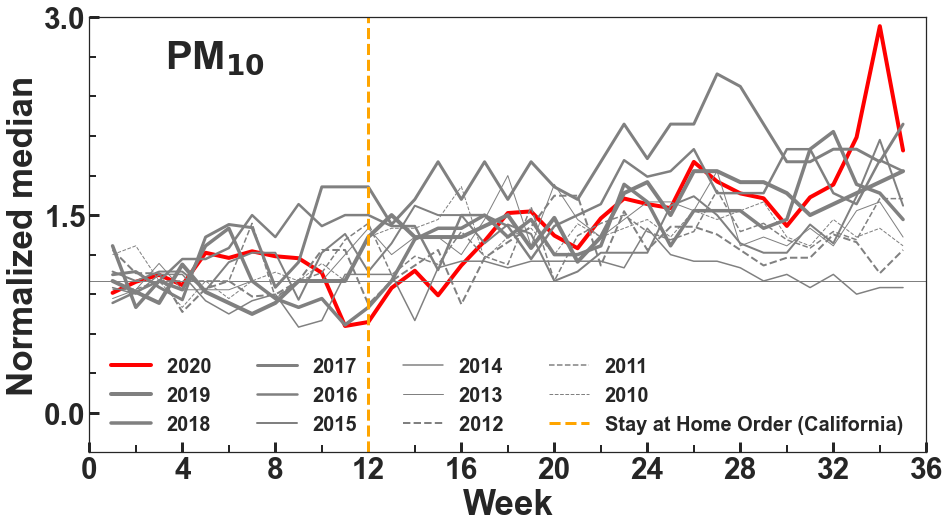

In [18]:
x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]
fig= plt.figure(figsize=(15, 8))
plt.style.use('seaborn-white')
ax=fig.add_subplot(111)
plt.plot(x ,qs,color='red', label='2020 ',linewidth=4)
plt.plot(x,qss , color='grey',label='2019', linewidth=4)
plt.plot(x,qsss , color='grey', label='2018',linewidth=3.5)
plt.plot(x,qssss , color='grey', label='2017',linewidth=3)
plt.plot(x ,qq,color='grey', label='2016 ',linewidth=2.5)
plt.plot(x,qqq , color='grey',label='2015', linewidth=2)
plt.plot(x,qqqq , color='grey', label='2014',linewidth=1.5)
plt.plot(x,qqqqq , color='grey', label='2013',linewidth=1)
plt.plot(x ,qz,color='grey', label='2012 ',linewidth=2,linestyle='dashed')
plt.plot(x,qzz , color='grey',label='2011', linewidth=1.5,linestyle='dashed')
plt.plot(x,qzzz , color='grey', label='2010',linewidth=1,linestyle='dashed')


plt.rcParams["axes.labelweight"] = "bold"
ax.yaxis.set_major_locator(MultipleLocator(1.5))
ax.xaxis.set_major_locator(MultipleLocator(4))
plt.ylim(-0.3,3.0)
plt.xlim(0,we+1)
plt.axvline(x=12, color='orange', label='Stay at Home Order (California) ',linestyle='dashed',linewidth=3)
    #plt.axvspan('Week12', 'Week16', alpha=0.1, color='orange',label="Lockdown")
    #plt.xticks(1)
plt.axhline(y=1, color='grey',linewidth=1)
#plt.xticks(np.arange(0, max(x)+1, 2.0))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
plt.xlabel('Week',fontsize='35',fontweight='bold')
plt.ylabel('Normalized median',fontsize='35',fontweight='bold')

ax.tick_params(axis='y', which='minor', bottom=True,direction='in',length=7, width=2)
ax.tick_params(axis='y', which='major', bottom=True,direction='in',length=10, width=3)
ax.tick_params(axis='x', which='major', bottom=True,direction='in',length=10, width=3)
ax.tick_params(axis='x', which='minor', bottom=True,direction='in',length=7, width=2)
#plt.ylabel('Median PM2.5 during weeks / Median PM 2.5 in January',fontsize='14', fontweight='bold')
plt.legend(loc='lower right',fontsize='20',frameon=False,ncol=4)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
                     label.set_fontname('Arial')
                     label.set_fontsize(30)
                     label.set_fontweight('bold')
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.rcParams["font.size"] = "20"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelsize"] = "20"
plt.title('PM$_{10}$',fontsize='40',fontweight='bold',x=0.15,y=0.87)
plt.savefig('PM10 normalized to Jan.png', bbox_inches='tight')

In [20]:
#Starting IDW
k1=pd.DataFrame(idw5)
k1=k1.drop_duplicates()
k1.columns=['ID','Latitude','Longitude']
k1=k1.reset_index(drop=True)
IDW= list(k1['ID'])

k2=pd.DataFrame(adjusted5)
k2.columns=['ID','Latitude','Longitude','Slope','Week']
k2=k2.drop(['Slope'],axis=1)
k2=k2.drop(['Week'],axis=1)
k2=k2.drop_duplicates()
adjusted5=pd.DataFrame(adjusted5)
adjusted5.columns=['ID','Latitude','Longitude','Slope','Week']
k2.dropna()
k2=k2.drop_duplicates()

In [21]:
#IDW with nearest stations in 50km
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('haversine')
distance=pd.DataFrame(dist.pairwise(k2[['Latitude','Longitude']].to_numpy(), k1[['Latitude','Longitude']].to_numpy())*6373,columns=k1["ID"], index=k2["ID"])

In [22]:
#IDW
Slope1=pd.DataFrame()
w=[]

for i in range (0, len(IDW)):
    
    monitor=IDW[i]
    s=distance[monitor]
    
    #find 3 nearest monitors in 50 km
    nearest=s[s<50]
    nearest=nearest[nearest>0]
    nearest=nearest.sort_values(ascending=True)
    nearest=nearest.iloc[:3]
    idw=pd.DataFrame()
    
    #If there are monitors
    if len(nearest)!= 0:
        n=0
        
        o=list(nearest)
        
        #For each of the nearest monitors finding slope and distance:
        for j in range (0,len(nearest)):
            
            nearest_mon=nearest.index[j]
            nearest_slope=list(Slope5[str(nearest_mon)])      
            nearest_slope.append(1/nearest.iloc[j])
            nearest_slope=pd.DataFrame(nearest_slope)
            nearest_slope.columns=[n]
            idw=pd.concat([idw,nearest_slope],axis=1,sort=False)
            n=n+1
            
            length=len(list(idw[0]))
            idw_df=pd.DataFrame()
            df=pd.DataFrame()
            
            #Dataframing slope for nearest monitor and inverse distance to that monitor
            for l in range (0,len(idw.columns)):
                 t=[]      
                 for m in range (0,length-1):

                         t.append([list(idw[l])[m]*list(idw[l])[length-1],list(idw[l])[length-1]])
                       #  print(list(idw[l])[m])
                 t=pd.DataFrame(t)

                 df=pd.concat([df,t],axis=1,sort=False) 
                 df=pd.DataFrame(df)
                 

        idw_df=pd.concat([idw_df,df],axis=1,sort=False)
        idw_df=idw_df.transpose()

        slp=[]
        
        #Aggregating nearest monitor slopes and distance 
        for z in range(0,len(idw_df.columns)):
                row=list(idw_df[z])
                nom=0
                denom=0
                for y in range (0,len(row)-1,2):
                    if pd.notnull(row[y]):
                     nom=nom+row[y]
                     
                     denom=denom+row[y+1]

                if denom!=0:
                 frac=nom/denom
                 slp.append(frac)
        slp=pd.DataFrame(slp)
        slp.columns=[monitor]

        #Output 
        Slope1=pd.concat([Slope1,slp],axis=1,sort=False)
            






In [23]:
#Finding D value from IDW


#Defining output
DF1=pd.DataFrame()
Slope2=pd.DataFrame()
OT1=pd.DataFrame()
adjusted=[]
idw=[]


#Calling each state file

Data = pd.read_csv("/Users/Bujin/Downloads/PM10.csv",parse_dates=['Date'], date_parser=dateparse)


a=set(Data['ID']).intersection(Slope1.columns) #Taking the intersection of IDW monitors and all monitors
a=list(a)

    #Defining output
df=pd.DataFrame()
slope1=pd.DataFrame()
ot=pd.DataFrame()
    
    #for each station calculate D value   
for iii in range(0,len(a)):
       monitor=Data[Data['ID']==a[iii]]
       
       #Defining as variables
       site=list(monitor['name'])[1]        
       state=list(monitor['State'])[1] 
       idd=list(monitor['ID'])[1]
       county=list(monitor['County'])[1]
       lon=(list(monitor['Longitude'])[1])
       lat=(list(monitor['Latitude'])[1])
       weeknum=0
    
       #Defining output
       List10=[] 
       slope=[]  
    
       #Starting filters
       

       whole=monitor[monitor['Date']<pd.to_datetime('2020-09-'+str(lastday))] ##Change this date (add 7 days each week)
       twentytwenty=pd.concat([whole['Date'],whole['2020']],axis=1,sort=False)
       twentytwenty=twentytwenty.dropna()
       pre=twentytwenty[twentytwenty['Date']<pd.to_datetime('2020-03-19')]
       post=twentytwenty[twentytwenty['Date']>=pd.to_datetime('2020-03-19')]


       #Number of days for adjusting
       adjusting=monitor[monitor['Date']<pd.to_datetime('2020-09-'+str(twoweeks))] ## Change this date (add 7 days each week)

       #dropping years if it has incomplete data
       drop=adjusting.drop(['2020'],axis=1)
       drop=drop.dropna(thresh=0.75*len(adjusting), axis=1)
       
       #checking if it has 2 years out of last 3 years
       Iqr=pd.concat([adjusting['2019'],adjusting['2018'],adjusting['2017']],axis=1,sort=False)
       Iqr = Iqr.dropna(thresh=0.75*len(Iqr), axis=1)
       
       
       
       start='2020-01-01'
       
       #Using monitors that have enough data
       if len(drop.columns)>=10 and len(post)>=length  and len(adjusting)>=totallength and len(pre)>=59 and len(Iqr.columns)>=2:   ##Change this (add 5 days on post and adjusting each week)
                                        
        for j in range(0,len(whole),7): # Week by week
            
           #Start and end date for each week
           start_d = pd.to_datetime(start) + datetime.timedelta(j)
           end_d = start_d + datetime.timedelta(7)
         
           week=monitor[monitor['Date']>=start_d]
           week=week[week['Date']<end_d]
            
           #Week 
           twenty=pd.DataFrame(week["2020"])
           weeknum=weeknum+1 #Week #
           
           #Month (for adjusting)
           end_date = list(week['Date'])[0] + datetime.timedelta(days=21) # +2 weeks
           start_date = list(week['Date'])[0] - datetime.timedelta(days=14) # -2 weeks

        
           # First 2 weeks of the year, add december data from previous year
           if pd.to_datetime('2020-01-01')== list(week['Date'])[0] :
               half=monitor[monitor["Date"]>='2020-12-18']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-22']
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011","2009":'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           elif list(week['Date'])[0]==pd.to_datetime('2020-01-08'):
               half=monitor[monitor["Date"]>'2020-12-24']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-29'] 
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011",'2009':'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           else:
               month=monitor[monitor["Date"]>=start_date]
               month=month[month["Date"]<end_date]
               month=month.drop(['2009'],axis=1)
        
           #if len(month.columns)==19:
               #month=month.drop(['2009'],axis=1)
           
           Mnth=month.drop(['2020'], axis=1)
           
           #Change the 2020 data to only that particular week
           month["2020"]=twenty
           
           #Dropping columns to get only historical data
           months=month.drop(['2020'],axis=1)
           months=months.drop(['name'],axis=1)
           months=months.drop(['State'],axis=1)
           months=months.drop(['Longitude'],axis=1)          
           months=months.drop(['Latitude'],axis=1)
           months=months.drop(['Date'],axis=1)
           months=months.drop(['ID'],axis=1)
           months=months.drop(['id'],axis=1)
           months=months.drop(['County'],axis=1)
           five=months
           five=five.drop(['2010'],axis=1)
           five=five.drop(['2011'],axis=1)
           five=five.drop(['2012'],axis=1)
           five=five.drop(['2013'],axis=1)
           five=five.drop(['2014'],axis=1)           



           #Filtering data, using years that have enough data
           historical=months.dropna(thresh=0.75*len(months),axis=1)
           #historical=months.dropna(axis=1,how='all')
           histfive=five.dropna(thresh=0.75*len(five),axis=1)
           #Finding median for each year
           medians=np.nanmedian(historical,axis=0)
           fivemed=np.nanmedian(histfive,axis=0)
           #Finding iqr
           IQR_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=Iqr.columns)
           IQR_melt=IQR_melt.dropna()
           IQR_melt.columns = ['index', 'year', 'value']
           
           #Finding slope of historical data
           hist_slope=pd.DataFrame({"x":pd.to_numeric(historical.columns),"y":np.array(medians)})
           x=hist_slope["x"]
           y=hist_slope["y"]
           five_slope=pd.DataFrame({"x":pd.to_numeric(histfive.columns),"y":np.array(fivemed)})
           x5=five_slope["x"]
           y5=five_slope["y"]


           #Finding historical median
           
           Historical_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=historical.columns)
           Historical_melt.columns = ['index', 'year', 'value']
 
           five_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=histfive.columns)
           five_melt.columns = ['index', 'year', 'value']


                  
                  #10 year median 
           Med=np.nanmedian(five_melt['value'])  
                  
                  #Adjusting historical median with IDW slope
           adjusted_med =  list(Slope1[idd])[weeknum-1] * (len(histfive.columns)+1)/2 + Med

                  #Calculating D value 
           D_value=(np.nanmedian(month['2020'])-adjusted_med)/iqr(IQR_melt['value'])  
                
                  #Appending for output
           List10.append([D_value,np.nanmedian(month['2020']),Med,adjusted_med,list(Slope1[idd])[weeknum-1],999,("Week "+str(weeknum)),state,idd,county,lat,lon])
           slope.append(list(Slope1[idd])[weeknum-1])       

                
        slope=pd.DataFrame(slope)
        
        #Preparing for idw
        
        if slope.size>0:
           slope.columns=[str(idd)]
         

        ot=pd.concat([ot,monitor],axis=0,sort=False)
        slope1=pd.concat([slope1,slope],axis=1,sort=False)   
        List10=pd.DataFrame(List10)
        df=pd.concat([df, List10], axis=0, sort=False)      

    #Concating for output
       
OT2=pd.concat([OT1,ot],axis=0,sort=False)
DF1=pd.concat([DF1, df], axis=0, sort=False)
Slope2=pd.concat([Slope2,slope1],axis=1,sort=False)
  

/Users/Bujin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



In [24]:
#Concat both outputs
MapData=pd.concat([DF5,DF1],axis=0,sort=False)
MapData.columns=['Ratio','Median','Unadjusted','Expected','Slope','Rsquared','Week','state','ID','County','Latitude','Longitude']

In [25]:
Map=MapData.dropna()
ag = Map.groupby('ID')['Week'].nunique()
Dta=pd.DataFrame()

for i in range (0,len(ag.index)):
    a=ag.index[i]
    indexNames = MapData[ MapData['ID'] == a ].index
    #using station that have at least 75% of the weeks
    if ag.iloc[i]>28:
      Dta=pd.concat([Dta,MapData[MapData['ID']==a]])
Dta=Dta.dropna()
Dta.drop_duplicates(subset=['Week', 'ID'], inplace=True, keep='first')
Dta.to_csv(r"/Users/Bujin/Downloads/PM10 5 year non aggregated.csv", index = False)



In [26]:
Dta['ID'].nunique()

143